In [1]:
import struct
import pandas as pd
import numpy as np
import os
from image_header import ImageHeader
import matplotlib.pyplot as plt

# Transform binary data to pd.DataFrame

In [2]:
struct_fmt = '=lldddddddddd' # int[5], float, byte[255]
struct_len = struct.calcsize(struct_fmt)
struct_unpack = struct.Struct(struct_fmt).unpack_from

struct_fmt2 = '=hhddddddddccccfhhhhh' # int[5], float, byte[255]
struct_len2 = struct.calcsize(struct_fmt2)
struct_unpack2 = struct.Struct(struct_fmt2).unpack_from

results = []
filename = 'outputOG.bin'
with open(filename, "rb") as f:
    while True:
        data1 = f.read(struct_len)
        if not data1:
            break
        s1 = struct_unpack(data1)
        # print(s1)
        for i in range(0, 97):
            data2 = f.read(struct_len2)
            if not data2:
                break
            s2 = struct_unpack2(data2) + s1
            results.append(s2)
f.close()
            

pnts = pd.DataFrame(results, columns=['row', 'col', 'x', 'y', 'z', 'norm_x', 'norm_y', 'norm_z',
                                      'alpha', 'radius', 'vis1', 'vis2', 'vis3', 'vis4', 'hrel',
                                      'R', 'G', 'B', 'N', 'P',
                                     'Serial', 'ImageCode', 'ViewZenith', 'SunAzimuth', 'SunElevation', 'AzimDiff',
                                     'SunVecX', 'SunVecY', 'SunVecZ', 'CamVecX', 'CamVecY', 'CamVecZ'])

# Transform visibilities to integers
pnts[['vis1', 'vis2', 'vis3', 'vis4']] = pnts[['vis1', 'vis2', 'vis3', 'vis4']].astype(int)
print(pnts.shape)

# Assign class to visibility
pnts['visibility'] = 'sunlit'
pnts.loc[(pnts['vis1'] == 1), 'visibility'] = 'self_shadowed'
pnts.loc[(pnts['vis2'] == 1), 'visibility'] = 'self_occluded'
pnts.loc[(pnts['vis3'] == 1), 'visibility'] = 'shadowed'
pnts.loc[(pnts['vis4'] == 1), 'visibility'] = 'occluded'


# Transform data
pnts['SunElevation'] = 90 - np.degrees(pnts['SunElevation'])
pnts['SunAzimuth'] = np.degrees(pnts['SunAzimuth'])

# Read tree-data and merge with point-data
young = pd.read_csv('/home/markus/Documents/Gradu2021/vanha_metsa_puut2.csv')
pnts = pd.merge(pnts, young, left_on='Serial', right_on='Serial')
print(pnts.shape)

# Calculate additional angles to restrict used pixel values
pnts['AVX'] = np.cos(pnts['alpha'])
pnts['AVY'] = np.sin(pnts['alpha'])

pnts['NSUN2D'] = np.arccos((pnts['norm_x'] * pnts['SunVecX'] + pnts['norm_y'] * pnts['SunVecY'] + 0.000000001 * 0.000000001) /\
                           ((np.power(pnts['norm_x'] ** 2 + pnts['norm_y'] ** 2 + 0.000000001 ** 2, 0.5) * \
                     np.power(pnts['SunVecX'] ** 2 + pnts['SunVecY'] ** 2 + 0.000000001 ** 2, 0.5))))
pnts['NSUN2D'] = np.degrees(pnts['NSUN2D'])

pnts['NCAM3D'] = np.arccos((pnts['norm_x'] * pnts['CamVecX'] + pnts['norm_y'] * pnts['CamVecY'] + pnts['norm_z'] * pnts['CamVecZ']) /\
                 (np.power(pnts['CamVecX'] ** 2 + pnts['CamVecY'] ** 2 + pnts['CamVecZ'] ** 2, 0.5) * \
                 np.power(pnts['norm_x'] ** 2 + pnts['norm_y'] ** 2 + pnts['norm_z'] ** 2, 0.5)))
pnts['NCAM3D'] = np.degrees(pnts['NCAM3D'])



pnts = pnts[pnts['NCAM3D'] < 91]
mask = (((pnts['NSUN2D'] < 60) & (pnts['visibility'] == 'sunlit')) | ((pnts['NSUN2D'] > 120) & (pnts['visibility'] == 'self_shadowed')))
mask2 = (pnts['norm_z'] == 1.0)
pnts = pnts[mask | mask2]

pnts = pnts.drop_duplicates(subset=['Serial', 'ImageCode', 'row', 'col'])
pnts = pnts[pnts['ViewZenith'] < 20]

(2191812, 32)
(2191812, 50)


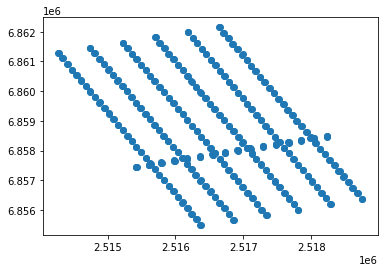

In [3]:
import time

def get_headers_in_dir(mydir: str) -> list:
    """
    Return header file paths in given directory (mydir)
    """
    ls = []
    for file in os.listdir(mydir):
        if file.endswith(".hdr"):
            ls.append(os.path.join(mydir, file))
    return ls

pan_headers = get_headers_in_dir('/media/markus/Ubuntu_Markus/Kuvat/Lvl2/PAN_HDR')
pan_headers[0]


res = []
for header_path in pan_headers:
    hdr1 = ImageHeader(header_path)
    hdr1.read_header()
    r = (hdr1.image_code, hdr1.x0, hdr1.y0)
    res.append(r)

imgc = pd.DataFrame(res, columns=['ImageCode', 'ImageX', 'ImageY'])
plt.scatter(imgc['ImageX'], imgc['ImageY'])

# Calculate image-pairs

In [4]:
triplets = pd.read_csv('triplets.csv')
imgc = pd.read_csv('image_pairs.csv') # 2 is with triples
imgc.shape

(192, 6)

In [5]:
sun_vals = pd.read_csv('sun_elevation_azimuth_2012.csv')
sun_vals
res = []
xs = []
ys = []
if imgc is None:
    for header_path in pan_headers:

        hdr1 = ImageHeader(header_path)
        hdr1.read_header()

        image_filename = hdr1.get_filename()
        splitted_name = image_filename.split('/')
        image_num = splitted_name[-2]

        vals = sun_vals[sun_vals['image_number'] == int(image_num)]
        elev1 = np.radians(vals.iloc[0]['sun_elevation'])
        cl = 30
        for header_path2 in pan_headers:
            hdr2 = ImageHeader(header_path2)
            hdr2.read_header()

            image_filename = hdr2.get_filename()
            splitted_name = image_filename.split('/')
            image_num = splitted_name[-2]

            vals = sun_vals[sun_vals['image_number'] == int(image_num)]
            elev2 = np.radians(vals.iloc[0]['sun_elevation'])
            dist = np.sqrt((hdr2.x0-hdr1.x0)**2 + (hdr2.y0-hdr1.y0)**2)
            el = np.degrees(elev1) - np.degrees(elev2)
            if dist != 0 and dist < 30 and el < 5 and el > 0:
                if hdr1.image_code != hdr2.image_code:
                    r = (hdr1.image_code,
                             hdr2.image_code,
                             el, np.degrees(elev1),
                            np.degrees(elev2))
                    res.append(r)
                    xs.append(hdr2.x0)
                    ys.append(hdr2.y0)

    imgc = pd.DataFrame(res, columns=['ImageCode1', 'ImageCode2', 'ElevationDiff', 'Elevation1', 'Elevation2'])
    # imgc = imgc.drop_duplicates(subset=['ImageCode1', 'ImageCode2'])
    imgc.to_csv('image_pairs2.csv')

    plt.scatter(xs, ys)
imgc

Unnamed: 0  ImageCode1  ImageCode2  ElevationDiff  Elevation1  Elevation2
0             0      310368      310160       4.229555   37.345547   33.115992
1             1      310360      310152       4.231822   37.308239   33.076416
2             2      510428      510220       4.115184   38.489328   34.374144
3             3      210321      210113       4.302171   36.667089   32.364919
4             4      110298      110090       4.277106   36.124604   31.847498
..          ...         ...         ...            ...         ...         ...
187         187      610473      610265       4.048918   39.123107   35.074189
188         188      210324      210116       4.301015   36.678680   32.377665
189         189      310383      310175       4.227119   37.416791   33.189673
190         190      610458      610250       4.055713   39.062472   35.006759
191         191      510424      510216       4.119137   38.472218   34.353081

[192 rows x 6 columns]

# Calculate pair_id for pairs and for triplets calculate start_end_total

In [6]:
def h(d):
    """
    Function that calculate images pairs in locations of 5 m distance
    """
    d = d.iloc[0:3]
    d = d.sort_values(by=['Elevation1'], ascending=True)
    
    d['start_end_total'] = np.arange(1, d.shape[0]+1, 1)
    d['start_end_total'] = str(0) + '-' + d['start_end_total'].astype(str) + '-' +str(d.shape[0])
    
    dsh = d.shape[0]
    
    if d.shape[0] > 1:
        for i in range(0, d.shape[0] - 1):
            cod2 = d.iloc[i]['ImageCode1']
            cod1 = d.iloc[i+1]['ImageCode1']
            res = pd.DataFrame({
                'ImageCode1': cod1,
                'ImageCode2': cod2,
                'start_end_total': str(i+1) + '-' + str(i+2) + '-' + str(dsh),
                'Elevation1': d.iloc[i+1]['Elevation1'],
                'Elevation2': d.iloc[i]['Elevation1'],
            }, index=[0])
            d = d.append(res)
            
    d['ElevationDiff'] = d['Elevation1'] - d['Elevation2']
    d['pair_id'] = str(d.iloc[0]['ImageCode1']) + '-' 't'
    return d
    
tr = imgc.groupby('ImageCode2').apply(h)
tr.shape

(192, 8)

# Calculate mean values for each band for groups of Serial, ImageCode and visibility

In [7]:
res = pnts.groupby(['Serial', 'ImageCode', 'visibility'])[['B', 'G', 'R', 'N', 'P']].mean()
res['B'] = res['B']  - (77 + 67)
res['G'] = res['G'] - (76 + 50)
res['R'] = res['R'] - (47 + 38) 
res['N'] = res['N'] -  (214 + 40)
res['P'] = res['P'] - (60 + 47)

res_r = pnts.groupby(['Serial', 'ImageCode', 'visibility'])[['B', 'G', 'R', 'N', 'P']].mean()
res_r['B'] = -0.0000425049286896378 + 0.000163000081936 * (res_r['B']  - (77 + 67))
res_r['G'] = 0.001870326708756 + 0.000145135211975 * (res_r['G'] - (76 + 50))
res_r['R'] = 0.007979164620919 + 0.000122451943818 * (res_r['R'] - (47 + 38))
res_r['N'] = 0.007021768141202 + 0.000129384723333 * (res_r['N'] -  (214 + 40))
res_r['P'] = 0.006927989981104 + 0.000147029925454 * (res_r['P'] - (60 + 35))
res_r

B         G         R         N  \
Serial ImageCode visibility                                              
29615  210129    self_shadowed  0.003598  0.014394  0.022260  0.115651   
                 sunlit         0.007564  0.024028  0.030796  0.153399   
       210130    self_shadowed  0.004256  0.014169  0.021236  0.121119   
                 sunlit         0.007502  0.023143  0.026452  0.159400   
       210131    self_shadowed  0.007064  0.017806  0.019620  0.143790   
...                                  ...       ...       ...       ...   
30155  410194    sunlit         0.035954  0.060037  0.049348  0.323580   
       410401    self_shadowed  0.020789  0.041763  0.035376  0.217686   
                 sunlit         0.020747  0.039447  0.034618  0.220042   
       410402    self_shadowed  0.024645  0.048789  0.037334  0.232210   
                 sunlit         0.027212  0.051016  0.042046  0.250381   

                                       P  
Serial ImageCode visibility               
29615  210129    self_shadowed  0.016111  
                 sunlit         0.025429  
       210130    self_shadowed  0.017119  
                 sunlit         0.027365  
       210131    self_shadowed  0.017975  
...                                  ...  
30155  410194    sunlit         0.055510  
       410401    self_shadowed  0.030139  
                 sunlit         0.043973  
       410402    self_shadowed  0.039368  
                 sunlit         0.050094  

[22477 rows x 5 columns]

# Calculating mean reflectances

In [8]:
imgc = tr
results = []
serials = pnts['Serial'].unique()
for i in serials:
    species = pnts[pnts['Serial'] == i].iloc[0]['Plaji']
    for index, row in imgc.iterrows():
        try:
            el_diff = row['ElevationDiff']
            
            # ImageCode2 is taken first -> ImageCode1 after sun elevation increase
            vals1 = res_r.loc[(i, row['ImageCode1'], 'sunlit'), :]
            vals2 = res_r.loc[(i, row['ImageCode2'], 'sunlit'), :]
            sunlitb, sunlitg, sunlitr, sunlitn, sunlitp = (vals1 + vals2) / 2
            
            
            # ImageCode2 is taken first -> ImageCode1 after sun elevation increase
            vals1 = res_r.loc[(i, row['ImageCode1'], 'self_shadowed'), :]
            vals2 = res_r.loc[(i, row['ImageCode2'], 'self_shadowed'), :]
            shadowb, shadowg, shadowr, shadown, shadowp = (vals1 + vals2) / 2
            
            # Triplet or pair-id
            pair_id = str(i) + '-' + row['pair_id']
            
            q = (
                 species,
                 i,
                 sunlitb,
                 shadowb,
                 sunlitg,
                 shadowg,
                 sunlitr,
                 shadowr,
                 sunlitn,
                 shadown,
                 sunlitp,
                 shadowp,
                 row['ImageCode1'],
                 row['ImageCode2'],
                 row['start_end_total'],
                 pair_id,
                 row['ElevationDiff'],
                 row['Elevation1'],
                 row['Elevation2']
            )
            results.append(q)
        except Exception as e:
            continue
            
reflectances = pd.DataFrame(results, columns=['Species',
                                     'Serial',
                                     'SLB', 'SHB','SLG','SHG', 'SLR','SHR', 'SLN', 'SHN', 'SLP', 'SHP',
                                     'ImageCode1','ImageCode2',
                                     'start_end_total',
                                     'pair_id',
                                     'ElevationDiff','Elevation1', 'Elevation2'])

# CHA.to_csv("PAIRS/ADD/ABSOLUTE_CHANGES_BY_TREES_PAIRS_ADD.csv")

In [9]:
reflectance = reflectances.loc[reflectances['Species'] == 4, 'Species'] = 3
r_sp = reflectances.groupby('Species')['SLB', 'SHB','SLG','SHG', 'SLR','SHR', 'SLN', 'SHN', 'SLP', 'SHP'].mean()
np.round(r_sp, 3)


/tmp/ipykernel_22359/415055877.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  r_sp = reflectances.groupby('Species')['SLB', 'SHB','SLG','SHG', 'SLR','SHR', 'SLN', 'SHN', 'SLP', 'SHP'].mean()


SLB    SHB    SLG    SHG    SLR    SHR    SLN    SHN    SLP    SHP
Species                                                                      
1        0.020  0.012  0.038  0.024  0.035  0.025  0.192  0.138  0.039  0.027
2        0.016  0.007  0.034  0.018  0.031  0.020  0.184  0.118  0.036  0.021
3        0.022  0.013  0.043  0.027  0.040  0.027  0.278  0.192  0.043  0.029

# Calculate values for first image of pairs

In [10]:
imgc = tr
results = []
serials = pnts['Serial'].unique()
for i in serials:
    species = pnts[pnts['Serial'] == i].iloc[0]['Plaji']
    for index, row in imgc.iterrows():
        try:
            el_diff = row['ElevationDiff']
            
            # ImageCode2 is taken first -> ImageCode1 after sun elevation increase
            vals1 = res.loc[(i, row['ImageCode1'], 'sunlit'), :]
            vals2 = res.loc[(i, row['ImageCode2'], 'sunlit'), :]
            diff = vals1 - vals2
            sunlitb, sunlitg, sunlitr, sunlitn, sunlitp = vals2
            
            
            # ImageCode2 is taken first -> ImageCode1 after sun elevation increase
            vals1 = res.loc[(i, row['ImageCode1'], 'self_shadowed'), :]
            vals2 = res.loc[(i, row['ImageCode2'], 'self_shadowed'), :]
            diff = vals1 - vals2
            shadowb, shadowg, shadowr, shadown, shadowp = vals2
            
            # Triplet or pair-id
            pair_id = str(i) + '-' + row['pair_id']
            
            # Triplet or pair-id
            pair_id = str(i) + '-' + row['pair_id']
            
            q = (
                 species,
                 i,
                 sunlitb,
                 shadowb,
                 sunlitg,
                 shadowg,
                 sunlitr,
                 shadowr,
                 sunlitn,
                 shadown,
                 sunlitp,
                 shadowp,
                 row['ImageCode1'],
                 row['ImageCode2'],
                 row['start_end_total'],
                 pair_id,
                 row['ElevationDiff'],
                 row['Elevation1'],
                 row['Elevation2']
            )
            results.append(q)
        except Exception as e:
            continue
            
pair_1 = pd.DataFrame(results, columns=['Species',
                                     'Serial',
                                     'SLB', 'SHB','SLG','SHG', 'SLR','SHR', 'SLN', 'SHN', 'SLP', 'SHP',
                                     'ImageCode1','ImageCode2',
                                     'start_end_total',
                                     'pair_id',
                                     'ElevationDiff','Elevation1', 'Elevation2'])

# Calculate values for second image of pairs

In [11]:
imgc = tr
results = []
serials = pnts['Serial'].unique()
for i in serials:
    species = pnts[pnts['Serial'] == i].iloc[0]['Plaji']
    for index, row in imgc.iterrows():
        try:
            el_diff = row['ElevationDiff']
            
            # ImageCode2 is taken first -> ImageCode1 after sun elevation increase
            vals1 = res.loc[(i, row['ImageCode1'], 'sunlit'), :]
            vals2 = res.loc[(i, row['ImageCode2'], 'sunlit'), :]
            diff = vals1 - vals2
            sunlitb, sunlitg, sunlitr, sunlitn, sunlitp = vals1
            
            
            # ImageCode2 is taken first -> ImageCode1 after sun elevation increase
            vals1 = res.loc[(i, row['ImageCode1'], 'self_shadowed'), :]
            vals2 = res.loc[(i, row['ImageCode2'], 'self_shadowed'), :]
            diff = vals1 - vals2
            shadowb, shadowg, shadowr, shadown, shadowp = vals1
            
            # Triplet or pair-id
            pair_id = str(i) + '-' + row['pair_id']
            
            # Triplet or pair-id
            pair_id = str(i) + '-' + row['pair_id']
            
            q = (
                 species,
                 i,
                 sunlitb,
                 shadowb,
                 sunlitg,
                 shadowg,
                 sunlitr,
                 shadowr,
                 sunlitn,
                 shadown,
                 sunlitp,
                 shadowp,
                 row['ImageCode1'],
                 row['ImageCode2'],
                 row['start_end_total'],
                 pair_id,
                 row['ElevationDiff'],
                 row['Elevation1'],
                 row['Elevation2']
            )
            results.append(q)
        except Exception as e:
            continue
            
pair_2 = pd.DataFrame(results, columns=['Species',
                                     'Serial',
                                     'SLB', 'SHB','SLG','SHG', 'SLR','SHR', 'SLN', 'SHN', 'SLP', 'SHP',
                                     'ImageCode1','ImageCode2',
                                     'start_end_total',
                                     'pair_id',
                                     'ElevationDiff','Elevation1', 'Elevation2'])

In [12]:
imgc = tr
results = []
serials = pnts['Serial'].unique()
for i in serials:
    species = pnts[pnts['Serial'] == i].iloc[0]['Plaji']
    for index, row in imgc.iterrows():
        try:
            el_diff = row['ElevationDiff']
            
            # ImageCode2 is taken first -> ImageCode1 after sun elevation increase
            vals1 = res.loc[(i, row['ImageCode1'], 'sunlit'), :]
            vals2 = res.loc[(i, row['ImageCode2'], 'sunlit'), :]
            diff = vals1 - vals2
            print(vals1.values)
            print(vals2.values)
            print(diff.values)
            sunlitb, sunlitg, sunlitr, sunlitn, sunlitp = diff
            
            # ImageCode2 is taken first -> ImageCode1 after sun elevation increase
            vals1 = res.loc[(i, row['ImageCode1'], 'self_shadowed'), :]
            vals2 = res.loc[(i, row['ImageCode2'], 'self_shadowed'), :]
            diff = vals1 - vals2
            shadowb, shadowg, shadowr, shadown, shadowp = diff
            
            # Triplet or pair-id
            pair_id = str(i) + '-' + row['pair_id']

            
            q = (
                 species,
                 i,
                 sunlitb,
                 shadowb,
                 sunlitg,
                 shadowg,
                 sunlitr,
                 shadowr,
                 sunlitn,
                 shadown,
                 sunlitp,
                 shadowp,
                 row['ImageCode1'],
                 row['ImageCode2'],
                 row['start_end_total'],
                 pair_id,
                 row['ElevationDiff'],
                 row['Elevation1'],
                 row['Elevation2']
            )
            results.append(q)
        except Exception as e:
            print(e)
            continue
            
mean_diff = pd.DataFrame(results, columns=['Species',
                                     'Serial',
                                     'SLB', 'SHB','SLG','SHG', 'SLR','SHR', 'SLN', 'SHN', 'SLP', 'SHP',
                                     'ImageCode1','ImageCode2',
                                     'start_end_total',
                                     'pair_id',
                                     'ElevationDiff','Elevation1', 'Elevation2'])

(29768, 110288, 'sunlit')
(29768, 110289, 'sunlit')
(29768, 110290, 'sunlit')
(29768, 110291, 'sunlit')
(29768, 110292, 'sunlit')
(29768, 110293, 'sunlit')
(29768, 110294, 'sunlit')
(29768, 110295, 'sunlit')
(29768, 110296, 'sunlit')
(29768, 110297, 'sunlit')
(29768, 110298, 'sunlit')
(29768, 110299, 'sunlit')
(29768, 110300, 'sunlit')
(29768, 110301, 'sunlit')
(29768, 110302, 'sunlit')
(29768, 110303, 'sunlit')
(29768, 110304, 'sunlit')
(29768, 110305, 'sunlit')
(29768, 110306, 'sunlit')
(29768, 110307, 'sunlit')
(29768, 110308, 'sunlit')
(29768, 110309, 'sunlit')
(29768, 110310, 'sunlit')
(29768, 110311, 'sunlit')
(29768, 110312, 'sunlit')
(29768, 110313, 'sunlit')
(29768, 110314, 'sunlit')
(29768, 110315, 'sunlit')
(29768, 110316, 'sunlit')
(29768, 110317, 'sunlit')
(29768, 110318, 'sunlit')
(29768, 110319, 'sunlit')
(29768, 210320, 'sunlit')
(29768, 210321, 'sunlit')
(29768, 210322, 'sunlit')
(29768, 210323, 'sunlit')
(29768, 210324, 'sunlit')
(29768, 210325, 'sunlit')
(29768, 2103

(29777, 410386, 'sunlit')
(29777, 410387, 'sunlit')
(29777, 410388, 'sunlit')
(29777, 410389, 'sunlit')
(29777, 410390, 'sunlit')
(29777, 410391, 'sunlit')
(29777, 410392, 'sunlit')
(29777, 410393, 'sunlit')
(29777, 410394, 'sunlit')
(29777, 410395, 'sunlit')
(29777, 410396, 'sunlit')
(29777, 410397, 'sunlit')
(29777, 410398, 'sunlit')
(29777, 410399, 'sunlit')
(29777, 410400, 'sunlit')
(29777, 410401, 'sunlit')
(29777, 410402, 'sunlit')
(29777, 410403, 'sunlit')
(29777, 410404, 'sunlit')
(29777, 410405, 'sunlit')
(29777, 410406, 'sunlit')
(29777, 410407, 'sunlit')
(29777, 410408, 'sunlit')
(29777, 410409, 'sunlit')
(29777, 410410, 'sunlit')
(29777, 410411, 'sunlit')
(29777, 410412, 'sunlit')
(29777, 410413, 'sunlit')
(29777, 410414, 'sunlit')
(29777, 410415, 'sunlit')
(29777, 510416, 'sunlit')
(29777, 510417, 'sunlit')
(29777, 510418, 'sunlit')
(29777, 510419, 'sunlit')
(29777, 510420, 'sunlit')
(29777, 510421, 'sunlit')
(29777, 510422, 'sunlit')
(29777, 510423, 'sunlit')
(29777, 5104

(30110, 110294, 'sunlit')
(30110, 110295, 'sunlit')
(30110, 110296, 'sunlit')
(30110, 110297, 'sunlit')
(30110, 110298, 'sunlit')
(30110, 110299, 'sunlit')
(30110, 110300, 'sunlit')
(30110, 110301, 'sunlit')
(30110, 110302, 'sunlit')
(30110, 110303, 'sunlit')
(30110, 110304, 'sunlit')
(30110, 110305, 'sunlit')
(30110, 110306, 'sunlit')
(30110, 110307, 'sunlit')
(30110, 110308, 'sunlit')
(30110, 110309, 'sunlit')
(30110, 110310, 'sunlit')
(30110, 110311, 'sunlit')
(30110, 110312, 'sunlit')
(30110, 110313, 'sunlit')
(30110, 110314, 'sunlit')
(30110, 110315, 'sunlit')
(30110, 110316, 'sunlit')
(30110, 110317, 'sunlit')
(30110, 110318, 'sunlit')
(30110, 110319, 'sunlit')
(30110, 210320, 'sunlit')
(30110, 210321, 'sunlit')
(30110, 210322, 'sunlit')
(30110, 210323, 'sunlit')
(30110, 210324, 'sunlit')
(30110, 210325, 'sunlit')
(30110, 210326, 'sunlit')
(30110, 210327, 'sunlit')
(30110, 210328, 'sunlit')
(30110, 210329, 'sunlit')
(30110, 210330, 'sunlit')
(30110, 210331, 'sunlit')
(30110, 2103

(30113, 510429, 'sunlit')
(30113, 510430, 'sunlit')
(30113, 510431, 'sunlit')
(30113, 510432, 'sunlit')
(30113, 510433, 'sunlit')
(30113, 510434, 'sunlit')
(30113, 510435, 'sunlit')
(30113, 510436, 'sunlit')
(30113, 510437, 'sunlit')
(30113, 510438, 'sunlit')
(30113, 510439, 'sunlit')
(30113, 510440, 'sunlit')
(30113, 510441, 'sunlit')
(30113, 510442, 'sunlit')
(30113, 510443, 'sunlit')
(30113, 510444, 'sunlit')
(30113, 510445, 'sunlit')
(30113, 510446, 'sunlit')
(30113, 510447, 'sunlit')
(30113, 610448, 'sunlit')
(30113, 610449, 'sunlit')
(30113, 610450, 'sunlit')
(30113, 610451, 'sunlit')
(30113, 610452, 'sunlit')
(30113, 610453, 'sunlit')
(30113, 610454, 'sunlit')
(30113, 610455, 'sunlit')
(30113, 610456, 'sunlit')
(30113, 610457, 'sunlit')
(30113, 610458, 'sunlit')
(30113, 610459, 'sunlit')
(30113, 610460, 'sunlit')
(30113, 610461, 'sunlit')
(30113, 610462, 'sunlit')
(30113, 610463, 'sunlit')
(30113, 610464, 'sunlit')
(30113, 610465, 'sunlit')
(30113, 610466, 'sunlit')
(30113, 6104

(29773, 310354, 'sunlit')
(29773, 310355, 'sunlit')
(29773, 310356, 'sunlit')
(29773, 310357, 'sunlit')
(29773, 310358, 'sunlit')
(29773, 310359, 'sunlit')
(29773, 310360, 'sunlit')
(29773, 310361, 'sunlit')
(29773, 310362, 'sunlit')
[ 302.38095238  402.85714286  410.95238095 1144.57142857  367.66666667]
[232.2  270.55 276.3  812.65 205.45]
[ 70.18095238 132.30714286 134.65238095 331.92142857 162.21666667]
[289.70588235 373.82352941 404.52941176 993.58823529 340.05882353]
[207.33333333 222.77777778 191.16666667 660.44444444 173.88888889]
[ 82.37254902 151.04575163 213.3627451  333.14379085 166.16993464]
[211.16666667 259.58333333 272.25       785.83333333 223.91666667]
[167.         175.07142857 146.71428571 563.92857143 127.35714286]
[ 44.16666667  84.51190476 125.53571429 221.9047619   96.55952381]
[218.125 226.    197.625 636.75  182.125]
[177.6 184.3 165.8 558.8 143.4]
[40.525 41.7   31.825 77.95  38.725]
[201.875 206.375 163.125 635.    174.625]
[161.         167.45454545 125.1818

(29780, 110305, 'sunlit')
(29780, 110306, 'sunlit')
(29780, 110307, 'sunlit')
(29780, 110308, 'sunlit')
(29780, 110309, 'sunlit')
(29780, 110310, 'sunlit')
(29780, 110311, 'sunlit')
(29780, 110312, 'sunlit')
(29780, 110313, 'sunlit')
(29780, 110314, 'sunlit')
(29780, 110315, 'sunlit')
(29780, 110316, 'sunlit')
(29780, 110317, 'sunlit')
(29780, 110318, 'sunlit')
(29780, 110319, 'sunlit')
(29780, 210320, 'sunlit')
(29780, 210321, 'sunlit')
(29780, 210322, 'sunlit')
(29780, 210323, 'sunlit')
(29780, 210324, 'sunlit')
(29780, 210325, 'sunlit')
(29780, 210326, 'sunlit')
(29780, 210327, 'sunlit')
(29780, 210328, 'sunlit')
(29780, 210329, 'sunlit')
(29780, 210330, 'sunlit')
(29780, 210331, 'sunlit')
(29780, 210332, 'sunlit')
(29780, 210333, 'sunlit')
(29780, 210334, 'sunlit')
(29780, 210335, 'sunlit')
(29780, 210336, 'sunlit')
[ 218.33333333  312.41666667  278.25       1644.33333333  271.16666667]
[ 165.5    212.625  196.25  1299.875  222.75 ]
[ 52.83333333  99.79166667  82.         344.45833

(29783, 510425, 'sunlit')
(29783, 510426, 'sunlit')
(29783, 510427, 'sunlit')
(29783, 510428, 'sunlit')
(29783, 510429, 'sunlit')
(29783, 510430, 'sunlit')
(29783, 510431, 'sunlit')
(29783, 510432, 'sunlit')
(29783, 510433, 'sunlit')
(29783, 510434, 'sunlit')
(29783, 510435, 'sunlit')
(29783, 510436, 'sunlit')
(29783, 510437, 'sunlit')
(29783, 510438, 'sunlit')
(29783, 510439, 'sunlit')
(29783, 510440, 'sunlit')
(29783, 510441, 'sunlit')
(29783, 510442, 'sunlit')
(29783, 510443, 'sunlit')
(29783, 510444, 'sunlit')
(29783, 510445, 'sunlit')
(29783, 510446, 'sunlit')
(29783, 510447, 'sunlit')
(29783, 610448, 'sunlit')
(29783, 610449, 'sunlit')
(29783, 610450, 'sunlit')
(29783, 610451, 'sunlit')
(29783, 610452, 'sunlit')
(29783, 610453, 'sunlit')
(29783, 610454, 'sunlit')
(29783, 610455, 'sunlit')
(29783, 610456, 'sunlit')
(29783, 610457, 'sunlit')
(29783, 610458, 'sunlit')
(29783, 610459, 'sunlit')
(29783, 610460, 'sunlit')
(29783, 610461, 'sunlit')
(29783, 610462, 'sunlit')
(29783, 6104

[ 290.23529412  480.23529412  396.76470588 2232.11764706  377.05882353]
[ 245.88888889  388.83333333  280.22222222 1969.5         314.38888889]
[ 44.34640523  91.40196078 116.54248366 262.61764706  62.66993464]
[ 272.45454545  417.54545455  310.90909091 2119.63636364  359.63636364]
[ 237.85714286  349.57142857  277.28571429 1820.78571429  275.5       ]
[ 34.5974026   67.97402597  33.62337662 298.85064935  84.13636364]
[ 250.72727273  372.63636364  265.27272727 1753.81818182  273.54545455]
[ 214.5         326.21428571  223.92857143 1717.85714286  258.71428571]
[36.22727273 46.42207792 41.34415584 35.96103896 14.83116883]
(29787, 310368, 'sunlit')
(29787, 310369, 'sunlit')
(29787, 310370, 'sunlit')
(29787, 310371, 'sunlit')
(29787, 310372, 'sunlit')
(29787, 310373, 'sunlit')
(29787, 310374, 'sunlit')
(29787, 310375, 'sunlit')
(29787, 310376, 'sunlit')
(29787, 310377, 'sunlit')
(29787, 310378, 'sunlit')
(29787, 310379, 'sunlit')
(29787, 310380, 'sunlit')
(29787, 310381, 'sunlit')
(29787, 

(29801, 110315, 'sunlit')
(29801, 110316, 'sunlit')
(29801, 110317, 'sunlit')
(29801, 110318, 'sunlit')
(29801, 110319, 'sunlit')
(29801, 210320, 'sunlit')
(29801, 210321, 'sunlit')
(29801, 210322, 'sunlit')
(29801, 210323, 'sunlit')
(29801, 210324, 'sunlit')
(29801, 210325, 'sunlit')
(29801, 210326, 'sunlit')
(29801, 210327, 'sunlit')
(29801, 210328, 'sunlit')
(29801, 210329, 'sunlit')
(29801, 210330, 'sunlit')
(29801, 210331, 'sunlit')
(29801, 210332, 'sunlit')
(29801, 210333, 'sunlit')
(29801, 210334, 'sunlit')
(29801, 210335, 'sunlit')
(29801, 210336, 'sunlit')
[ 203.75        270.5         231.91666667 1238.75        248.25      ]
[ 168.6  218.4  188.8 1087.   220.6]
[ 35.15        52.1         43.11666667 151.75        27.65      ]
[ 219.30769231  308.46153846  257.         1312.46153846  288.76923077]
[163.5   192.75  164.75  937.5   204.375]
[ 55.80769231 115.71153846  92.25       374.96153846  84.39423077]
[ 241.85  336.95  283.9  1349.8   310.9 ]
[186.33333333 218.88888889 15

(29804, 510430, 'sunlit')
(29804, 510431, 'sunlit')
(29804, 510432, 'sunlit')
(29804, 510433, 'sunlit')
(29804, 510434, 'sunlit')
(29804, 510435, 'sunlit')
(29804, 510436, 'sunlit')
(29804, 510437, 'sunlit')
(29804, 510438, 'sunlit')
(29804, 510439, 'sunlit')
(29804, 510440, 'sunlit')
(29804, 510441, 'sunlit')
(29804, 510442, 'sunlit')
(29804, 510443, 'sunlit')
(29804, 510444, 'sunlit')
(29804, 510445, 'sunlit')
(29804, 510446, 'sunlit')
(29804, 510447, 'sunlit')
(29804, 610448, 'sunlit')
(29804, 610449, 'sunlit')
(29804, 610450, 'sunlit')
(29804, 610451, 'sunlit')
(29804, 610452, 'sunlit')
(29804, 610453, 'sunlit')
(29804, 610454, 'sunlit')
(29804, 610455, 'sunlit')
(29804, 610456, 'sunlit')
(29804, 610457, 'sunlit')
(29804, 610458, 'sunlit')
(29804, 610459, 'sunlit')
(29804, 610460, 'sunlit')
(29804, 610461, 'sunlit')
(29804, 610462, 'sunlit')
(29804, 610463, 'sunlit')
(29804, 610464, 'sunlit')
(29804, 610465, 'sunlit')
(29804, 610466, 'sunlit')
(29804, 610467, 'sunlit')
(29804, 6104

[158.42857143 156.          98.85714286 685.28571429 134.14285714]
[ 223.45454545  288.81818182  245.54545455 1393.36363636  261.        ]
[ -65.02597403 -132.81818182 -146.68831169 -708.07792208 -126.85714286]
[166.5   160.875 101.125 648.    129.25 ]
[ 207.375  273.125  205.125 1369.5    222.5  ]
[ -40.875 -112.25  -104.    -721.5    -93.25 ]
(29821, 310368, 'sunlit')
(29821, 310369, 'sunlit')
(29821, 310370, 'sunlit')
(29821, 310371, 'sunlit')
(29821, 310372, 'sunlit')
(29821, 310373, 'sunlit')
(29821, 310374, 'sunlit')
(29821, 310375, 'sunlit')
(29821, 310376, 'sunlit')
(29821, 310377, 'sunlit')
(29821, 310378, 'sunlit')
(29821, 310379, 'sunlit')
(29821, 310380, 'sunlit')
(29821, 310381, 'sunlit')
(29821, 310382, 'sunlit')
(29821, 310383, 'sunlit')
(29821, 410384, 'sunlit')
(29821, 410385, 'sunlit')
(29821, 410386, 'sunlit')
(29821, 410387, 'sunlit')
(29821, 410388, 'sunlit')
(29821, 410389, 'sunlit')
(29821, 410390, 'sunlit')
(29821, 410391, 'sunlit')
(29821, 410392, 'sunlit')
(29

(29840, 310353, 'sunlit')
(29840, 310354, 'sunlit')
(29840, 310355, 'sunlit')
(29840, 310356, 'sunlit')
(29840, 310357, 'sunlit')
(29840, 310358, 'sunlit')
(29840, 310359, 'sunlit')
(29840, 310360, 'sunlit')
(29840, 310361, 'sunlit')
(29840, 310362, 'sunlit')
[ 311.625   507.1875  405.3125 2303.1875  425.    ]
[ 304.73684211  469.63157895  418.31578947 2297.31578947  374.31578947]
[  6.88815789  37.55592105 -13.00328947   5.87171053  50.68421053]
[ 319.21428571  489.42857143  401.14285714 2247.5         424.42857143]
[ 294.66666667  454.73333333  337.6        2320.33333333  374.46666667]
[ 24.54761905  34.6952381   63.54285714 -72.83333333  49.96190476]
[ 277.58333333  421.33333333  353.25       2096.58333333  309.41666667]
[ 276.46153846  413.15384615  318.23076923 2207.92307692  332.69230769]
[   1.12179487    8.17948718   35.01923077 -111.33974359  -23.27564103]
[ 245.77777778  344.66666667  245.88888889 1916.33333333  275.11111111]
[ 243.28571429  350.78571429  291.28571429 1965.5 

(29916, 110305, 'sunlit')
(29916, 110306, 'sunlit')
(29916, 110307, 'sunlit')
(29916, 110308, 'sunlit')
(29916, 110309, 'sunlit')
(29916, 110310, 'sunlit')
(29916, 110311, 'sunlit')
(29916, 110312, 'sunlit')
(29916, 110313, 'sunlit')
(29916, 110314, 'sunlit')
(29916, 110315, 'sunlit')
(29916, 110316, 'sunlit')
(29916, 110317, 'sunlit')
(29916, 110318, 'sunlit')
(29916, 110319, 'sunlit')
(29916, 210320, 'sunlit')
(29916, 210321, 'sunlit')
(29916, 210322, 'sunlit')
(29916, 210323, 'sunlit')
(29916, 210324, 'sunlit')
(29916, 210325, 'sunlit')
(29916, 210326, 'sunlit')
(29916, 210327, 'sunlit')
(29916, 210328, 'sunlit')
(29916, 210329, 'sunlit')
(29916, 210330, 'sunlit')
(29916, 210331, 'sunlit')
(29916, 210332, 'sunlit')
(29916, 210333, 'sunlit')
(29916, 210334, 'sunlit')
(29916, 210335, 'sunlit')
(29916, 210336, 'sunlit')
[ 200.14285714  244.28571429  223.28571429 1273.71428571  280.28571429]
[ 187.85714286  247.14285714  237.         1461.85714286  230.42857143]
[  12.28571429   -2.8571

(29919, 410402, 'sunlit')
(29919, 410403, 'sunlit')
(29919, 410404, 'sunlit')
(29919, 410405, 'sunlit')
(29919, 410406, 'sunlit')
(29919, 410407, 'sunlit')
(29919, 410408, 'sunlit')
(29919, 410409, 'sunlit')
(29919, 410410, 'sunlit')
(29919, 410411, 'sunlit')
(29919, 410412, 'sunlit')
(29919, 410413, 'sunlit')
(29919, 410414, 'sunlit')
(29919, 410415, 'sunlit')
(29919, 510416, 'sunlit')
(29919, 510417, 'sunlit')
(29919, 510418, 'sunlit')
(29919, 510419, 'sunlit')
(29919, 510420, 'sunlit')
(29919, 510421, 'sunlit')
(29919, 510422, 'sunlit')
(29919, 510423, 'sunlit')
(29919, 510424, 'sunlit')
(29919, 510425, 'sunlit')
(29919, 510426, 'sunlit')
(29919, 510427, 'sunlit')
(29919, 510428, 'sunlit')
(29919, 510429, 'sunlit')
(29919, 510430, 'sunlit')
(29919, 510431, 'sunlit')
(29919, 510432, 'sunlit')
(29919, 510433, 'sunlit')
(29919, 510434, 'sunlit')
(29919, 510435, 'sunlit')
(29919, 510436, 'sunlit')
(29919, 510437, 'sunlit')
(29919, 510438, 'sunlit')
(29919, 510439, 'sunlit')
(29919, 5104

[ 321.30769231  509.38461538  425.57692308 2065.73076923  417.34615385]
[ 264.23809524  374.76190476  277.9047619  1604.42857143  284.66666667]
[ 57.06959707 134.62271062 147.67216117 461.3021978  132.67948718]
[ 306.73684211  507.57894737  436.84210526 2256.42105263  392.68421053]
[ 236.64705882  336.41176471  249.64705882 1548.29411765  269.41176471]
[ 70.08978328 171.16718266 187.19504644 708.12693498 123.27244582]
[ 308.9  489.4  384.  2332.3  429.2]
[ 246.45454545  359.81818182  303.54545455 1704.90909091  289.45454545]
[ 62.44545455 129.58181818  80.45454545 627.39090909 139.74545455]
[ 291.09090909  456.63636364  337.27272727 2046.45454545  363.36363636]
[ 223.4  342.3  240.2 1701.1  259. ]
[ 67.69090909 114.33636364  97.07272727 345.35454545 104.36363636]
(29923, 310368, 'sunlit')
(29923, 310369, 'sunlit')
(29923, 310370, 'sunlit')
(29923, 310371, 'sunlit')
(29923, 310372, 'sunlit')
(29923, 310373, 'sunlit')
(29923, 310374, 'sunlit')
(29923, 310375, 'sunlit')
(29923, 310376, 's

(29927, 110315, 'sunlit')
(29927, 110316, 'sunlit')
(29927, 110317, 'sunlit')
(29927, 110318, 'sunlit')
(29927, 110319, 'sunlit')
(29927, 210320, 'sunlit')
(29927, 210321, 'sunlit')
(29927, 210322, 'sunlit')
(29927, 210323, 'sunlit')
(29927, 210324, 'sunlit')
(29927, 210325, 'sunlit')
(29927, 210326, 'sunlit')
(29927, 210327, 'sunlit')
(29927, 210328, 'sunlit')
(29927, 210329, 'sunlit')
(29927, 210330, 'sunlit')
(29927, 210331, 'sunlit')
(29927, 210332, 'sunlit')
(29927, 210333, 'sunlit')
(29927, 210334, 'sunlit')
(29927, 210335, 'sunlit')
(29927, 210336, 'sunlit')
[ 238.2  312.7  287.1 1834.4  305.9]
[ 230.33333333  312.          321.66666667 1972.83333333  314.66666667]
[   7.86666667    0.7         -34.56666667 -138.43333333   -8.76666667]
[ 218.8125  304.1875  267.     1675.625   294.    ]
[ 214.36363636  282.36363636  268.45454545 1755.72727273  270.54545455]
[  4.44886364  21.82386364  -1.45454545 -80.10227273  23.45454545]
[ 234.80952381  302.76190476  263.47619048 1708.04761905

(29931, 410413, 'sunlit')
(29931, 410414, 'sunlit')
(29931, 410415, 'sunlit')
(29931, 510416, 'sunlit')
(29931, 510417, 'sunlit')
(29931, 510418, 'sunlit')
(29931, 510419, 'sunlit')
(29931, 510420, 'sunlit')
(29931, 510421, 'sunlit')
(29931, 510422, 'sunlit')
(29931, 510423, 'sunlit')
(29931, 510424, 'sunlit')
(29931, 510425, 'sunlit')
(29931, 510426, 'sunlit')
(29931, 510427, 'sunlit')
(29931, 510428, 'sunlit')
(29931, 510429, 'sunlit')
(29931, 510430, 'sunlit')
(29931, 510431, 'sunlit')
(29931, 510432, 'sunlit')
(29931, 510433, 'sunlit')
(29931, 510434, 'sunlit')
(29931, 510435, 'sunlit')
(29931, 510436, 'sunlit')
(29931, 510437, 'sunlit')
(29931, 510438, 'sunlit')
(29931, 510439, 'sunlit')
(29931, 510440, 'sunlit')
(29931, 510441, 'sunlit')
(29931, 510442, 'sunlit')
(29931, 510443, 'sunlit')
(29931, 510444, 'sunlit')
(29931, 510445, 'sunlit')
(29931, 510446, 'sunlit')
(29931, 510447, 'sunlit')
(29931, 610448, 'sunlit')
(29931, 610449, 'sunlit')
(29931, 610450, 'sunlit')
(29931, 6104

(29936, 310379, 'sunlit')
(29936, 310380, 'sunlit')
(29936, 310381, 'sunlit')
(29936, 310382, 'sunlit')
(29936, 310383, 'sunlit')
(29936, 410384, 'sunlit')
(29936, 410385, 'sunlit')
(29936, 410386, 'sunlit')
(29936, 410387, 'sunlit')
(29936, 410388, 'sunlit')
(29936, 410389, 'sunlit')
(29936, 410390, 'sunlit')
(29936, 410391, 'sunlit')
(29936, 410392, 'sunlit')
(29936, 410393, 'sunlit')
(29936, 410394, 'sunlit')
(29936, 410395, 'sunlit')
(29936, 410396, 'sunlit')
(29936, 410397, 'sunlit')
(29936, 410398, 'sunlit')
(29936, 410399, 'sunlit')
(29936, 410400, 'sunlit')
(29936, 410401, 'sunlit')
(29936, 410402, 'sunlit')
(29936, 410403, 'sunlit')
(29936, 410404, 'sunlit')
(29936, 410405, 'sunlit')
(29936, 410406, 'sunlit')
(29936, 410407, 'sunlit')
(29936, 410408, 'sunlit')
(29936, 410409, 'sunlit')
(29936, 410410, 'sunlit')
(29936, 410411, 'sunlit')
(29936, 410412, 'sunlit')
(29936, 410413, 'sunlit')
(29936, 410414, 'sunlit')
(29936, 410415, 'sunlit')
(29936, 510416, 'sunlit')
(29936, 5104

(29940, 210334, 'sunlit')
(29940, 210335, 'sunlit')
(29940, 210336, 'sunlit')
[ 205.625  275.125  235.5   1539.375  238.   ]
[ 158.8  194.8  173.  1086.2  168.8]
[ 46.825  80.325  62.5   453.175  69.2  ]
[ 212.     293.75   237.875 1410.375  257.   ]
[ 163.          200.          171.66666667 1064.          212.83333333]
[ 49.          93.75        66.20833333 346.375       44.16666667]
(29940, 210339, 'sunlit')
(29940, 210340, 'sunlit')
(29940, 210341, 'sunlit')
(29940, 210342, 'sunlit')
(29940, 210343, 'sunlit')
(29940, 210344, 'sunlit')
(29940, 210345, 'sunlit')
(29940, 210346, 'sunlit')
(29940, 210347, 'sunlit')
(29940, 210348, 'sunlit')
(29940, 210349, 'sunlit')
(29940, 210350, 'sunlit')
(29940, 210351, 'sunlit')
(29940, 310352, 'sunlit')
(29940, 310353, 'sunlit')
(29940, 310354, 'sunlit')
(29940, 310355, 'sunlit')
(29940, 310356, 'sunlit')
(29940, 310357, 'sunlit')
(29940, 310358, 'sunlit')
(29940, 310359, 'sunlit')
(29940, 310360, 'sunlit')
(29940, 310361, 'sunlit')
(29940, 3103

(29943, 610449, 'sunlit')
(29943, 610450, 'sunlit')
(29943, 610451, 'sunlit')
(29943, 610452, 'sunlit')
(29943, 610453, 'sunlit')
(29943, 610454, 'sunlit')
(29943, 610455, 'sunlit')
(29943, 610456, 'sunlit')
(29943, 610457, 'sunlit')
(29943, 610458, 'sunlit')
(29943, 610459, 'sunlit')
(29943, 610460, 'sunlit')
(29943, 610461, 'sunlit')
(29943, 610462, 'sunlit')
(29943, 610463, 'sunlit')
(29943, 610464, 'sunlit')
(29943, 610465, 'sunlit')
(29943, 610466, 'sunlit')
(29943, 610467, 'sunlit')
(29943, 610468, 'sunlit')
(29943, 610469, 'sunlit')
(29943, 610470, 'sunlit')
(29943, 610471, 'sunlit')
(29943, 610472, 'sunlit')
(29943, 610473, 'sunlit')
(29943, 610474, 'sunlit')
(29943, 610475, 'sunlit')
(29943, 610476, 'sunlit')
(29943, 610477, 'sunlit')
(29943, 610478, 'sunlit')
(29943, 610479, 'sunlit')
(29944, 110288, 'sunlit')
(29944, 110289, 'sunlit')
(29944, 110290, 'sunlit')
(29944, 110291, 'sunlit')
(29944, 110292, 'sunlit')
(29944, 110293, 'sunlit')
(29944, 110294, 'sunlit')
(29944, 1102

(29947, 410395, 'sunlit')
(29947, 410396, 'sunlit')
(29947, 410397, 'sunlit')
(29947, 410398, 'sunlit')
(29947, 410399, 'sunlit')
(29947, 410400, 'sunlit')
(29947, 410401, 'sunlit')
(29947, 410402, 'sunlit')
(29947, 410403, 'sunlit')
(29947, 410404, 'sunlit')
(29947, 410405, 'sunlit')
(29947, 410406, 'sunlit')
(29947, 410407, 'sunlit')
(29947, 410408, 'sunlit')
(29947, 410409, 'sunlit')
(29947, 410410, 'sunlit')
(29947, 410411, 'sunlit')
(29947, 410412, 'sunlit')
(29947, 410413, 'sunlit')
(29947, 410414, 'sunlit')
(29947, 410415, 'sunlit')
(29947, 510416, 'sunlit')
(29947, 510417, 'sunlit')
(29947, 510418, 'sunlit')
(29947, 510419, 'sunlit')
(29947, 510420, 'sunlit')
(29947, 510421, 'sunlit')
(29947, 510422, 'sunlit')
(29947, 510423, 'sunlit')
(29947, 510424, 'sunlit')
(29947, 510425, 'sunlit')
(29947, 510426, 'sunlit')
(29947, 510427, 'sunlit')
(29947, 510428, 'sunlit')
(29947, 510429, 'sunlit')
(29947, 510430, 'sunlit')
(29947, 510431, 'sunlit')
(29947, 510432, 'sunlit')
(29947, 5104

(29952, 110288, 'sunlit')
(29952, 110289, 'sunlit')
(29952, 110290, 'sunlit')
(29952, 110291, 'sunlit')
(29952, 110292, 'sunlit')
(29952, 110293, 'sunlit')
(29952, 110294, 'sunlit')
(29952, 110295, 'sunlit')
(29952, 110296, 'sunlit')
(29952, 110297, 'sunlit')
(29952, 110298, 'sunlit')
(29952, 110299, 'sunlit')
(29952, 110300, 'sunlit')
(29952, 110301, 'sunlit')
(29952, 110302, 'sunlit')
(29952, 110303, 'sunlit')
(29952, 110304, 'sunlit')
(29952, 110305, 'sunlit')
(29952, 110306, 'sunlit')
(29952, 110307, 'sunlit')
(29952, 110308, 'sunlit')
(29952, 110309, 'sunlit')
(29952, 110310, 'sunlit')
(29952, 110311, 'sunlit')
(29952, 110312, 'sunlit')
(29952, 110313, 'sunlit')
(29952, 110314, 'sunlit')
(29952, 110315, 'sunlit')
(29952, 110316, 'sunlit')
(29952, 110317, 'sunlit')
(29952, 110318, 'sunlit')
(29952, 110319, 'sunlit')
(29952, 210320, 'sunlit')
(29952, 210321, 'sunlit')
(29952, 210322, 'sunlit')
(29952, 210323, 'sunlit')
(29952, 210324, 'sunlit')
(29952, 210325, 'sunlit')
(29952, 2103

(29955, 310383, 'sunlit')
(29955, 410384, 'sunlit')
(29955, 410385, 'sunlit')
(29955, 410386, 'sunlit')
(29955, 410387, 'sunlit')
(29955, 410388, 'sunlit')
(29955, 410389, 'sunlit')
(29955, 410390, 'sunlit')
(29955, 410391, 'sunlit')
(29955, 410392, 'sunlit')
(29955, 410393, 'sunlit')
(29955, 410394, 'sunlit')
(29955, 410395, 'sunlit')
(29955, 410396, 'sunlit')
(29955, 410397, 'sunlit')
(29955, 410398, 'sunlit')
(29955, 410399, 'sunlit')
(29955, 410400, 'sunlit')
(29955, 410401, 'sunlit')
(29955, 410402, 'sunlit')
(29955, 410403, 'sunlit')
(29955, 410404, 'sunlit')
(29955, 410405, 'sunlit')
(29955, 410406, 'sunlit')
(29955, 410407, 'sunlit')
(29955, 410408, 'sunlit')
(29955, 410409, 'sunlit')
(29955, 410410, 'sunlit')
(29955, 410411, 'sunlit')
(29955, 410412, 'sunlit')
(29955, 410413, 'sunlit')
(29955, 410414, 'sunlit')
(29955, 410415, 'sunlit')
(29955, 510416, 'sunlit')
(29955, 510417, 'sunlit')
(29955, 510418, 'sunlit')
(29955, 510419, 'sunlit')
(29955, 510420, 'sunlit')
(29955, 5104

[ 314.92307692  449.69230769  368.92307692 2122.92307692  379.76923077]
[ 282.52941176  399.94117647  364.35294118 1857.23529412  339.35294118]
[ 32.39366516  49.75113122   4.57013575 265.68778281  40.41628959]
[ 321.33333333  468.55555556  367.66666667 2080.77777778  377.11111111]
[ 273.66666667  390.06666667  309.4        1834.4         314.2       ]
[ 47.66666667  78.48888889  58.26666667 246.37777778  62.91111111]
(29959, 310368, 'sunlit')
(29959, 310369, 'sunlit')
(29959, 310370, 'sunlit')
(29959, 310371, 'sunlit')
(29959, 310372, 'sunlit')
(29959, 310373, 'sunlit')
(29959, 310374, 'sunlit')
(29959, 310375, 'sunlit')
(29959, 310376, 'sunlit')
(29959, 310377, 'sunlit')
(29959, 310378, 'sunlit')
(29959, 310379, 'sunlit')
(29959, 310380, 'sunlit')
(29959, 310381, 'sunlit')
(29959, 310382, 'sunlit')
(29959, 310383, 'sunlit')
(29959, 410384, 'sunlit')
(29959, 410385, 'sunlit')
(29959, 410386, 'sunlit')
(29959, 410387, 'sunlit')
(29959, 410388, 'sunlit')
(29959, 410389, 'sunlit')
(29959

(29963, 210344, 'sunlit')
(29963, 210345, 'sunlit')
(29963, 210346, 'sunlit')
(29963, 210347, 'sunlit')
(29963, 210348, 'sunlit')
(29963, 210349, 'sunlit')
(29963, 210350, 'sunlit')
(29963, 210351, 'sunlit')
(29963, 310352, 'sunlit')
(29963, 310353, 'sunlit')
(29963, 310354, 'sunlit')
(29963, 310355, 'sunlit')
(29963, 310356, 'sunlit')
(29963, 310357, 'sunlit')
(29963, 310358, 'sunlit')
(29963, 310359, 'sunlit')
(29963, 310360, 'sunlit')
(29963, 310361, 'sunlit')
(29963, 310362, 'sunlit')
(29963, 310155, 'sunlit')
[ 222.63157895  263.31578947  197.05263158 1148.          224.63157895]
[183.15 210.8  136.8  958.55 161.9 ]
[ 39.48157895  52.51578947  60.25263158 189.45        62.73157895]
[ 221.78571429  276.85714286  218.57142857 1337.42857143  219.07142857]
[172.25       197.08333333 129.16666667 954.33333333 149.25      ]
[ 49.53571429  79.77380952  89.4047619  383.0952381   69.82142857]
[ 215.75   266.375  190.    1348.     209.625]
[171.66666667 198.44444444 152.77777778 989.6666666

(29967, 110315, 'sunlit')
(29967, 110316, 'sunlit')
(29967, 110317, 'sunlit')
(29967, 110318, 'sunlit')
(29967, 110319, 'sunlit')
(29967, 210320, 'sunlit')
(29967, 210321, 'sunlit')
(29967, 210322, 'sunlit')
(29967, 210323, 'sunlit')
(29967, 210324, 'sunlit')
(29967, 210325, 'sunlit')
(29967, 210326, 'sunlit')
(29967, 210327, 'sunlit')
(29967, 210328, 'sunlit')
(29967, 210329, 'sunlit')
(29967, 210330, 'sunlit')
(29967, 210331, 'sunlit')
(29967, 210332, 'sunlit')
(29967, 210333, 'sunlit')
(29967, 210334, 'sunlit')
(29967, 210335, 'sunlit')
(29967, 210336, 'sunlit')
[ 165.1  192.8  169.  1008.1  176.2]
[146.         155.33333333 148.5        833.83333333 161.        ]
[ 19.1         37.46666667  20.5        174.26666667  15.2       ]
[ 189.92857143  249.35714286  210.14285714 1246.64285714  240.07142857]
[154.375 177.75  158.375 931.    196.375]
[ 35.55357143  71.60714286  51.76785714 315.64285714  43.69642857]
(29967, 210339, 'sunlit')
(29967, 210340, 'sunlit')
(29967, 210341, 'sunlit'

(29970, 610461, 'sunlit')
(29970, 610462, 'sunlit')
(29970, 610463, 'sunlit')
(29970, 610464, 'sunlit')
(29970, 610465, 'sunlit')
(29970, 610466, 'sunlit')
(29970, 610467, 'sunlit')
(29970, 610468, 'sunlit')
(29970, 610469, 'sunlit')
(29970, 610470, 'sunlit')
(29970, 610471, 'sunlit')
(29970, 610472, 'sunlit')
(29970, 610473, 'sunlit')
(29970, 610474, 'sunlit')
(29970, 610475, 'sunlit')
(29970, 610476, 'sunlit')
(29970, 610477, 'sunlit')
(29970, 610478, 'sunlit')
(29970, 610479, 'sunlit')
(29971, 110288, 'sunlit')
(29971, 110289, 'sunlit')
(29971, 110290, 'sunlit')
(29971, 110291, 'sunlit')
(29971, 110292, 'sunlit')
(29971, 110293, 'sunlit')
(29971, 110294, 'sunlit')
(29971, 110295, 'sunlit')
(29971, 110296, 'sunlit')
(29971, 110297, 'sunlit')
(29971, 110298, 'sunlit')
(29971, 110299, 'sunlit')
(29971, 110300, 'sunlit')
(29971, 110301, 'sunlit')
(29971, 110302, 'sunlit')
(29971, 110303, 'sunlit')
(29971, 110304, 'sunlit')
(29971, 110305, 'sunlit')
(29971, 110306, 'sunlit')
(29971, 1103

(29974, 510435, 'sunlit')
(29974, 510436, 'sunlit')
(29974, 510437, 'sunlit')
(29974, 510438, 'sunlit')
(29974, 510439, 'sunlit')
(29974, 510440, 'sunlit')
(29974, 510441, 'sunlit')
(29974, 510442, 'sunlit')
(29974, 510443, 'sunlit')
(29974, 510444, 'sunlit')
(29974, 510445, 'sunlit')
(29974, 510446, 'sunlit')
(29974, 510447, 'sunlit')
(29974, 610448, 'sunlit')
(29974, 610449, 'sunlit')
(29974, 610450, 'sunlit')
(29974, 610451, 'sunlit')
(29974, 610452, 'sunlit')
(29974, 610453, 'sunlit')
(29974, 610454, 'sunlit')
(29974, 610455, 'sunlit')
(29974, 610456, 'sunlit')
(29974, 610457, 'sunlit')
(29974, 610458, 'sunlit')
(29974, 610459, 'sunlit')
(29974, 610460, 'sunlit')
(29974, 610461, 'sunlit')
(29974, 610462, 'sunlit')
(29974, 610463, 'sunlit')
(29974, 610464, 'sunlit')
(29974, 610465, 'sunlit')
(29974, 610466, 'sunlit')
(29974, 610467, 'sunlit')
(29974, 610468, 'sunlit')
(29974, 610469, 'sunlit')
(29974, 610470, 'sunlit')
(29974, 610471, 'sunlit')
(29974, 610472, 'sunlit')
(29974, 6104

(29978, 410388, 'sunlit')
(29978, 410389, 'sunlit')
(29978, 410390, 'sunlit')
(29978, 410391, 'sunlit')
(29978, 410392, 'sunlit')
(29978, 410393, 'sunlit')
(29978, 410394, 'sunlit')
(29978, 410395, 'sunlit')
(29978, 410396, 'sunlit')
(29978, 410397, 'sunlit')
(29978, 410398, 'sunlit')
(29978, 410399, 'sunlit')
(29978, 410400, 'sunlit')
(29978, 410401, 'sunlit')
(29978, 410402, 'sunlit')
(29978, 410403, 'sunlit')
(29978, 410404, 'sunlit')
(29978, 410405, 'sunlit')
(29978, 410406, 'sunlit')
(29978, 410407, 'sunlit')
(29978, 410408, 'sunlit')
(29978, 410409, 'sunlit')
(29978, 410410, 'sunlit')
(29978, 410411, 'sunlit')
(29978, 410412, 'sunlit')
(29978, 410413, 'sunlit')
(29978, 410414, 'sunlit')
(29978, 410415, 'sunlit')
(29978, 510416, 'sunlit')
(29978, 510417, 'sunlit')
(29978, 510418, 'sunlit')
(29978, 510419, 'sunlit')
(29978, 510420, 'sunlit')
(29978, 510421, 'sunlit')
(29978, 510422, 'sunlit')
(29978, 510423, 'sunlit')
(29978, 510424, 'sunlit')
(29978, 510425, 'sunlit')
(29978, 5104

[ 269.44444444  392.77777778  287.66666667 1608.66666667  340.11111111]
[ 236.11111111  357.          257.         1633.22222222  273.77777778]
[ 33.33333333  35.77777778  30.66666667 -24.55555556  66.33333333]
(29982, 310368, 'sunlit')
(29982, 310369, 'sunlit')
(29982, 310370, 'sunlit')
(29982, 310371, 'sunlit')
(29982, 310372, 'sunlit')
(29982, 310373, 'sunlit')
(29982, 310374, 'sunlit')
(29982, 310375, 'sunlit')
(29982, 310376, 'sunlit')
(29982, 310377, 'sunlit')
(29982, 310378, 'sunlit')
(29982, 310379, 'sunlit')
(29982, 310380, 'sunlit')
(29982, 310381, 'sunlit')
(29982, 310382, 'sunlit')
(29982, 310383, 'sunlit')
(29982, 410384, 'sunlit')
(29982, 410385, 'sunlit')
(29982, 410386, 'sunlit')
(29982, 410387, 'sunlit')
(29982, 410388, 'sunlit')
(29982, 410389, 'sunlit')
(29982, 410390, 'sunlit')
(29982, 410391, 'sunlit')
(29982, 410392, 'sunlit')
(29982, 410393, 'sunlit')
(29982, 410394, 'sunlit')
(29982, 410395, 'sunlit')
(29982, 410396, 'sunlit')
(29982, 410397, 'sunlit')
(29982, 4

(29986, 310359, 'sunlit')
(29986, 310360, 'sunlit')
(29986, 310361, 'sunlit')
(29986, 310362, 'sunlit')
(29986, 310363, 'sunlit')
[ 313.23529412  490.23529412  425.05882353 1924.76470588  419.88235294]
[185.52941176 225.05882353 146.05882353 969.70588235 166.35294118]
[127.70588235 265.17647059 279.         955.05882353 253.52941176]
[ 295.07692308  456.15384615  399.92307692 1902.61538462  387.76923077]
[ 174.          219.4         150.53333333 1038.          152.8       ]
[121.07692308 236.75384615 249.38974359 864.61538462 234.96923077]
[ 246.14285714  360.57142857  277.57142857 1714.28571429  352.        ]
[164.3 204.9 150.8 989.7 146.7]
[ 81.84285714 155.67142857 126.77142857 724.58571429 205.3       ]
[ 244.16666667  357.          253.83333333 1583.          284.        ]
[158.4 183.2 111.1 848.9 135. ]
[ 85.76666667 173.8        142.73333333 734.1        149.        ]
(29986, 310368, 'sunlit')
(29986, 310369, 'sunlit')
(29986, 310370, 'sunlit')
(29986, 310371, 'sunlit')
(29986,

(29994, 210327, 'sunlit')
(29994, 210328, 'sunlit')
(29994, 210329, 'sunlit')
(29994, 210330, 'sunlit')
(29994, 210331, 'sunlit')
(29994, 210332, 'sunlit')
(29994, 210333, 'sunlit')
(29994, 210334, 'sunlit')
(29994, 210335, 'sunlit')
(29994, 210336, 'sunlit')
[152.         179.71428571 134.42857143 961.28571429 172.57142857]
[ 159.5         213.33333333  191.5        1170.83333333  172.33333333]
[  -7.5         -33.61904762  -57.07142857 -209.54761905    0.23809524]
[ 165.46153846  199.76923077  148.46153846 1000.76923077  188.69230769]
[151.25  169.875 141.125 912.25  172.25 ]
[14.21153846 29.89423077  7.33653846 88.51923077 16.44230769]
(29994, 210339, 'sunlit')
(29994, 210340, 'sunlit')
(29994, 210341, 'sunlit')
(29994, 210342, 'sunlit')
(29994, 210343, 'sunlit')
(29994, 210344, 'sunlit')
(29994, 210345, 'sunlit')
(29994, 210346, 'sunlit')
(29994, 210347, 'sunlit')
(29994, 210348, 'sunlit')
(29994, 210349, 'sunlit')
(29994, 210350, 'sunlit')
(29994, 210351, 'sunlit')
(29994, 310352,

(29998, 110295, 'sunlit')
(29998, 110296, 'sunlit')
(29998, 110297, 'sunlit')
(29998, 110298, 'sunlit')
(29998, 110299, 'sunlit')
(29998, 110300, 'sunlit')
(29998, 110301, 'sunlit')
(29998, 110302, 'sunlit')
(29998, 110303, 'sunlit')
(29998, 110304, 'sunlit')
(29998, 110305, 'sunlit')
(29998, 110306, 'sunlit')
(29998, 110307, 'sunlit')
(29998, 110308, 'sunlit')
(29998, 110309, 'sunlit')
(29998, 110310, 'sunlit')
(29998, 110311, 'sunlit')
(29998, 110312, 'sunlit')
(29998, 110313, 'sunlit')
(29998, 110314, 'sunlit')
(29998, 110315, 'sunlit')
(29998, 110316, 'sunlit')
(29998, 110317, 'sunlit')
(29998, 110318, 'sunlit')
(29998, 110319, 'sunlit')
(29998, 210320, 'sunlit')
(29998, 210321, 'sunlit')
(29998, 210322, 'sunlit')
(29998, 210323, 'sunlit')
(29998, 210324, 'sunlit')
(29998, 210325, 'sunlit')
(29998, 210326, 'sunlit')
(29998, 210327, 'sunlit')
(29998, 210328, 'sunlit')
(29998, 210329, 'sunlit')
(29998, 210330, 'sunlit')
(29998, 210331, 'sunlit')
(29998, 210332, 'sunlit')
(29998, 2103

(30001, 610464, 'sunlit')
(30001, 610465, 'sunlit')
(30001, 610466, 'sunlit')
(30001, 610467, 'sunlit')
(30001, 610468, 'sunlit')
(30001, 610469, 'sunlit')
(30001, 610470, 'sunlit')
(30001, 610471, 'sunlit')
(30001, 610472, 'sunlit')
(30001, 610473, 'sunlit')
(30001, 610474, 'sunlit')
(30001, 610475, 'sunlit')
(30001, 610476, 'sunlit')
(30001, 610477, 'sunlit')
(30001, 610478, 'sunlit')
(30001, 610479, 'sunlit')
(30002, 110288, 'sunlit')
(30002, 110289, 'sunlit')
(30002, 110290, 'sunlit')
(30002, 110291, 'sunlit')
(30002, 110292, 'sunlit')
(30002, 110293, 'sunlit')
(30002, 110294, 'sunlit')
(30002, 110295, 'sunlit')
(30002, 110296, 'sunlit')
(30002, 110297, 'sunlit')
(30002, 110298, 'sunlit')
(30002, 110299, 'sunlit')
(30002, 110300, 'sunlit')
(30002, 110301, 'sunlit')
(30002, 110302, 'sunlit')
(30002, 110303, 'sunlit')
(30002, 110304, 'sunlit')
(30002, 110305, 'sunlit')
(30002, 110306, 'sunlit')
(30002, 110307, 'sunlit')
(30002, 110308, 'sunlit')
(30002, 110309, 'sunlit')
(30002, 1103

(30015, 110288, 'sunlit')
(30015, 110289, 'sunlit')
(30015, 110290, 'sunlit')
(30015, 110291, 'sunlit')
(30015, 110292, 'sunlit')
(30015, 110293, 'sunlit')
(30015, 110294, 'sunlit')
(30015, 110295, 'sunlit')
(30015, 110296, 'sunlit')
(30015, 110297, 'sunlit')
(30015, 110298, 'sunlit')
(30015, 110299, 'sunlit')
(30015, 110300, 'sunlit')
(30015, 110301, 'sunlit')
(30015, 110302, 'sunlit')
(30015, 110303, 'sunlit')
(30015, 110304, 'sunlit')
(30015, 110305, 'sunlit')
(30015, 110306, 'sunlit')
(30015, 110307, 'sunlit')
(30015, 110308, 'sunlit')
(30015, 110309, 'sunlit')
(30015, 110310, 'sunlit')
(30015, 110311, 'sunlit')
(30015, 110312, 'sunlit')
(30015, 110313, 'sunlit')
(30015, 110314, 'sunlit')
(30015, 110315, 'sunlit')
(30015, 110316, 'sunlit')
(30015, 110317, 'sunlit')
(30015, 110318, 'sunlit')
(30015, 110319, 'sunlit')
(30015, 210320, 'sunlit')
(30015, 210321, 'sunlit')
(30015, 210322, 'sunlit')
(30015, 210323, 'sunlit')
(30015, 210324, 'sunlit')
(30015, 210325, 'sunlit')
(30015, 2103

(30052, 310368, 'sunlit')
(30052, 310369, 'sunlit')
(30052, 310370, 'sunlit')
(30052, 310371, 'sunlit')
(30052, 310372, 'sunlit')
(30052, 310373, 'sunlit')
(30052, 310374, 'sunlit')
(30052, 310375, 'sunlit')
(30052, 310376, 'sunlit')
(30052, 310377, 'sunlit')
(30052, 310378, 'sunlit')
(30052, 310379, 'sunlit')
(30052, 310380, 'sunlit')
(30052, 310381, 'sunlit')
(30052, 310382, 'sunlit')
(30052, 310383, 'sunlit')
(30052, 410384, 'sunlit')
(30052, 410385, 'sunlit')
(30052, 410386, 'sunlit')
(30052, 410387, 'sunlit')
(30052, 410388, 'sunlit')
(30052, 410389, 'sunlit')
(30052, 410390, 'sunlit')
(30052, 410391, 'sunlit')
(30052, 410392, 'sunlit')
(30052, 410393, 'sunlit')
(30052, 410394, 'sunlit')
(30052, 410395, 'sunlit')
(30052, 410396, 'sunlit')
(30052, 410397, 'sunlit')
(30052, 410398, 'sunlit')
(30052, 410399, 'sunlit')
(30052, 410400, 'sunlit')
(30052, 410401, 'sunlit')
(30052, 410402, 'sunlit')
(30052, 410403, 'sunlit')
(30052, 410404, 'sunlit')
(30052, 410405, 'sunlit')
(30052, 4104

[ 208.16666667  271.58333333  197.33333333 1249.33333333  228.16666667]
[143.07692308 129.84615385  74.38461538 541.84615385 108.38461538]
[ 65.08974359 141.73717949 122.94871795 707.48717949 119.78205128]
[ 197.88888889  249.66666667  194.77777778 1275.88888889  217.55555556]
[130.55555556 123.22222222  68.22222222 552.         105.33333333]
[ 67.33333333 126.44444444 126.55555556 723.88888889 112.22222222]
[ 190.16666667  220.16666667  148.66666667 1210.          199.16666667]
[127.57142857 119.71428571  79.57142857 554.42857143  98.28571429]
[ 62.5952381  100.45238095  69.0952381  655.57142857 100.88095238]
[ 192.75  233.    156.5  1177.5   193.25]
[130.5        116.5         65.         549.33333333  95.83333333]
[ 62.25       116.5         91.5        628.16666667  97.41666667]
(30059, 310368, 'sunlit')
(30059, 310369, 'sunlit')
(30059, 310370, 'sunlit')
(30059, 310371, 'sunlit')
(30059, 310372, 'sunlit')
(30059, 310373, 'sunlit')
(30059, 310374, 'sunlit')
(30059, 310375, 'sunlit'

(30065, 210326, 'sunlit')
(30065, 210327, 'sunlit')
(30065, 210328, 'sunlit')
(30065, 210329, 'sunlit')
(30065, 210330, 'sunlit')
(30065, 210331, 'sunlit')
(30065, 210332, 'sunlit')
(30065, 210333, 'sunlit')
(30065, 210334, 'sunlit')
(30065, 210335, 'sunlit')
(30065, 210336, 'sunlit')
[174.6 199.3 162.8 805.2 190.8]
[137.85714286 148.28571429 126.71428571 608.71428571 119.28571429]
[ 36.74285714  51.01428571  36.08571429 196.48571429  71.51428571]
[180.30769231 227.61538462 170.         884.46153846 197.30769231]
[144.11111111 137.44444444 106.         567.22222222 125.11111111]
[ 36.1965812   90.17094017  64.         317.23931624  72.1965812 ]
(30065, 210339, 'sunlit')
(30065, 210340, 'sunlit')
(30065, 210341, 'sunlit')
(30065, 210342, 'sunlit')
(30065, 210343, 'sunlit')
(30065, 210344, 'sunlit')
(30065, 210345, 'sunlit')
(30065, 210346, 'sunlit')
(30065, 210347, 'sunlit')
(30065, 210348, 'sunlit')
(30065, 210349, 'sunlit')
(30065, 210350, 'sunlit')
(30065, 210351, 'sunlit')
(30065, 3

(30114, 610454, 'sunlit')
(30114, 610455, 'sunlit')
(30114, 610456, 'sunlit')
(30114, 610457, 'sunlit')
(30114, 610458, 'sunlit')
(30114, 610459, 'sunlit')
(30114, 610460, 'sunlit')
(30114, 610461, 'sunlit')
(30114, 610462, 'sunlit')
(30114, 610463, 'sunlit')
(30114, 610464, 'sunlit')
(30114, 610465, 'sunlit')
(30114, 610466, 'sunlit')
(30114, 610467, 'sunlit')
(30114, 610468, 'sunlit')
(30114, 610469, 'sunlit')
(30114, 610470, 'sunlit')
(30114, 610471, 'sunlit')
(30114, 610472, 'sunlit')
(30114, 610473, 'sunlit')
(30114, 610474, 'sunlit')
(30114, 610475, 'sunlit')
(30114, 610476, 'sunlit')
(30114, 610477, 'sunlit')
(30114, 610478, 'sunlit')
(30114, 610479, 'sunlit')
(30115, 110288, 'sunlit')
(30115, 110289, 'sunlit')
(30115, 110290, 'sunlit')
(30115, 110291, 'sunlit')
(30115, 110292, 'sunlit')
(30115, 110293, 'sunlit')
(30115, 110294, 'sunlit')
(30115, 110295, 'sunlit')
(30115, 110296, 'sunlit')
(30115, 110297, 'sunlit')
(30115, 110298, 'sunlit')
(30115, 110299, 'sunlit')
(30115, 1103

(30118, 310378, 'sunlit')
(30118, 310379, 'sunlit')
(30118, 310380, 'sunlit')
(30118, 310381, 'sunlit')
(30118, 310382, 'sunlit')
(30118, 310383, 'sunlit')
(30118, 410384, 'sunlit')
(30118, 410385, 'sunlit')
(30118, 410386, 'sunlit')
(30118, 410387, 'sunlit')
(30118, 410388, 'sunlit')
(30118, 410389, 'sunlit')
(30118, 410390, 'sunlit')
(30118, 410391, 'sunlit')
(30118, 410392, 'sunlit')
(30118, 410393, 'sunlit')
(30118, 410394, 'sunlit')
(30118, 410395, 'sunlit')
(30118, 410396, 'sunlit')
(30118, 410397, 'sunlit')
(30118, 410398, 'sunlit')
(30118, 410399, 'sunlit')
(30118, 410400, 'sunlit')
(30118, 410401, 'sunlit')
(30118, 410402, 'sunlit')
(30118, 410403, 'sunlit')
(30118, 410404, 'sunlit')
(30118, 410405, 'sunlit')
(30118, 410406, 'sunlit')
(30118, 410407, 'sunlit')
(30118, 410408, 'sunlit')
(30118, 410409, 'sunlit')
(30118, 410410, 'sunlit')
(30118, 410411, 'sunlit')
(30118, 410412, 'sunlit')
(30118, 410413, 'sunlit')
(30118, 410414, 'sunlit')
(30118, 410415, 'sunlit')
(30118, 5104

[ 346.94736842  500.94736842  455.78947368 2054.05263158  396.63157895]
[ 289.40909091  397.09090909  319.77272727 1766.13636364  323.04545455]
[ 57.53827751 103.85645933 136.01674641 287.91626794  73.5861244 ]
[ 337.25        470.91666667  388.41666667 2133.91666667  395.75      ]
[ 285.76923077  402.          355.53846154 1828.          326.30769231]
[ 51.48076923  68.91666667  32.87820513 305.91666667  69.44230769]
[ 296.9  422.6  320.7 1794.5  287.4]
[ 249.64285714  341.21428571  258.92857143 1600.57142857  263.14285714]
[ 47.25714286  81.38571429  61.77142857 193.92857143  24.25714286]
(30131, 310368, 'sunlit')
(30131, 310369, 'sunlit')
(30131, 310370, 'sunlit')
(30131, 310371, 'sunlit')
(30131, 310372, 'sunlit')
(30131, 310373, 'sunlit')
(30131, 310374, 'sunlit')
(30131, 310375, 'sunlit')
(30131, 310376, 'sunlit')
(30131, 310377, 'sunlit')
(30131, 310378, 'sunlit')
(30131, 310379, 'sunlit')
(30131, 310380, 'sunlit')
(30131, 310381, 'sunlit')
(30131, 310382, 'sunlit')
(30131, 3103

[ 180.44444444  251.88888889  210.88888889 1102.22222222  202.55555556]
[ 172.44444444  229.33333333  209.88888889 1052.33333333  192.11111111]
[ 8.         22.55555556  1.         49.88888889 10.44444444]
[ 213.72727273  301.72727273  256.45454545 1312.72727273  291.45454545]
[ 197.54545455  265.27272727  203.90909091 1193.72727273  234.27272727]
[ 16.18181818  36.45454545  52.54545455 119.          57.18181818]
(30135, 210340, 'sunlit')
(30135, 210341, 'sunlit')
(30135, 210342, 'sunlit')
(30135, 210343, 'sunlit')
(30135, 210344, 'sunlit')
(30135, 210345, 'sunlit')
(30135, 210346, 'sunlit')
(30135, 210347, 'sunlit')
(30135, 210348, 'sunlit')
(30135, 210349, 'sunlit')
(30135, 210350, 'sunlit')
(30135, 210351, 'sunlit')
(30135, 310352, 'sunlit')
(30135, 310353, 'sunlit')
(30135, 310354, 'sunlit')
(30135, 310355, 'sunlit')
(30135, 310356, 'sunlit')
(30135, 310357, 'sunlit')
(30135, 310358, 'sunlit')
(30135, 310359, 'sunlit')
(30135, 310360, 'sunlit')
(30135, 310361, 'sunlit')
(30135, 310

(30138, 610468, 'sunlit')
(30138, 610469, 'sunlit')
(30138, 610470, 'sunlit')
(30138, 610471, 'sunlit')
(30138, 610472, 'sunlit')
(30138, 610473, 'sunlit')
(30138, 610474, 'sunlit')
(30138, 610475, 'sunlit')
(30138, 610476, 'sunlit')
(30138, 610477, 'sunlit')
(30138, 610478, 'sunlit')
(30138, 610479, 'sunlit')
(30139, 110288, 'sunlit')
(30139, 110289, 'sunlit')
(30139, 110290, 'sunlit')
(30139, 110291, 'sunlit')
(30139, 110292, 'sunlit')
(30139, 110293, 'sunlit')
(30139, 110294, 'sunlit')
(30139, 110295, 'sunlit')
(30139, 110296, 'sunlit')
(30139, 110297, 'sunlit')
(30139, 110298, 'sunlit')
(30139, 110299, 'sunlit')
(30139, 110300, 'sunlit')
(30139, 110301, 'sunlit')
(30139, 110302, 'sunlit')
(30139, 110303, 'sunlit')
(30139, 110304, 'sunlit')
(30139, 110305, 'sunlit')
(30139, 110306, 'sunlit')
(30139, 110307, 'sunlit')
(30139, 110308, 'sunlit')
(30139, 110309, 'sunlit')
(30139, 110310, 'sunlit')
(30139, 110311, 'sunlit')
(30139, 110312, 'sunlit')
(30139, 110313, 'sunlit')
(30139, 1103

[ 203.8  251.2  185.8 1299.   183.4]
[ 193.42857143  269.07142857  214.78571429 1348.21428571  179.42857143]
[ 10.37142857 -17.87142857 -28.98571429 -49.21428571   3.97142857]
(30142, 310369, 'sunlit')
(30142, 310370, 'sunlit')
(30142, 310371, 'sunlit')
(30142, 310372, 'sunlit')
(30142, 310373, 'sunlit')
(30142, 310374, 'sunlit')
(30142, 310375, 'sunlit')
(30142, 310376, 'sunlit')
(30142, 310377, 'sunlit')
(30142, 310378, 'sunlit')
(30142, 310379, 'sunlit')
(30142, 310380, 'sunlit')
(30142, 310381, 'sunlit')
(30142, 310382, 'sunlit')
(30142, 310383, 'sunlit')
(30142, 410384, 'sunlit')
(30142, 410385, 'sunlit')
(30142, 410386, 'sunlit')
(30142, 410387, 'sunlit')
(30142, 410388, 'sunlit')
(30142, 410389, 'sunlit')
(30142, 410390, 'sunlit')
(30142, 410391, 'sunlit')
(30142, 410392, 'sunlit')
(30142, 410393, 'sunlit')
(30142, 410394, 'sunlit')
(30142, 410395, 'sunlit')
(30142, 410396, 'sunlit')
(30142, 410397, 'sunlit')
(30142, 410398, 'sunlit')
(30142, 410399, 'sunlit')
(30142, 410400, 's

[ 328.54545455  546.27272727  464.68181818 2156.31818182  445.81818182]
[ 311.19230769  505.80769231  387.61538462 2237.07692308  399.96153846]
[ 17.35314685  40.46503497  77.06643357 -80.75874126  45.85664336]
[ 311.47368421  509.84210526  439.52631579 2098.89473684  405.05263158]
[ 301.95  490.75  384.2  2204.2   427.25]
[   9.52368421   19.09210526   55.32631579 -105.30526316  -22.19736842]
[ 292.66666667  459.33333333  358.8        2016.13333333  368.73333333]
[ 289.17647059  459.94117647  395.76470588 2074.41176471  369.23529412]
[  3.49019608  -0.60784314 -36.96470588 -58.27843137  -0.50196078]
[ 292.11111111  458.77777778  343.33333333 1870.          359.77777778]
[ 282.72727273  457.09090909  351.         2178.81818182  345.45454545]
[   9.38383838    1.68686869   -7.66666667 -308.81818182   14.32323232]
[ 258.3  414.3  313.  1737.7  297.3]
[ 258.66666667  441.33333333  385.83333333 1954.25        297.08333333]
[  -0.36666667  -27.03333333  -72.83333333 -216.55          0.21666

(29617, 110295, 'sunlit')
(29617, 110296, 'sunlit')
(29617, 110297, 'sunlit')
(29617, 110298, 'sunlit')
(29617, 110299, 'sunlit')
(29617, 110300, 'sunlit')
(29617, 110301, 'sunlit')
(29617, 110302, 'sunlit')
(29617, 110303, 'sunlit')
(29617, 110304, 'sunlit')
(29617, 110305, 'sunlit')
(29617, 110306, 'sunlit')
(29617, 110307, 'sunlit')
(29617, 110308, 'sunlit')
(29617, 110309, 'sunlit')
(29617, 110310, 'sunlit')
(29617, 110311, 'sunlit')
(29617, 110312, 'sunlit')
(29617, 110313, 'sunlit')
(29617, 110314, 'sunlit')
(29617, 110315, 'sunlit')
(29617, 110316, 'sunlit')
(29617, 110317, 'sunlit')
(29617, 110318, 'sunlit')
(29617, 110319, 'sunlit')
(29617, 210320, 'sunlit')
(29617, 210321, 'sunlit')
(29617, 210322, 'sunlit')
(29617, 210323, 'sunlit')
(29617, 210324, 'sunlit')
(29617, 210325, 'sunlit')
(29617, 210326, 'sunlit')
(29617, 210327, 'sunlit')
(29617, 210328, 'sunlit')
(29617, 210329, 'sunlit')
(29617, 210330, 'sunlit')
(29617, 210331, 'sunlit')
(29617, 210332, 'sunlit')
(29617, 2103

(29620, 410401, 'sunlit')
(29620, 410402, 'sunlit')
(29620, 410403, 'sunlit')
(29620, 410404, 'sunlit')
(29620, 410405, 'sunlit')
(29620, 410406, 'sunlit')
(29620, 410407, 'sunlit')
(29620, 410408, 'sunlit')
(29620, 410409, 'sunlit')
(29620, 410410, 'sunlit')
(29620, 410411, 'sunlit')
(29620, 410412, 'sunlit')
(29620, 410413, 'sunlit')
(29620, 410414, 'sunlit')
(29620, 410415, 'sunlit')
(29620, 510416, 'sunlit')
(29620, 510417, 'sunlit')
(29620, 510418, 'sunlit')
(29620, 510419, 'sunlit')
(29620, 510420, 'sunlit')
(29620, 510421, 'sunlit')
(29620, 510422, 'sunlit')
(29620, 510423, 'sunlit')
(29620, 510424, 'sunlit')
(29620, 510425, 'sunlit')
(29620, 510426, 'sunlit')
(29620, 510427, 'sunlit')
(29620, 510428, 'sunlit')
(29620, 510429, 'sunlit')
(29620, 510430, 'sunlit')
(29620, 510431, 'sunlit')
(29620, 510432, 'sunlit')
(29620, 510433, 'sunlit')
(29620, 510434, 'sunlit')
(29620, 510435, 'sunlit')
(29620, 510436, 'sunlit')
(29620, 510437, 'sunlit')
(29620, 510438, 'sunlit')
(29620, 5104

(29624, 210348, 'sunlit')
(29624, 210349, 'sunlit')
(29624, 210350, 'sunlit')
(29624, 210351, 'sunlit')
(29624, 310352, 'sunlit')
(29624, 310353, 'sunlit')
(29624, 310354, 'sunlit')
(29624, 310355, 'sunlit')
(29624, 310356, 'sunlit')
(29624, 310357, 'sunlit')
(29624, 310358, 'sunlit')
(29624, 310359, 'sunlit')
(29624, 310360, 'sunlit')
(29624, 310361, 'sunlit')
(29624, 310362, 'sunlit')
[ 322.24137931  523.79310345  421.93103448 2516.          437.5862069 ]
[ 267.96153846  389.96153846  335.38461538 1927.88461538  310.30769231]
[ 54.27984085 133.83156499  86.5464191  588.11538462 127.27851459]
[ 326.88888889  521.07407407  433.44444444 2504.7037037   436.14814815]
[ 254.58333333  381.20833333  276.58333333 1977.79166667  306.5       ]
[ 72.30555556 139.86574074 156.86111111 526.91203704 129.64814815]
[ 314.25  507.1   439.85 2616.05  411.95]
[ 248.8  373.7  275.7 2022.4  308.8]
[ 65.45 133.4  164.15 593.65 103.15]
[ 288.46153846  442.61538462  345.92307692 2426.          382.76923077]


(29628, 110308, 'sunlit')
(29628, 110309, 'sunlit')
(29628, 110310, 'sunlit')
(29628, 110311, 'sunlit')
(29628, 110312, 'sunlit')
(29628, 110313, 'sunlit')
(29628, 110314, 'sunlit')
(29628, 110315, 'sunlit')
(29628, 110316, 'sunlit')
(29628, 110317, 'sunlit')
(29628, 110318, 'sunlit')
(29628, 110319, 'sunlit')
(29628, 210320, 'sunlit')
(29628, 210321, 'sunlit')
(29628, 210322, 'sunlit')
(29628, 210323, 'sunlit')
(29628, 210324, 'sunlit')
(29628, 210325, 'sunlit')
(29628, 210326, 'sunlit')
(29628, 210327, 'sunlit')
(29628, 210328, 'sunlit')
(29628, 210329, 'sunlit')
(29628, 210330, 'sunlit')
(29628, 210331, 'sunlit')
(29628, 210332, 'sunlit')
(29628, 210333, 'sunlit')
(29628, 210334, 'sunlit')
(29628, 210335, 'sunlit')
(29628, 210336, 'sunlit')
[ 202.4  272.3  227.5 1470.4  238.2]
[ 175.16666667  234.          209.83333333 1337.33333333  207.66666667]
[ 27.23333333  38.3         17.66666667 133.06666667  30.53333333]
[ 200.72727273  290.54545455  225.63636364 1424.72727273  259.27272727

(29631, 510444, 'sunlit')
(29631, 510445, 'sunlit')
(29631, 510446, 'sunlit')
(29631, 510447, 'sunlit')
(29631, 610448, 'sunlit')
(29631, 610449, 'sunlit')
(29631, 610450, 'sunlit')
(29631, 610451, 'sunlit')
(29631, 610452, 'sunlit')
(29631, 610453, 'sunlit')
(29631, 610454, 'sunlit')
(29631, 610455, 'sunlit')
(29631, 610456, 'sunlit')
(29631, 610457, 'sunlit')
(29631, 610458, 'sunlit')
(29631, 610459, 'sunlit')
(29631, 610460, 'sunlit')
(29631, 610461, 'sunlit')
(29631, 610462, 'sunlit')
(29631, 610463, 'sunlit')
(29631, 610464, 'sunlit')
(29631, 610465, 'sunlit')
(29631, 610466, 'sunlit')
(29631, 610467, 'sunlit')
(29631, 610468, 'sunlit')
(29631, 610469, 'sunlit')
(29631, 610470, 'sunlit')
(29631, 610471, 'sunlit')
(29631, 610472, 'sunlit')
(29631, 610473, 'sunlit')
(29631, 610474, 'sunlit')
(29631, 610475, 'sunlit')
(29631, 610476, 'sunlit')
(29631, 610477, 'sunlit')
(29631, 610478, 'sunlit')
(29631, 610479, 'sunlit')
(29632, 110288, 'sunlit')
(29632, 110289, 'sunlit')
(29632, 1102

[ 300.75        480.75        395.17857143 2282.92857143  427.07142857]
[ 253.64285714  388.78571429  287.82142857 1945.42857143  322.        ]
[ 47.10714286  91.96428571 107.35714286 337.5        105.07142857]
[ 284.47826087  469.47826087  398.47826087 2356.56521739  387.86956522]
[ 242.46153846  372.23076923  285.34615385 1972.07692308  317.69230769]
[ 42.01672241  97.24749164 113.13210702 384.48829431  70.17725753]
[ 275.66666667  429.53333333  339.6        2266.66666667  391.4       ]
[ 230.81818182  355.59090909  300.81818182 1873.77272727  309.81818182]
[ 44.84848485  73.94242424  38.78181818 392.89393939  81.58181818]
[ 261.91666667  394.08333333  292.83333333 1762.25        320.5       ]
[ 217.44444444  330.05555556  247.         1659.94444444  276.33333333]
[ 44.47222222  64.02777778  45.83333333 102.30555556  44.16666667]
(29635, 310368, 'sunlit')
(29635, 310369, 'sunlit')
(29635, 310370, 'sunlit')
(29635, 310371, 'sunlit')
(29635, 310372, 'sunlit')
(29635, 310373, 'sunlit')


(29639, 210320, 'sunlit')
(29639, 210321, 'sunlit')
(29639, 210322, 'sunlit')
(29639, 210323, 'sunlit')
(29639, 210324, 'sunlit')
(29639, 210325, 'sunlit')
(29639, 210326, 'sunlit')
(29639, 210327, 'sunlit')
(29639, 210328, 'sunlit')
(29639, 210329, 'sunlit')
(29639, 210330, 'sunlit')
(29639, 210331, 'sunlit')
(29639, 210332, 'sunlit')
(29639, 210333, 'sunlit')
(29639, 210334, 'sunlit')
(29639, 210335, 'sunlit')
(29639, 210336, 'sunlit')
(29639, 210337, 'sunlit')
[ 194.83333333  261.08333333  223.41666667 1099.08333333  254.66666667]
[ 183.28571429  236.28571429  208.14285714 1053.14285714  247.57142857]
[11.54761905 24.79761905 15.27380952 45.94047619  7.0952381 ]
[ 232.53846154  314.61538462  269.53846154 1268.          302.92307692]
[ 196.9  271.8  213.4 1149.8  249.7]
[ 35.63846154  42.81538462  56.13846154 118.2         53.22307692]
(29639, 210340, 'sunlit')
(29639, 210341, 'sunlit')
(29639, 210342, 'sunlit')
(29639, 210343, 'sunlit')
(29639, 210344, 'sunlit')
(29639, 210345, 'sun

(29642, 610462, 'sunlit')
(29642, 610463, 'sunlit')
(29642, 610464, 'sunlit')
(29642, 610465, 'sunlit')
(29642, 610466, 'sunlit')
(29642, 610467, 'sunlit')
(29642, 610468, 'sunlit')
(29642, 610469, 'sunlit')
(29642, 610470, 'sunlit')
(29642, 610471, 'sunlit')
(29642, 610472, 'sunlit')
(29642, 610473, 'sunlit')
(29642, 610474, 'sunlit')
(29642, 610475, 'sunlit')
(29642, 610476, 'sunlit')
(29642, 610477, 'sunlit')
(29642, 610478, 'sunlit')
(29642, 610479, 'sunlit')
(29643, 110288, 'sunlit')
(29643, 110289, 'sunlit')
(29643, 110290, 'sunlit')
(29643, 110291, 'sunlit')
(29643, 110292, 'sunlit')
(29643, 110293, 'sunlit')
(29643, 110294, 'sunlit')
(29643, 110295, 'sunlit')
(29643, 110296, 'sunlit')
(29643, 110297, 'sunlit')
(29643, 110298, 'sunlit')
(29643, 110299, 'sunlit')
(29643, 110300, 'sunlit')
(29643, 110301, 'sunlit')
(29643, 110302, 'sunlit')
(29643, 110303, 'sunlit')
(29643, 110304, 'sunlit')
(29643, 110305, 'sunlit')
(29643, 110306, 'sunlit')
(29643, 110307, 'sunlit')
(29643, 1103

(29646, 610454, 'sunlit')
(29646, 610455, 'sunlit')
(29646, 610456, 'sunlit')
(29646, 610457, 'sunlit')
(29646, 610458, 'sunlit')
(29646, 610459, 'sunlit')
(29646, 610460, 'sunlit')
(29646, 610461, 'sunlit')
(29646, 610462, 'sunlit')
(29646, 610463, 'sunlit')
(29646, 610464, 'sunlit')
(29646, 610465, 'sunlit')
(29646, 610466, 'sunlit')
(29646, 610467, 'sunlit')
(29646, 610468, 'sunlit')
(29646, 610469, 'sunlit')
(29646, 610470, 'sunlit')
(29646, 610471, 'sunlit')
(29646, 610472, 'sunlit')
(29646, 610473, 'sunlit')
(29646, 610474, 'sunlit')
(29646, 610475, 'sunlit')
(29646, 610476, 'sunlit')
(29646, 610477, 'sunlit')
(29646, 610478, 'sunlit')
(29646, 610479, 'sunlit')
(29647, 110288, 'sunlit')
(29647, 110289, 'sunlit')
(29647, 110290, 'sunlit')
(29647, 110291, 'sunlit')
(29647, 110292, 'sunlit')
(29647, 110293, 'sunlit')
(29647, 110294, 'sunlit')
(29647, 110295, 'sunlit')
(29647, 110296, 'sunlit')
(29647, 110297, 'sunlit')
(29647, 110298, 'sunlit')
(29647, 110299, 'sunlit')
(29647, 1103

(29650, 510423, 'sunlit')
(29650, 510424, 'sunlit')
(29650, 510425, 'sunlit')
(29650, 510426, 'sunlit')
(29650, 510427, 'sunlit')
(29650, 510428, 'sunlit')
(29650, 510429, 'sunlit')
(29650, 510430, 'sunlit')
(29650, 510431, 'sunlit')
(29650, 510432, 'sunlit')
(29650, 510433, 'sunlit')
(29650, 510434, 'sunlit')
(29650, 510435, 'sunlit')
(29650, 510436, 'sunlit')
(29650, 510437, 'sunlit')
(29650, 510438, 'sunlit')
(29650, 510439, 'sunlit')
(29650, 510440, 'sunlit')
(29650, 510441, 'sunlit')
(29650, 510442, 'sunlit')
(29650, 510443, 'sunlit')
(29650, 510444, 'sunlit')
(29650, 510445, 'sunlit')
(29650, 510446, 'sunlit')
(29650, 510447, 'sunlit')
(29650, 610448, 'sunlit')
(29650, 610449, 'sunlit')
(29650, 610450, 'sunlit')
(29650, 610451, 'sunlit')
(29650, 610452, 'sunlit')
(29650, 610453, 'sunlit')
(29650, 610454, 'sunlit')
(29650, 610455, 'sunlit')
(29650, 610456, 'sunlit')
(29650, 610457, 'sunlit')
(29650, 610458, 'sunlit')
(29650, 610459, 'sunlit')
(29650, 610460, 'sunlit')
(29650, 6104

[ 348.37931034  552.24137931  447.86206897 2181.4137931   471.79310345]
[ 307.68965517  457.03448276  405.93103448 1903.5862069   365.72413793]
[ 40.68965517  95.20689655  41.93103448 277.82758621 106.06896552]
[ 343.57692308  524.30769231  444.26923077 2064.69230769  444.53846154]
[ 290.96153846  426.42307692  321.26923077 1857.19230769  350.80769231]
[ 52.61538462  97.88461538 123.         207.5         93.73076923]
[ 321.95238095  504.42857143  442.66666667 2152.9047619   400.14285714]
[ 287.15789474  422.73684211  332.57894737 1960.84210526  357.15789474]
[ 34.79448622  81.69172932 110.0877193  192.06265664  42.98496241]
[ 300.          437.91666667  347.66666667 2026.41666667  392.5       ]
[ 266.          399.41176471  341.05882353 1885.58823529  303.52941176]
[ 34.          38.50490196   6.60784314 140.82843137  88.97058824]
[ 283.6  428.3  314.  1829.8  331.4]
[ 267.92857143  412.42857143  307.71428571 1981.78571429  309.64285714]
[  15.67142857   15.87142857    6.28571429 -151

(29658, 110312, 'sunlit')
(29658, 110313, 'sunlit')
(29658, 110314, 'sunlit')
(29658, 110315, 'sunlit')
(29658, 110316, 'sunlit')
(29658, 110317, 'sunlit')
(29658, 110318, 'sunlit')
(29658, 110319, 'sunlit')
(29658, 210320, 'sunlit')
(29658, 210321, 'sunlit')
(29658, 210322, 'sunlit')
(29658, 210323, 'sunlit')
(29658, 210324, 'sunlit')
(29658, 210325, 'sunlit')
(29658, 210326, 'sunlit')
(29658, 210327, 'sunlit')
(29658, 210328, 'sunlit')
(29658, 210329, 'sunlit')
(29658, 210330, 'sunlit')
(29658, 210331, 'sunlit')
(29658, 210332, 'sunlit')
(29658, 210333, 'sunlit')
(29658, 210334, 'sunlit')
(29658, 210335, 'sunlit')
(29658, 210336, 'sunlit')
(29658, 210337, 'sunlit')
[155.6 167.6 125.  866.2 140.2]
[145.625 163.    130.375 921.625 140.25 ]
[ 9.9750e+00  4.6000e+00 -5.3750e+00 -5.5425e+01 -5.0000e-02]
[157.25  156.25  113.25  820.125 144.625]
[155.3 172.9 117.6 953.1 154.6]
[   1.95   -16.65    -4.35  -132.975   -9.975]
(29658, 210340, 'sunlit')
(29658, 210341, 'sunlit')
(29658, 210342,

(29661, 510442, 'sunlit')
(29661, 510443, 'sunlit')
(29661, 510444, 'sunlit')
(29661, 510445, 'sunlit')
(29661, 510446, 'sunlit')
(29661, 510447, 'sunlit')
(29661, 610448, 'sunlit')
(29661, 610449, 'sunlit')
(29661, 610450, 'sunlit')
(29661, 610451, 'sunlit')
(29661, 610452, 'sunlit')
(29661, 610453, 'sunlit')
(29661, 610454, 'sunlit')
(29661, 610455, 'sunlit')
(29661, 610456, 'sunlit')
(29661, 610457, 'sunlit')
(29661, 610458, 'sunlit')
(29661, 610459, 'sunlit')
(29661, 610460, 'sunlit')
(29661, 610461, 'sunlit')
(29661, 610462, 'sunlit')
(29661, 610463, 'sunlit')
(29661, 610464, 'sunlit')
(29661, 610465, 'sunlit')
(29661, 610466, 'sunlit')
(29661, 610467, 'sunlit')
(29661, 610468, 'sunlit')
(29661, 610469, 'sunlit')
(29661, 610470, 'sunlit')
(29661, 610471, 'sunlit')
(29661, 610472, 'sunlit')
(29661, 610473, 'sunlit')
(29661, 610474, 'sunlit')
(29661, 610475, 'sunlit')
(29661, 610476, 'sunlit')
(29661, 610477, 'sunlit')
(29661, 610478, 'sunlit')
(29661, 610479, 'sunlit')
(29662, 1102

(29665, 310372, 'sunlit')
(29665, 310373, 'sunlit')
(29665, 310374, 'sunlit')
(29665, 310375, 'sunlit')
(29665, 310376, 'sunlit')
(29665, 310377, 'sunlit')
(29665, 310378, 'sunlit')
(29665, 310379, 'sunlit')
(29665, 310380, 'sunlit')
(29665, 310381, 'sunlit')
(29665, 310382, 'sunlit')
(29665, 310383, 'sunlit')
(29665, 410384, 'sunlit')
(29665, 410385, 'sunlit')
(29665, 410386, 'sunlit')
(29665, 410387, 'sunlit')
(29665, 410388, 'sunlit')
(29665, 410389, 'sunlit')
(29665, 410390, 'sunlit')
(29665, 410391, 'sunlit')
(29665, 410392, 'sunlit')
(29665, 410393, 'sunlit')
(29665, 410394, 'sunlit')
(29665, 410395, 'sunlit')
(29665, 410396, 'sunlit')
(29665, 410397, 'sunlit')
(29665, 410398, 'sunlit')
(29665, 410399, 'sunlit')
(29665, 410400, 'sunlit')
(29665, 410401, 'sunlit')
[ 295.92857143  436.78571429  334.57142857 2286.07142857  368.85714286]
[ 374.0625  524.25    421.3125 3035.9375  411.5   ]
[ -78.13392857  -87.46428571  -86.74107143 -749.86607143  -42.64285714]
(29665, 410403, 'sunlit'

[ 246.5         328.59090909  256.54545455 1439.86363636  311.45454545]
[ 243.57142857  331.38095238  242.9047619  1558.33333333  304.71428571]
[   2.92857143   -2.79004329   13.64069264 -118.46969697    6.74025974]
[ 233.33333333  330.2         271.6        1592.66666667  277.73333333]
[ 230.76470588  326.64705882  243.94117647 1663.29411765  299.23529412]
[  2.56862745   3.55294118  27.65882353 -70.62745098 -21.50196078]
[ 233.8  306.6  229.4 1550.6  281.2]
[ 221.83333333  307.33333333  247.33333333 1591.83333333  279.83333333]
[ 11.96666667  -0.73333333 -17.93333333 -41.23333333   1.36666667]
[ 224.625  284.125  196.75  1335.5    216.875]
[ 206.54545455  286.09090909  200.54545455 1437.          225.90909091]
[  18.07954545   -1.96590909   -3.79545455 -101.5          -9.03409091]
(29669, 310368, 'sunlit')
(29669, 310369, 'sunlit')
(29669, 310370, 'sunlit')
(29669, 310371, 'sunlit')
(29669, 310372, 'sunlit')
(29669, 310373, 'sunlit')
(29669, 310374, 'sunlit')
(29669, 310375, 'sunlit'

(29677, 210345, 'sunlit')
(29677, 210346, 'sunlit')
(29677, 210347, 'sunlit')
(29677, 210348, 'sunlit')
(29677, 210349, 'sunlit')
(29677, 210350, 'sunlit')
(29677, 210351, 'sunlit')
(29677, 310352, 'sunlit')
(29677, 310353, 'sunlit')
(29677, 310354, 'sunlit')
(29677, 310355, 'sunlit')
(29677, 310356, 'sunlit')
(29677, 310357, 'sunlit')
(29677, 310358, 'sunlit')
(29677, 310359, 'sunlit')
(29677, 310360, 'sunlit')
(29677, 310361, 'sunlit')
(29677, 310362, 'sunlit')
[227.19047619 255.57142857 204.61904762 704.19047619 237.19047619]
[193.61111111 185.27777778 153.88888889 568.11111111 158.        ]
[ 33.57936508  70.29365079  50.73015873 136.07936508  79.19047619]
[237.         246.8        218.4        701.2        225.66666667]
[180.76923077 185.46153846 136.15384615 619.23076923 157.76923077]
[56.23076923 61.33846154 82.24615385 81.96923077 67.8974359 ]
[237.    256.5   253.25  750.25  223.375]
[185.44444444 195.88888889 150.55555556 707.44444444 168.44444444]
[ 51.55555556  60.61111111

(29681, 110295, 'sunlit')
(29681, 110296, 'sunlit')
(29681, 110297, 'sunlit')
(29681, 110298, 'sunlit')
(29681, 110299, 'sunlit')
(29681, 110300, 'sunlit')
(29681, 110301, 'sunlit')
(29681, 110302, 'sunlit')
(29681, 110303, 'sunlit')
(29681, 110304, 'sunlit')
(29681, 110305, 'sunlit')
(29681, 110306, 'sunlit')
(29681, 110307, 'sunlit')
(29681, 110308, 'sunlit')
(29681, 110309, 'sunlit')
(29681, 110310, 'sunlit')
(29681, 110311, 'sunlit')
(29681, 110312, 'sunlit')
(29681, 110313, 'sunlit')
(29681, 110314, 'sunlit')
(29681, 110315, 'sunlit')
(29681, 110316, 'sunlit')
(29681, 110317, 'sunlit')
(29681, 110318, 'sunlit')
(29681, 110319, 'sunlit')
(29681, 210320, 'sunlit')
(29681, 210321, 'sunlit')
(29681, 210322, 'sunlit')
(29681, 210323, 'sunlit')
(29681, 210324, 'sunlit')
(29681, 210325, 'sunlit')
(29681, 210326, 'sunlit')
(29681, 210327, 'sunlit')
(29681, 210328, 'sunlit')
(29681, 210329, 'sunlit')
(29681, 210330, 'sunlit')
(29681, 210331, 'sunlit')
(29681, 210332, 'sunlit')
(29681, 2103

(29684, 510443, 'sunlit')
(29684, 510444, 'sunlit')
(29684, 510445, 'sunlit')
(29684, 510446, 'sunlit')
(29684, 510447, 'sunlit')
(29684, 610448, 'sunlit')
(29684, 610449, 'sunlit')
(29684, 610450, 'sunlit')
(29684, 610451, 'sunlit')
(29684, 610452, 'sunlit')
(29684, 610453, 'sunlit')
(29684, 610454, 'sunlit')
(29684, 610455, 'sunlit')
(29684, 610456, 'sunlit')
(29684, 610457, 'sunlit')
(29684, 610458, 'sunlit')
(29684, 610459, 'sunlit')
(29684, 610460, 'sunlit')
(29684, 610461, 'sunlit')
(29684, 610462, 'sunlit')
(29684, 610463, 'sunlit')
(29684, 610464, 'sunlit')
(29684, 610465, 'sunlit')
(29684, 610466, 'sunlit')
(29684, 610467, 'sunlit')
(29684, 610468, 'sunlit')
(29684, 610469, 'sunlit')
(29684, 610470, 'sunlit')
(29684, 610471, 'sunlit')
(29684, 610472, 'sunlit')
(29684, 610473, 'sunlit')
(29684, 610474, 'sunlit')
(29684, 610475, 'sunlit')
(29684, 610476, 'sunlit')
(29684, 610477, 'sunlit')
(29684, 610478, 'sunlit')
(29684, 610479, 'sunlit')
(29685, 110288, 'sunlit')
(29685, 1102

(29688, 410388, 'sunlit')
(29688, 410389, 'sunlit')
(29688, 410390, 'sunlit')
(29688, 410391, 'sunlit')
(29688, 410392, 'sunlit')
(29688, 410393, 'sunlit')
(29688, 410394, 'sunlit')
(29688, 410395, 'sunlit')
(29688, 410396, 'sunlit')
(29688, 410397, 'sunlit')
(29688, 410398, 'sunlit')
(29688, 410399, 'sunlit')
(29688, 410400, 'sunlit')
(29688, 410401, 'sunlit')
[ 232.95  301.55  216.25 1338.75  215.35]
[ 222.04761905  234.85714286  168.9047619  1137.57142857  166.61904762]
[ 10.90238095  66.69285714  47.3452381  201.17857143  48.73095238]
(29688, 410403, 'sunlit')
(29688, 410404, 'sunlit')
(29688, 410405, 'sunlit')
(29688, 410406, 'sunlit')
(29688, 410407, 'sunlit')
(29688, 410408, 'sunlit')
(29688, 410409, 'sunlit')
(29688, 410410, 'sunlit')
(29688, 410411, 'sunlit')
(29688, 410412, 'sunlit')
(29688, 410413, 'sunlit')
(29688, 410414, 'sunlit')
(29688, 410415, 'sunlit')
(29688, 510416, 'sunlit')
(29688, 510417, 'sunlit')
(29688, 510418, 'sunlit')
(29688, 510419, 'sunlit')
(29688, 51042

(29698, 210350, 'sunlit')
(29698, 210351, 'sunlit')
(29698, 310352, 'sunlit')
(29698, 310353, 'sunlit')
(29698, 310354, 'sunlit')
(29698, 310355, 'sunlit')
(29698, 310356, 'sunlit')
(29698, 310357, 'sunlit')
(29698, 310358, 'sunlit')
(29698, 310359, 'sunlit')
(29698, 310360, 'sunlit')
(29698, 310361, 'sunlit')
(29698, 310362, 'sunlit')
[ 316.73684211  501.21052632  382.21052632 2053.36842105  429.42105263]
[ 304.27777778  467.44444444  395.61111111 2098.16666667  390.72222222]
[ 12.45906433  33.76608187 -13.4005848  -44.79824561  38.69883041]
[ 311.93333333  460.26666667  362.8        2008.93333333  398.2       ]
[ 276.93333333  424.          307.         2133.86666667  365.46666667]
[  35.           36.26666667   55.8        -124.93333333   32.73333333]
[ 274.27272727  411.72727273  326.09090909 1895.90909091  338.36363636]
[ 268.15384615  416.46153846  306.46153846 2158.76923077  340.53846154]
[   6.11888112   -4.73426573   19.62937063 -262.86013986   -2.17482517]
[ 246.66666667  350

(29701, 610476, 'sunlit')
(29701, 610477, 'sunlit')
(29701, 610478, 'sunlit')
(29701, 610479, 'sunlit')
(29702, 110288, 'sunlit')
(29702, 110289, 'sunlit')
(29702, 110290, 'sunlit')
(29702, 110291, 'sunlit')
(29702, 110292, 'sunlit')
(29702, 110293, 'sunlit')
(29702, 110294, 'sunlit')
(29702, 110295, 'sunlit')
(29702, 110296, 'sunlit')
(29702, 110297, 'sunlit')
(29702, 110298, 'sunlit')
(29702, 110299, 'sunlit')
(29702, 110300, 'sunlit')
(29702, 110301, 'sunlit')
(29702, 110302, 'sunlit')
(29702, 110303, 'sunlit')
(29702, 110304, 'sunlit')
(29702, 110305, 'sunlit')
(29702, 110306, 'sunlit')
(29702, 110307, 'sunlit')
(29702, 110308, 'sunlit')
(29702, 110309, 'sunlit')
(29702, 110310, 'sunlit')
(29702, 110311, 'sunlit')
(29702, 110312, 'sunlit')
(29702, 110313, 'sunlit')
(29702, 110314, 'sunlit')
(29702, 110315, 'sunlit')
(29702, 110316, 'sunlit')
(29702, 110317, 'sunlit')
(29702, 110318, 'sunlit')
(29702, 110319, 'sunlit')
(29702, 210320, 'sunlit')
(29702, 210321, 'sunlit')
(29702, 2103

(29705, 410403, 'sunlit')
(29705, 410404, 'sunlit')
(29705, 410405, 'sunlit')
(29705, 410406, 'sunlit')
(29705, 410407, 'sunlit')
(29705, 410408, 'sunlit')
(29705, 410409, 'sunlit')
(29705, 410410, 'sunlit')
(29705, 410411, 'sunlit')
(29705, 410412, 'sunlit')
(29705, 410413, 'sunlit')
(29705, 410414, 'sunlit')
(29705, 410415, 'sunlit')
(29705, 510416, 'sunlit')
(29705, 510417, 'sunlit')
(29705, 510418, 'sunlit')
(29705, 510419, 'sunlit')
(29705, 510420, 'sunlit')
(29705, 510421, 'sunlit')
(29705, 510422, 'sunlit')
(29705, 510423, 'sunlit')
(29705, 510424, 'sunlit')
(29705, 510425, 'sunlit')
(29705, 510426, 'sunlit')
(29705, 510427, 'sunlit')
(29705, 510428, 'sunlit')
(29705, 510429, 'sunlit')
(29705, 510430, 'sunlit')
(29705, 510431, 'sunlit')
(29705, 510432, 'sunlit')
(29705, 510433, 'sunlit')
(29705, 510434, 'sunlit')
(29705, 510435, 'sunlit')
(29705, 510436, 'sunlit')
(29705, 510437, 'sunlit')
(29705, 510438, 'sunlit')
(29705, 510439, 'sunlit')
(29705, 510440, 'sunlit')
(29705, 5104

[ 312.66666667  510.14814815  404.74074074 2310.77777778  418.        ]
[ 241.28  332.32  274.96 1550.32  260.12]
[ 71.38666667 177.82814815 129.78074074 760.45777778 157.88      ]
[ 313.08333333  498.20833333  407.08333333 2319.54166667  407.20833333]
[ 219.89473684  315.31578947  219.05263158 1591.52631579  227.57894737]
[ 93.18859649 182.89254386 188.03070175 728.01535088 179.62938596]
[ 290.71428571  476.71428571  398.35714286 2330.21428571  384.42857143]
[ 220.35714286  313.42857143  225.5        1642.71428571  254.71428571]
[ 70.35714286 163.28571429 172.85714286 687.5        129.71428571]
[ 270.46153846  414.15384615  313.53846154 2266.84615385  359.76923077]
[ 193.38461538  266.          209.46153846 1454.          211.23076923]
[ 77.07692308 148.15384615 104.07692308 812.84615385 148.53846154]
[ 253.72727273  387.54545455  278.18181818 1938.          277.54545455]
[ 202.81818182  287.63636364  194.90909091 1590.27272727  203.45454545]
[ 50.90909091  99.90909091  83.27272727 34

(29752, 110298, 'sunlit')
(29752, 110299, 'sunlit')
(29752, 110300, 'sunlit')
(29752, 110301, 'sunlit')
(29752, 110302, 'sunlit')
(29752, 110303, 'sunlit')
(29752, 110304, 'sunlit')
(29752, 110305, 'sunlit')
(29752, 110306, 'sunlit')
(29752, 110307, 'sunlit')
(29752, 110308, 'sunlit')
(29752, 110309, 'sunlit')
(29752, 110310, 'sunlit')
(29752, 110311, 'sunlit')
(29752, 110312, 'sunlit')
(29752, 110313, 'sunlit')
(29752, 110314, 'sunlit')
(29752, 110315, 'sunlit')
(29752, 110316, 'sunlit')
(29752, 110317, 'sunlit')
(29752, 110318, 'sunlit')
(29752, 110319, 'sunlit')
(29752, 210320, 'sunlit')
(29752, 210321, 'sunlit')
(29752, 210322, 'sunlit')
(29752, 210323, 'sunlit')
(29752, 210324, 'sunlit')
(29752, 210325, 'sunlit')
(29752, 210326, 'sunlit')
(29752, 210327, 'sunlit')
(29752, 210328, 'sunlit')
(29752, 210329, 'sunlit')
(29752, 210330, 'sunlit')
(29752, 210331, 'sunlit')
(29752, 210332, 'sunlit')
(29752, 210333, 'sunlit')
(29752, 210334, 'sunlit')
(29752, 210335, 'sunlit')
(29752, 2103

(29758, 510436, 'sunlit')
(29758, 510437, 'sunlit')
(29758, 510438, 'sunlit')
(29758, 510439, 'sunlit')
(29758, 510440, 'sunlit')
(29758, 510441, 'sunlit')
(29758, 510442, 'sunlit')
(29758, 510443, 'sunlit')
(29758, 510444, 'sunlit')
(29758, 510445, 'sunlit')
(29758, 510446, 'sunlit')
(29758, 510447, 'sunlit')
(29758, 610448, 'sunlit')
(29758, 610449, 'sunlit')
(29758, 610450, 'sunlit')
(29758, 610451, 'sunlit')
(29758, 610452, 'sunlit')
(29758, 610453, 'sunlit')
(29758, 610454, 'sunlit')
(29758, 610455, 'sunlit')
(29758, 610456, 'sunlit')
(29758, 610457, 'sunlit')
(29758, 610458, 'sunlit')
(29758, 610459, 'sunlit')
(29758, 610460, 'sunlit')
(29758, 610461, 'sunlit')
(29758, 610462, 'sunlit')
(29758, 610463, 'sunlit')
(29758, 610464, 'sunlit')
(29758, 610465, 'sunlit')
(29758, 610466, 'sunlit')
(29758, 610467, 'sunlit')
(29758, 610468, 'sunlit')
(29758, 610469, 'sunlit')
(29758, 610470, 'sunlit')
(29758, 610471, 'sunlit')
(29758, 610472, 'sunlit')
(29758, 610473, 'sunlit')
(29758, 6104

[ 288.88888889  420.66666667  338.33333333 1680.11111111  369.77777778]
[ 300.73333333  432.66666667  388.4        1788.          370.8       ]
[ -11.84444444  -12.          -50.06666667 -107.88888889   -1.02222222]
[ 275.6875  368.25    300.125  1483.4375  316.1875]
[ 253.76470588  352.23529412  260.         1581.52941176  307.        ]
[ 21.92279412  16.01470588  40.125      -98.09191176   9.1875    ]
[ 243.41666667  330.          272.16666667 1479.83333333  271.08333333]
[ 234.38461538  310.          232.76923077 1528.84615385  264.30769231]
[  9.03205128  20.          39.3974359  -49.01282051   6.77564103]
[ 235.5  321.3  242.  1631.6  245.9]
[ 213.53846154  281.76923077  233.76923077 1435.30769231  229.        ]
[ 21.96153846  39.53076923   8.23076923 196.29230769  16.9       ]
[ 257.55555556  363.55555556  264.77777778 1712.88888889  299.77777778]
[ 208.30769231  279.23076923  199.15384615 1431.53846154  203.46153846]
[ 49.24786325  84.32478632  65.62393162 281.35042735  96.31623

(30074, 310354, 'sunlit')
(30074, 310355, 'sunlit')
(30074, 310356, 'sunlit')
(30074, 310357, 'sunlit')
(30074, 310358, 'sunlit')
(30074, 310359, 'sunlit')
(30074, 310360, 'sunlit')
(30074, 310361, 'sunlit')
(30074, 310362, 'sunlit')
[ 327.76190476  523.85714286  416.         2299.80952381  440.38095238]
[ 344.88  541.16  492.96 2501.24  435.36]
[ -17.11809524  -17.30285714  -76.96       -201.43047619    5.02095238]
[ 315.35  465.2   382.7  2033.2   381.15]
[ 310.83333333  480.45833333  366.58333333 2313.75        394.25      ]
[   4.51666667  -15.25833333   16.11666667 -280.55        -13.1       ]
[ 287.72222222  430.66666667  358.55555556 1999.16666667  333.72222222]
[ 285.05882353  425.35294118  329.64705882 2219.82352941  345.11764706]
[   2.66339869    5.31372549   28.90849673 -220.65686275  -11.39542484]
[ 285.42857143  423.78571429  315.57142857 2159.5         354.71428571]
[ 269.83333333  402.94444444  342.61111111 2150.38888889  323.33333333]
[ 15.5952381   20.84126984 -27.039

(30077, 610472, 'sunlit')
(30077, 610473, 'sunlit')
(30077, 610474, 'sunlit')
(30077, 610475, 'sunlit')
(30077, 610476, 'sunlit')
(30077, 610477, 'sunlit')
(30077, 610478, 'sunlit')
(30077, 610479, 'sunlit')
(30078, 110288, 'sunlit')
(30078, 110289, 'sunlit')
(30078, 110290, 'sunlit')
(30078, 110291, 'sunlit')
(30078, 110292, 'sunlit')
(30078, 110293, 'sunlit')
(30078, 110294, 'sunlit')
(30078, 110295, 'sunlit')
(30078, 110296, 'sunlit')
(30078, 110297, 'sunlit')
(30078, 110298, 'sunlit')
(30078, 110299, 'sunlit')
(30078, 110300, 'sunlit')
(30078, 110301, 'sunlit')
(30078, 110302, 'sunlit')
(30078, 110303, 'sunlit')
(30078, 110304, 'sunlit')
(30078, 110305, 'sunlit')
(30078, 110306, 'sunlit')
(30078, 110307, 'sunlit')
(30078, 110308, 'sunlit')
(30078, 110309, 'sunlit')
(30078, 110310, 'sunlit')
(30078, 110311, 'sunlit')
(30078, 110312, 'sunlit')
(30078, 110313, 'sunlit')
(30078, 110314, 'sunlit')
(30078, 110315, 'sunlit')
(30078, 110316, 'sunlit')
(30078, 110317, 'sunlit')
(30078, 1103

(30083, 310368, 'sunlit')
(30083, 310369, 'sunlit')
(30083, 310370, 'sunlit')
(30083, 310371, 'sunlit')
(30083, 310372, 'sunlit')
(30083, 310373, 'sunlit')
(30083, 310374, 'sunlit')
(30083, 310375, 'sunlit')
(30083, 310376, 'sunlit')
(30083, 310377, 'sunlit')
(30083, 310378, 'sunlit')
(30083, 310379, 'sunlit')
(30083, 310380, 'sunlit')
(30083, 310381, 'sunlit')
(30083, 310382, 'sunlit')
(30083, 310383, 'sunlit')
(30083, 410384, 'sunlit')
(30083, 410385, 'sunlit')
(30083, 410386, 'sunlit')
(30083, 410387, 'sunlit')
(30083, 410388, 'sunlit')
(30083, 410389, 'sunlit')
(30083, 410390, 'sunlit')
(30083, 410391, 'sunlit')
(30083, 410392, 'sunlit')
(30083, 410393, 'sunlit')
(30083, 410394, 'sunlit')
(30083, 410395, 'sunlit')
(30083, 410396, 'sunlit')
(30083, 410397, 'sunlit')
(30083, 410398, 'sunlit')
(30083, 410399, 'sunlit')
(30083, 410400, 'sunlit')
(30083, 410401, 'sunlit')
(30083, 410402, 'sunlit')
(30083, 410403, 'sunlit')
(30083, 410404, 'sunlit')
(30083, 410405, 'sunlit')
(30083, 4104

[ 303.70833333  477.83333333  395.83333333 2178.375       396.16666667]
[ 260.    400.92  297.16 2016.44  314.56]
[ 43.70833333  76.91333333  98.67333333 161.935       81.60666667]
[ 279.57894737  453.57894737  390.15789474 2218.57894737  347.10526316]
[ 242.27777778  364.88888889  281.27777778 1945.5         277.44444444]
[ 37.30116959  88.69005848 108.88011696 273.07894737  69.66081871]
[ 257.          390.46153846  306.76923077 2056.84615385  342.76923077]
[ 231.17647059  339.11764706  286.70588235 1865.35294118  269.88235294]
[ 25.82352941  51.3438914   20.06334842 191.49321267  72.88687783]
[ 252.44444444  378.66666667  285.11111111 1890.88888889  287.66666667]
[ 234.          364.2         267.         2070.93333333  280.53333333]
[  18.44444444   14.46666667   18.11111111 -180.04444444    7.13333333]
(30087, 310368, 'sunlit')
(30087, 310369, 'sunlit')
(30087, 310370, 'sunlit')
(30087, 310371, 'sunlit')
(30087, 310372, 'sunlit')
(30087, 310373, 'sunlit')
(30087, 310374, 'sunlit')

(30092, 110308, 'sunlit')
(30092, 110309, 'sunlit')
(30092, 110310, 'sunlit')
(30092, 110311, 'sunlit')
(30092, 110312, 'sunlit')
(30092, 110313, 'sunlit')
(30092, 110314, 'sunlit')
(30092, 110315, 'sunlit')
(30092, 110316, 'sunlit')
(30092, 110317, 'sunlit')
(30092, 110318, 'sunlit')
(30092, 110319, 'sunlit')
(30092, 210320, 'sunlit')
(30092, 210321, 'sunlit')
(30092, 210322, 'sunlit')
(30092, 210323, 'sunlit')
(30092, 210324, 'sunlit')
(30092, 210325, 'sunlit')
(30092, 210326, 'sunlit')
(30092, 210327, 'sunlit')
(30092, 210328, 'sunlit')
(30092, 210329, 'sunlit')
(30092, 210330, 'sunlit')
(30092, 210331, 'sunlit')
(30092, 210332, 'sunlit')
(30092, 210333, 'sunlit')
(30092, 210334, 'sunlit')
(30092, 210335, 'sunlit')
(30092, 210336, 'sunlit')
(30092, 210337, 'sunlit')
[ 202.93333333  278.4         229.         1454.          238.4       ]
[ 182.22222222  237.88888889  208.88888889 1426.22222222  228.11111111]
[20.71111111 40.51111111 20.11111111 27.77777778 10.28888889]
(30092, 210339

(30096, 510439, 'sunlit')
(30096, 510440, 'sunlit')
(30096, 510441, 'sunlit')
(30096, 510442, 'sunlit')
(30096, 510443, 'sunlit')
(30096, 510444, 'sunlit')
(30096, 510445, 'sunlit')
(30096, 510446, 'sunlit')
(30096, 510447, 'sunlit')
(30096, 610448, 'sunlit')
(30096, 610449, 'sunlit')
(30096, 610450, 'sunlit')
(30096, 610451, 'sunlit')
(30096, 610452, 'sunlit')
(30096, 610453, 'sunlit')
(30096, 610454, 'sunlit')
(30096, 610455, 'sunlit')
(30096, 610456, 'sunlit')
(30096, 610457, 'sunlit')
(30096, 610458, 'sunlit')
(30096, 610459, 'sunlit')
(30096, 610460, 'sunlit')
(30096, 610461, 'sunlit')
(30096, 610462, 'sunlit')
(30096, 610463, 'sunlit')
(30096, 610464, 'sunlit')
(30096, 610465, 'sunlit')
(30096, 610466, 'sunlit')
(30096, 610467, 'sunlit')
(30096, 610468, 'sunlit')
(30096, 610469, 'sunlit')
(30096, 610470, 'sunlit')
(30096, 610471, 'sunlit')
(30096, 610472, 'sunlit')
(30096, 610473, 'sunlit')
(30096, 610474, 'sunlit')
(30096, 610475, 'sunlit')
(30096, 610476, 'sunlit')
(30096, 6104

(29675, 310380, 'sunlit')
(29675, 310381, 'sunlit')
(29675, 310382, 'sunlit')
(29675, 310383, 'sunlit')
(29675, 410384, 'sunlit')
(29675, 410385, 'sunlit')
(29675, 410386, 'sunlit')
(29675, 410387, 'sunlit')
(29675, 410388, 'sunlit')
(29675, 410389, 'sunlit')
(29675, 410390, 'sunlit')
(29675, 410391, 'sunlit')
(29675, 410392, 'sunlit')
(29675, 410393, 'sunlit')
(29675, 410394, 'sunlit')
(29675, 410395, 'sunlit')
(29675, 410396, 'sunlit')
(29675, 410397, 'sunlit')
(29675, 410398, 'sunlit')
(29675, 410399, 'sunlit')
(29675, 410400, 'sunlit')
(29675, 410401, 'sunlit')
(29675, 410402, 'sunlit')
(29675, 410403, 'sunlit')
(29675, 410404, 'sunlit')
(29675, 410405, 'sunlit')
(29675, 410406, 'sunlit')
(29675, 410407, 'sunlit')
(29675, 410408, 'sunlit')
(29675, 410409, 'sunlit')
(29675, 410410, 'sunlit')
(29675, 410411, 'sunlit')
(29675, 410412, 'sunlit')
(29675, 410413, 'sunlit')
(29675, 410414, 'sunlit')
(29675, 410415, 'sunlit')
(29675, 510416, 'sunlit')
(29675, 510417, 'sunlit')
(29675, 5104

[ 270.84615385  398.07692308  320.46153846 1946.23076923  314.46153846]
[ 252.2         368.93333333  325.46666667 1771.66666667  308.53333333]
[ 18.64615385  29.14358974  -5.00512821 174.56410256   5.92820513]
[ 302.   451.1  347.2 2034.1  346.5]
[ 272.64285714  419.21428571  323.64285714 2034.35714286  316.35714286]
[29.35714286 31.88571429 23.55714286 -0.25714286 30.14285714]
(29694, 310368, 'sunlit')
(29694, 310369, 'sunlit')
(29694, 310370, 'sunlit')
(29694, 310371, 'sunlit')
(29694, 310372, 'sunlit')
(29694, 310373, 'sunlit')
(29694, 310374, 'sunlit')
(29694, 310375, 'sunlit')
(29694, 310376, 'sunlit')
(29694, 310377, 'sunlit')
(29694, 310378, 'sunlit')
(29694, 310379, 'sunlit')
(29694, 310380, 'sunlit')
(29694, 310381, 'sunlit')
(29694, 310382, 'sunlit')
(29694, 310383, 'sunlit')
(29694, 410384, 'sunlit')
(29694, 410385, 'sunlit')
(29694, 410386, 'sunlit')
(29694, 410387, 'sunlit')
(29694, 410388, 'sunlit')
(29694, 410389, 'sunlit')
(29694, 410390, 'sunlit')
(29694, 410391, 'sun

(29708, 210339, 'sunlit')
(29708, 210340, 'sunlit')
(29708, 210341, 'sunlit')
(29708, 210342, 'sunlit')
(29708, 210343, 'sunlit')
(29708, 210344, 'sunlit')
(29708, 210345, 'sunlit')
(29708, 210346, 'sunlit')
(29708, 210347, 'sunlit')
(29708, 210348, 'sunlit')
(29708, 210349, 'sunlit')
(29708, 210350, 'sunlit')
(29708, 210351, 'sunlit')
(29708, 310352, 'sunlit')
(29708, 310353, 'sunlit')
(29708, 310354, 'sunlit')
(29708, 310355, 'sunlit')
(29708, 310356, 'sunlit')
(29708, 310357, 'sunlit')
(29708, 310358, 'sunlit')
(29708, 310359, 'sunlit')
(29708, 310360, 'sunlit')
(29708, 310361, 'sunlit')
(29708, 310362, 'sunlit')
[ 282.42857143  434.85714286  342.35714286 2022.71428571  374.75      ]
[ 279.04347826  411.69565217  367.91304348 2017.52173913  347.26086957]
[  3.38509317  23.16149068 -25.55590062   5.19254658  27.48913043]
[ 274.40909091  413.63636364  329.27272727 1947.18181818  361.72727273]
[ 254.61904762  380.85714286  276.         2006.95238095  330.23809524]
[ 19.79004329  32.779

(29712, 110288, 'sunlit')
(29712, 110289, 'sunlit')
(29712, 110290, 'sunlit')
(29712, 110291, 'sunlit')
(29712, 110292, 'sunlit')
(29712, 110293, 'sunlit')
(29712, 110294, 'sunlit')
(29712, 110295, 'sunlit')
(29712, 110296, 'sunlit')
(29712, 110297, 'sunlit')
(29712, 110298, 'sunlit')
(29712, 110299, 'sunlit')
(29712, 110300, 'sunlit')
(29712, 110301, 'sunlit')
(29712, 110302, 'sunlit')
(29712, 110303, 'sunlit')
(29712, 110304, 'sunlit')
(29712, 110305, 'sunlit')
(29712, 110306, 'sunlit')
(29712, 110307, 'sunlit')
(29712, 110308, 'sunlit')
(29712, 110309, 'sunlit')
(29712, 110310, 'sunlit')
(29712, 110311, 'sunlit')
(29712, 110312, 'sunlit')
(29712, 110313, 'sunlit')
(29712, 110314, 'sunlit')
(29712, 110315, 'sunlit')
(29712, 110316, 'sunlit')
(29712, 110317, 'sunlit')
(29712, 110318, 'sunlit')
(29712, 110319, 'sunlit')
(29712, 210320, 'sunlit')
(29712, 210321, 'sunlit')
(29712, 210322, 'sunlit')
(29712, 210323, 'sunlit')
(29712, 210324, 'sunlit')
(29712, 210325, 'sunlit')
(29712, 2103

[ 307.75    489.3125  372.5    2270.75    391.5625]
[ 330.19047619  467.14285714  367.         2362.9047619   377.52380952]
[-22.44047619  22.16964286   5.5        -92.1547619   14.03869048]
(29716, 410403, 'sunlit')
(29716, 410404, 'sunlit')
(29716, 410405, 'sunlit')
(29716, 410406, 'sunlit')
(29716, 410407, 'sunlit')
(29716, 410408, 'sunlit')
(29716, 410409, 'sunlit')
(29716, 410410, 'sunlit')
(29716, 410411, 'sunlit')
(29716, 410412, 'sunlit')
(29716, 410413, 'sunlit')
(29716, 410414, 'sunlit')
(29716, 410415, 'sunlit')
(29716, 510416, 'sunlit')
(29716, 510417, 'sunlit')
(29716, 510418, 'sunlit')
(29716, 510419, 'sunlit')
(29716, 510420, 'sunlit')
(29716, 510421, 'sunlit')
(29716, 510422, 'sunlit')
(29716, 510423, 'sunlit')
(29716, 510424, 'sunlit')
(29716, 510425, 'sunlit')
(29716, 510426, 'sunlit')
(29716, 510427, 'sunlit')
(29716, 510428, 'sunlit')
(29716, 510429, 'sunlit')
(29716, 510430, 'sunlit')
(29716, 510431, 'sunlit')
(29716, 510432, 'sunlit')
(29716, 510433, 'sunlit')
(29

[ 214.88888889  319.22222222  261.88888889 1432.44444444  306.44444444]
[ 181.33333333  242.5         197.33333333 1211.83333333  237.66666667]
[ 33.55555556  76.72222222  64.55555556 220.61111111  68.77777778]
(29720, 210339, 'sunlit')
(29720, 210340, 'sunlit')
(29720, 210341, 'sunlit')
(29720, 210342, 'sunlit')
(29720, 210343, 'sunlit')
(29720, 210344, 'sunlit')
(29720, 210345, 'sunlit')
(29720, 210346, 'sunlit')
(29720, 210347, 'sunlit')
(29720, 210348, 'sunlit')
(29720, 210349, 'sunlit')
(29720, 210350, 'sunlit')
(29720, 210351, 'sunlit')
(29720, 310352, 'sunlit')
(29720, 310353, 'sunlit')
(29720, 310354, 'sunlit')
(29720, 310355, 'sunlit')
(29720, 310356, 'sunlit')
(29720, 310357, 'sunlit')
(29720, 310358, 'sunlit')
(29720, 310359, 'sunlit')
(29720, 310360, 'sunlit')
(29720, 310361, 'sunlit')
(29720, 310362, 'sunlit')
[ 326.86666667  536.          430.53333333 2219.06666667  504.66666667]
[ 320.1875  499.375   451.75   2187.4375  422.375 ]
[  6.67916667  36.625      -21.21666667  

(29726, 510418, 'sunlit')
(29726, 510419, 'sunlit')
(29726, 510420, 'sunlit')
(29726, 510421, 'sunlit')
(29726, 510422, 'sunlit')
(29726, 510423, 'sunlit')
(29726, 510424, 'sunlit')
(29726, 510425, 'sunlit')
(29726, 510426, 'sunlit')
(29726, 510427, 'sunlit')
(29726, 510428, 'sunlit')
(29726, 510429, 'sunlit')
(29726, 510430, 'sunlit')
(29726, 510431, 'sunlit')
(29726, 510432, 'sunlit')
(29726, 510433, 'sunlit')
(29726, 510434, 'sunlit')
(29726, 510435, 'sunlit')
(29726, 510436, 'sunlit')
(29726, 510437, 'sunlit')
(29726, 510438, 'sunlit')
(29726, 510439, 'sunlit')
(29726, 510440, 'sunlit')
(29726, 510441, 'sunlit')
(29726, 510442, 'sunlit')
(29726, 510443, 'sunlit')
(29726, 510444, 'sunlit')
(29726, 510445, 'sunlit')
(29726, 510446, 'sunlit')
(29726, 510447, 'sunlit')
(29726, 610448, 'sunlit')
(29726, 610449, 'sunlit')
(29726, 610450, 'sunlit')
(29726, 610451, 'sunlit')
(29726, 610452, 'sunlit')
(29726, 610453, 'sunlit')
(29726, 610454, 'sunlit')
(29726, 610455, 'sunlit')
(29726, 6104

(29731, 210337, 'sunlit')
(29731, 210338, 'sunlit')
(29731, 210339, 'sunlit')
(29731, 210340, 'sunlit')
(29731, 210341, 'sunlit')
(29731, 210342, 'sunlit')
(29731, 210343, 'sunlit')
(29731, 210344, 'sunlit')
(29731, 210345, 'sunlit')
(29731, 210346, 'sunlit')
(29731, 210347, 'sunlit')
(29731, 210348, 'sunlit')
(29731, 210349, 'sunlit')
(29731, 210350, 'sunlit')
(29731, 210351, 'sunlit')
(29731, 310352, 'sunlit')
(29731, 310353, 'sunlit')
(29731, 310354, 'sunlit')
(29731, 310355, 'sunlit')
(29731, 310356, 'sunlit')
(29731, 310357, 'sunlit')
(29731, 310358, 'sunlit')
(29731, 310359, 'sunlit')
(29731, 310360, 'sunlit')
(29731, 310361, 'sunlit')
(29731, 310362, 'sunlit')
[ 297.625       495.04166667  385.79166667 2322.          401.125     ]
[ 269.28  429.4   359.6  2126.56  336.56]
[ 28.345       65.64166667  26.19166667 195.44        64.565     ]
[ 296.92  485.4   377.68 2271.4   404.36]
[ 255.92  410.68  293.16 2147.76  320.44]
[ 41.    74.72  84.52 123.64  83.92]
[ 264.55  430.2   343.

(29734, 510444, 'sunlit')
(29734, 510445, 'sunlit')
(29734, 510446, 'sunlit')
(29734, 510447, 'sunlit')
(29734, 610448, 'sunlit')
(29734, 610449, 'sunlit')
(29734, 610450, 'sunlit')
(29734, 610451, 'sunlit')
(29734, 610452, 'sunlit')
(29734, 610453, 'sunlit')
(29734, 610454, 'sunlit')
(29734, 610455, 'sunlit')
(29734, 610456, 'sunlit')
(29734, 610457, 'sunlit')
(29734, 610458, 'sunlit')
(29734, 610459, 'sunlit')
(29734, 610460, 'sunlit')
(29734, 610461, 'sunlit')
(29734, 610462, 'sunlit')
(29734, 610463, 'sunlit')
(29734, 610464, 'sunlit')
(29734, 610465, 'sunlit')
(29734, 610466, 'sunlit')
(29734, 610467, 'sunlit')
(29734, 610468, 'sunlit')
(29734, 610469, 'sunlit')
(29734, 610470, 'sunlit')
(29734, 610471, 'sunlit')
(29734, 610472, 'sunlit')
(29734, 610473, 'sunlit')
(29734, 610474, 'sunlit')
(29734, 610475, 'sunlit')
(29734, 610476, 'sunlit')
(29734, 610477, 'sunlit')
(29734, 610478, 'sunlit')
(29734, 610479, 'sunlit')
(29736, 110288, 'sunlit')
(29736, 110289, 'sunlit')
(29736, 1102

(29739, 310368, 'sunlit')
(29739, 310369, 'sunlit')
(29739, 310370, 'sunlit')
(29739, 310371, 'sunlit')
(29739, 310372, 'sunlit')
(29739, 310373, 'sunlit')
(29739, 310374, 'sunlit')
(29739, 310375, 'sunlit')
(29739, 310376, 'sunlit')
(29739, 310377, 'sunlit')
(29739, 310378, 'sunlit')
(29739, 310379, 'sunlit')
(29739, 310380, 'sunlit')
(29739, 310381, 'sunlit')
(29739, 310382, 'sunlit')
(29739, 310383, 'sunlit')
(29739, 410384, 'sunlit')
(29739, 410385, 'sunlit')
(29739, 410386, 'sunlit')
(29739, 410387, 'sunlit')
(29739, 410388, 'sunlit')
(29739, 410389, 'sunlit')
(29739, 410390, 'sunlit')
(29739, 410391, 'sunlit')
(29739, 410392, 'sunlit')
(29739, 410393, 'sunlit')
(29739, 410394, 'sunlit')
(29739, 410395, 'sunlit')
(29739, 410396, 'sunlit')
(29739, 410397, 'sunlit')
(29739, 410398, 'sunlit')
(29739, 410399, 'sunlit')
(29739, 410400, 'sunlit')
[ 294.73684211  459.47368421  373.26315789 2014.47368421  399.26315789]
[ 310.63636364  454.45454545  415.81818182 2129.5         400.81818182

(29744, 610478, 'sunlit')
(29744, 610479, 'sunlit')
(29745, 110288, 'sunlit')
(29745, 110289, 'sunlit')
(29745, 110290, 'sunlit')
(29745, 110291, 'sunlit')
(29745, 110292, 'sunlit')
(29745, 110293, 'sunlit')
(29745, 110294, 'sunlit')
(29745, 110295, 'sunlit')
(29745, 110296, 'sunlit')
(29745, 110297, 'sunlit')
(29745, 110298, 'sunlit')
(29745, 110299, 'sunlit')
(29745, 110300, 'sunlit')
(29745, 110301, 'sunlit')
(29745, 110302, 'sunlit')
(29745, 110303, 'sunlit')
(29745, 110304, 'sunlit')
(29745, 110305, 'sunlit')
(29745, 110306, 'sunlit')
(29745, 110307, 'sunlit')
(29745, 110308, 'sunlit')
(29745, 110309, 'sunlit')
(29745, 110310, 'sunlit')
(29745, 110311, 'sunlit')
(29745, 110312, 'sunlit')
(29745, 110313, 'sunlit')
(29745, 110314, 'sunlit')
(29745, 110315, 'sunlit')
(29745, 110316, 'sunlit')
(29745, 110317, 'sunlit')
(29745, 110318, 'sunlit')
(29745, 110319, 'sunlit')
(29745, 210320, 'sunlit')
(29745, 210321, 'sunlit')
(29745, 210322, 'sunlit')
(29745, 210323, 'sunlit')
(29745, 2103

[ 303.8  450.8  372.2 2242.5  391.8]
[ 288.25        447.08333333  405.41666667 2205.33333333  370.41666667]
[ 15.55         3.71666667 -33.21666667  37.16666667  21.38333333]
[ 311.3  460.4  362.  2055.3  360.2]
[ 289.9  448.3  349.5 2249.   351.4]
[  21.4   12.1   12.5 -193.7    8.8]
(29748, 310368, 'sunlit')
(29748, 310369, 'sunlit')
(29748, 310370, 'sunlit')
(29748, 310371, 'sunlit')
(29748, 310372, 'sunlit')
(29748, 310373, 'sunlit')
(29748, 310374, 'sunlit')
(29748, 310375, 'sunlit')
(29748, 310376, 'sunlit')
(29748, 310377, 'sunlit')
(29748, 310378, 'sunlit')
(29748, 310379, 'sunlit')
(29748, 310380, 'sunlit')
(29748, 310381, 'sunlit')
(29748, 310382, 'sunlit')
(29748, 310383, 'sunlit')
(29748, 410384, 'sunlit')
(29748, 410385, 'sunlit')
(29748, 410386, 'sunlit')
(29748, 410387, 'sunlit')
(29748, 410388, 'sunlit')
(29748, 410389, 'sunlit')
(29748, 410390, 'sunlit')
(29748, 410391, 'sunlit')
(29748, 410392, 'sunlit')
(29748, 410393, 'sunlit')
(29748, 410394, 'sunlit')
(29748, 410

[ 356.58823529  546.23529412  459.82352941 2221.70588235  463.70588235]
[ 327.46153846  482.46153846  364.61538462 2083.          423.23076923]
[ 29.12669683  63.77375566  95.2081448  138.70588235  40.47511312]
[ 325.83333333  509.75        442.08333333 2230.58333333  390.75      ]
[ 301.18181818  450.45454545  351.09090909 2115.          380.        ]
[ 24.65151515  59.29545455  90.99242424 115.58333333  10.75      ]
[ 308.83333333  453.          352.         2219.          381.41666667]
[ 286.5         422.92857143  365.57142857 2046.78571429  356.57142857]
[ 22.33333333  30.07142857 -13.57142857 172.21428571  24.8452381 ]
[ 336.25   522.75   403.    2376.5    395.875]
[ 279.71428571  435.21428571  327.14285714 2074.42857143  336.14285714]
[ 56.53571429  87.53571429  75.85714286 302.07142857  59.73214286]
(29793, 310368, 'sunlit')
(29793, 310369, 'sunlit')
(29793, 310370, 'sunlit')
(29793, 310371, 'sunlit')
(29793, 310372, 'sunlit')
(29793, 310373, 'sunlit')
(29793, 310374, 'sunlit')

[ 247.4  364.2  323.5 1888.   314.4]
[ 207.75   308.125  284.75  1713.5    275.625]
[ 39.65   56.075  38.75  174.5    38.775]
[ 247.92307692  375.23076923  309.         1941.          313.61538462]
[ 230.77777778  329.66666667  300.77777778 1864.66666667  276.55555556]
[17.14529915 45.56410256  8.22222222 76.33333333 37.05982906]
[ 284.46666667  409.26666667  349.86666667 2130.          350.06666667]
[ 252.27272727  365.36363636  280.         2032.63636364  310.        ]
[32.19393939 43.9030303  69.86666667 97.36363636 40.06666667]
(29798, 210340, 'sunlit')
(29798, 210341, 'sunlit')
(29798, 210342, 'sunlit')
(29798, 210343, 'sunlit')
(29798, 210344, 'sunlit')
(29798, 210345, 'sunlit')
(29798, 210346, 'sunlit')
(29798, 210347, 'sunlit')
(29798, 210348, 'sunlit')
(29798, 210349, 'sunlit')
(29798, 210350, 'sunlit')
(29798, 210351, 'sunlit')
(29798, 310352, 'sunlit')
(29798, 310353, 'sunlit')
(29798, 310354, 'sunlit')
(29798, 310355, 'sunlit')
(29798, 310356, 'sunlit')
(29798, 310357, 'sun

(29808, 510446, 'sunlit')
(29808, 510447, 'sunlit')
(29808, 610448, 'sunlit')
(29808, 610449, 'sunlit')
(29808, 610450, 'sunlit')
(29808, 610451, 'sunlit')
(29808, 610452, 'sunlit')
(29808, 610453, 'sunlit')
(29808, 610454, 'sunlit')
(29808, 610455, 'sunlit')
(29808, 610456, 'sunlit')
(29808, 610457, 'sunlit')
(29808, 610458, 'sunlit')
(29808, 610459, 'sunlit')
(29808, 610460, 'sunlit')
(29808, 610461, 'sunlit')
(29808, 610462, 'sunlit')
(29808, 610463, 'sunlit')
(29808, 610464, 'sunlit')
(29808, 610465, 'sunlit')
(29808, 610466, 'sunlit')
(29808, 610467, 'sunlit')
(29808, 610468, 'sunlit')
(29808, 610469, 'sunlit')
(29808, 610470, 'sunlit')
(29808, 610471, 'sunlit')
(29808, 610472, 'sunlit')
(29808, 610473, 'sunlit')
(29808, 610474, 'sunlit')
(29808, 610475, 'sunlit')
(29808, 610476, 'sunlit')
(29808, 610477, 'sunlit')
(29808, 610478, 'sunlit')
(29808, 610479, 'sunlit')
(29809, 110288, 'sunlit')
(29809, 110289, 'sunlit')
(29809, 110290, 'sunlit')
(29809, 110291, 'sunlit')
(29809, 1102

(29813, 110288, 'sunlit')
(29813, 110289, 'sunlit')
(29813, 110290, 'sunlit')
(29813, 110291, 'sunlit')
(29813, 110292, 'sunlit')
(29813, 110293, 'sunlit')
(29813, 110294, 'sunlit')
(29813, 110295, 'sunlit')
(29813, 110296, 'sunlit')
(29813, 110297, 'sunlit')
(29813, 110298, 'sunlit')
(29813, 110299, 'sunlit')
(29813, 110300, 'sunlit')
(29813, 110301, 'sunlit')
(29813, 110302, 'sunlit')
(29813, 110303, 'sunlit')
(29813, 110304, 'sunlit')
(29813, 110305, 'sunlit')
(29813, 110306, 'sunlit')
(29813, 110307, 'sunlit')
(29813, 110308, 'sunlit')
(29813, 110309, 'sunlit')
(29813, 110310, 'sunlit')
(29813, 110311, 'sunlit')
(29813, 110312, 'sunlit')
(29813, 110313, 'sunlit')
(29813, 110314, 'sunlit')
(29813, 110315, 'sunlit')
(29813, 110316, 'sunlit')
(29813, 110317, 'sunlit')
(29813, 110318, 'sunlit')
(29813, 110319, 'sunlit')
(29813, 210320, 'sunlit')
(29813, 210321, 'sunlit')
(29813, 210322, 'sunlit')
(29813, 210323, 'sunlit')
(29813, 210324, 'sunlit')
(29813, 210325, 'sunlit')
(29813, 2103

(29817, 110304, 'sunlit')
(29817, 110305, 'sunlit')
(29817, 110306, 'sunlit')
(29817, 110307, 'sunlit')
(29817, 110308, 'sunlit')
(29817, 110309, 'sunlit')
(29817, 110310, 'sunlit')
(29817, 110311, 'sunlit')
(29817, 110312, 'sunlit')
(29817, 110313, 'sunlit')
(29817, 110314, 'sunlit')
(29817, 110315, 'sunlit')
(29817, 110316, 'sunlit')
(29817, 110317, 'sunlit')
(29817, 110318, 'sunlit')
(29817, 110319, 'sunlit')
(29817, 210320, 'sunlit')
(29817, 210321, 'sunlit')
(29817, 210322, 'sunlit')
(29817, 210323, 'sunlit')
(29817, 210324, 'sunlit')
(29817, 210325, 'sunlit')
(29817, 210326, 'sunlit')
(29817, 210327, 'sunlit')
(29817, 210328, 'sunlit')
(29817, 210329, 'sunlit')
(29817, 210330, 'sunlit')
(29817, 210331, 'sunlit')
(29817, 210332, 'sunlit')
(29817, 210333, 'sunlit')
(29817, 210334, 'sunlit')
(29817, 210335, 'sunlit')
(29817, 210336, 'sunlit')
[ 167.66666667  206.33333333  167.         1062.33333333  201.55555556]
[125.8 135.6 101.4 651.6 114.8]
[ 41.86666667  70.73333333  65.6      

(29825, 110288, 'sunlit')
(29825, 110289, 'sunlit')
(29825, 110290, 'sunlit')
(29825, 110291, 'sunlit')
(29825, 110292, 'sunlit')
(29825, 110293, 'sunlit')
(29825, 110294, 'sunlit')
(29825, 110295, 'sunlit')
(29825, 110296, 'sunlit')
(29825, 110297, 'sunlit')
(29825, 110298, 'sunlit')
(29825, 110299, 'sunlit')
(29825, 110300, 'sunlit')
(29825, 110301, 'sunlit')
(29825, 110302, 'sunlit')
(29825, 110303, 'sunlit')
(29825, 110304, 'sunlit')
(29825, 110305, 'sunlit')
(29825, 110306, 'sunlit')
(29825, 110307, 'sunlit')
(29825, 110308, 'sunlit')
(29825, 110309, 'sunlit')
(29825, 110310, 'sunlit')
(29825, 110311, 'sunlit')
(29825, 110312, 'sunlit')
(29825, 110313, 'sunlit')
(29825, 110314, 'sunlit')
(29825, 110315, 'sunlit')
(29825, 110316, 'sunlit')
(29825, 110317, 'sunlit')
(29825, 110318, 'sunlit')
(29825, 110319, 'sunlit')
(29825, 210320, 'sunlit')
(29825, 210321, 'sunlit')
(29825, 210322, 'sunlit')
(29825, 210323, 'sunlit')
(29825, 210324, 'sunlit')
(29825, 210325, 'sunlit')
(29825, 2103

(29830, 310369, 'sunlit')
(29830, 310370, 'sunlit')
(29830, 310371, 'sunlit')
(29830, 310372, 'sunlit')
(29830, 310373, 'sunlit')
(29830, 310374, 'sunlit')
(29830, 310375, 'sunlit')
(29830, 310376, 'sunlit')
(29830, 310377, 'sunlit')
(29830, 310378, 'sunlit')
(29830, 310379, 'sunlit')
(29830, 310380, 'sunlit')
(29830, 310381, 'sunlit')
(29830, 310382, 'sunlit')
(29830, 310383, 'sunlit')
(29830, 410384, 'sunlit')
(29830, 410385, 'sunlit')
(29830, 410386, 'sunlit')
(29830, 410387, 'sunlit')
(29830, 410388, 'sunlit')
(29830, 410389, 'sunlit')
(29830, 410390, 'sunlit')
(29830, 410391, 'sunlit')
(29830, 410392, 'sunlit')
(29830, 410393, 'sunlit')
(29830, 410394, 'sunlit')
(29830, 410395, 'sunlit')
(29830, 410396, 'sunlit')
(29830, 410397, 'sunlit')
(29830, 410398, 'sunlit')
(29830, 410399, 'sunlit')
(29830, 410400, 'sunlit')
(29830, 410401, 'sunlit')
[206.64285714 223.92857143 162.21428571 798.42857143 193.        ]
[207.18181818 209.36363636 141.36363636 838.72727273 180.18181818]
[ -0.538

(29835, 210336, 'sunlit')
[ 232.75  351.25  330.25 1727.    340.25]
[ 169.    191.    182.75 1008.5   204.  ]
[ 63.75 160.25 147.5  718.5  136.25]
[ 193.33333333  269.91666667  223.33333333 1427.91666667  233.83333333]
[147.  176.6 146.7 977.9 173.9]
[ 46.33333333  93.31666667  76.63333333 450.01666667  59.93333333]
(29835, 210339, 'sunlit')
(29835, 210340, 'sunlit')
(29835, 210341, 'sunlit')
(29835, 210342, 'sunlit')
(29835, 210343, 'sunlit')
(29835, 210344, 'sunlit')
(29835, 210345, 'sunlit')
(29835, 210346, 'sunlit')
(29835, 210347, 'sunlit')
(29835, 210348, 'sunlit')
(29835, 210349, 'sunlit')
(29835, 210350, 'sunlit')
(29835, 210351, 'sunlit')
(29835, 310352, 'sunlit')
(29835, 310353, 'sunlit')
(29835, 310354, 'sunlit')
(29835, 310355, 'sunlit')
(29835, 310356, 'sunlit')
(29835, 310357, 'sunlit')
(29835, 310358, 'sunlit')
(29835, 310359, 'sunlit')
(29835, 310360, 'sunlit')
(29835, 310361, 'sunlit')
(29835, 310362, 'sunlit')
[ 359.36  610.64  514.76 2739.8   522.48]
[ 338.23076923  

(29839, 110288, 'sunlit')
(29839, 110289, 'sunlit')
(29839, 110290, 'sunlit')
(29839, 110291, 'sunlit')
(29839, 110292, 'sunlit')
(29839, 110293, 'sunlit')
(29839, 110294, 'sunlit')
(29839, 110295, 'sunlit')
(29839, 110296, 'sunlit')
(29839, 110297, 'sunlit')
(29839, 110298, 'sunlit')
(29839, 110299, 'sunlit')
(29839, 110300, 'sunlit')
(29839, 110301, 'sunlit')
(29839, 110302, 'sunlit')
(29839, 110303, 'sunlit')
(29839, 110304, 'sunlit')
(29839, 110305, 'sunlit')
(29839, 110306, 'sunlit')
(29839, 110307, 'sunlit')
(29839, 110308, 'sunlit')
(29839, 110309, 'sunlit')
(29839, 110310, 'sunlit')
(29839, 110311, 'sunlit')
(29839, 110312, 'sunlit')
(29839, 110313, 'sunlit')
(29839, 110314, 'sunlit')
(29839, 110315, 'sunlit')
(29839, 110316, 'sunlit')
(29839, 110317, 'sunlit')
(29839, 110318, 'sunlit')
(29839, 110319, 'sunlit')
(29839, 210320, 'sunlit')
(29839, 210321, 'sunlit')
(29839, 210322, 'sunlit')
(29839, 210323, 'sunlit')
(29839, 210324, 'sunlit')
(29839, 210325, 'sunlit')
(29839, 2103

(29843, 310381, 'sunlit')
(29843, 310382, 'sunlit')
(29843, 310383, 'sunlit')
(29843, 410384, 'sunlit')
(29843, 410385, 'sunlit')
(29843, 410386, 'sunlit')
(29843, 410387, 'sunlit')
(29843, 410388, 'sunlit')
(29843, 410389, 'sunlit')
(29843, 410390, 'sunlit')
(29843, 410391, 'sunlit')
(29843, 410392, 'sunlit')
(29843, 410393, 'sunlit')
(29843, 410394, 'sunlit')
(29843, 410395, 'sunlit')
(29843, 410396, 'sunlit')
(29843, 410397, 'sunlit')
(29843, 410398, 'sunlit')
(29843, 410399, 'sunlit')
(29843, 410400, 'sunlit')
(29843, 410401, 'sunlit')
[ 247.33333333  316.77777778  243.33333333 1426.66666667  261.77777778]
[ 250.3  302.5  230.1 1476.1  244.7]
[ -2.96666667  14.27777778  13.23333333 -49.43333333  17.07777778]
(29843, 410403, 'sunlit')
(29843, 410404, 'sunlit')
(29843, 410405, 'sunlit')
(29843, 410406, 'sunlit')
(29843, 410407, 'sunlit')
(29843, 410408, 'sunlit')
(29843, 410409, 'sunlit')
(29843, 410410, 'sunlit')
(29843, 410411, 'sunlit')
(29843, 410412, 'sunlit')
(29843, 410413, 's

(29847, 210351, 'sunlit')
(29847, 310352, 'sunlit')
(29847, 310353, 'sunlit')
(29847, 310354, 'sunlit')
(29847, 310355, 'sunlit')
(29847, 310356, 'sunlit')
(29847, 310357, 'sunlit')
(29847, 310358, 'sunlit')
(29847, 310359, 'sunlit')
(29847, 310360, 'sunlit')
(29847, 310361, 'sunlit')
(29847, 310362, 'sunlit')
[ 235.65217391  333.39130435  241.26086957 1571.2173913   281.73913043]
[ 227.85714286  304.80952381  247.0952381  1461.04761905  250.23809524]
[  7.79503106  28.58178054  -5.83436853 110.16977226  31.5010352 ]
[ 232.5625  320.125   236.9375 1561.375   274.6875]
[ 216.11764706  296.17647059  198.52941176 1518.82352941  269.70588235]
[16.44485294 23.94852941 38.40808824 42.55147059  4.98161765]
[ 221.77777778  311.55555556  234.         1655.          247.55555556]
[ 209.15384615  286.53846154  196.38461538 1621.53846154  261.61538462]
[ 12.62393162  25.01709402  37.61538462  33.46153846 -14.05982906]
[ 217.375  286.     194.125 1652.125  228.625]
[ 206.          281.72727273  219

(29851, 610464, 'sunlit')
(29851, 610465, 'sunlit')
(29851, 610466, 'sunlit')
(29851, 610467, 'sunlit')
(29851, 610468, 'sunlit')
(29851, 610469, 'sunlit')
(29851, 610470, 'sunlit')
(29851, 610471, 'sunlit')
(29851, 610472, 'sunlit')
(29851, 610473, 'sunlit')
(29851, 610474, 'sunlit')
(29851, 610475, 'sunlit')
(29851, 610476, 'sunlit')
(29851, 610477, 'sunlit')
(29851, 610478, 'sunlit')
(29851, 610479, 'sunlit')
(29852, 110288, 'sunlit')
(29852, 110289, 'sunlit')
(29852, 110290, 'sunlit')
(29852, 110291, 'sunlit')
(29852, 110292, 'sunlit')
(29852, 110293, 'sunlit')
(29852, 110294, 'sunlit')
(29852, 110295, 'sunlit')
(29852, 110296, 'sunlit')
(29852, 110297, 'sunlit')
(29852, 110298, 'sunlit')
(29852, 110299, 'sunlit')
(29852, 110300, 'sunlit')
(29852, 110301, 'sunlit')
(29852, 110302, 'sunlit')
(29852, 110303, 'sunlit')
(29852, 110304, 'sunlit')
(29852, 110305, 'sunlit')
(29852, 110306, 'sunlit')
(29852, 110307, 'sunlit')
(29852, 110308, 'sunlit')
(29852, 110309, 'sunlit')
(29852, 1103

(29855, 410395, 'sunlit')
(29855, 410396, 'sunlit')
(29855, 410397, 'sunlit')
(29855, 410398, 'sunlit')
(29855, 410399, 'sunlit')
(29855, 410400, 'sunlit')
(29855, 410401, 'sunlit')
[ 285.66666667  395.91666667  312.16666667 1585.91666667  376.41666667]
[ 312.94444444  403.77777778  324.16666667 1852.          379.55555556]
[ -27.27777778   -7.86111111  -12.         -266.08333333   -3.13888889]
(29855, 410403, 'sunlit')
(29855, 410404, 'sunlit')
(29855, 410405, 'sunlit')
(29855, 410406, 'sunlit')
(29855, 410407, 'sunlit')
(29855, 410408, 'sunlit')
(29855, 410409, 'sunlit')
(29855, 410410, 'sunlit')
(29855, 410411, 'sunlit')
(29855, 410412, 'sunlit')
(29855, 410413, 'sunlit')
(29855, 410414, 'sunlit')
(29855, 410415, 'sunlit')
(29855, 510416, 'sunlit')
(29855, 510417, 'sunlit')
(29855, 510418, 'sunlit')
(29855, 510419, 'sunlit')
(29855, 510420, 'sunlit')
(29855, 510421, 'sunlit')
(29855, 510422, 'sunlit')
(29855, 510423, 'sunlit')
(29855, 510424, 'sunlit')
(29855, 510425, 'sunlit')
(298

(29859, 610459, 'sunlit')
(29859, 610460, 'sunlit')
(29859, 610461, 'sunlit')
(29859, 610462, 'sunlit')
(29859, 610463, 'sunlit')
(29859, 610464, 'sunlit')
(29859, 610465, 'sunlit')
(29859, 610466, 'sunlit')
(29859, 610467, 'sunlit')
(29859, 610468, 'sunlit')
(29859, 610469, 'sunlit')
(29859, 610470, 'sunlit')
(29859, 610471, 'sunlit')
(29859, 610472, 'sunlit')
(29859, 610473, 'sunlit')
(29859, 610474, 'sunlit')
(29859, 610475, 'sunlit')
(29859, 610476, 'sunlit')
(29859, 610477, 'sunlit')
(29859, 610478, 'sunlit')
(29859, 610479, 'sunlit')
(29860, 110288, 'sunlit')
(29860, 110289, 'sunlit')
(29860, 110290, 'sunlit')
(29860, 110291, 'sunlit')
(29860, 110292, 'sunlit')
(29860, 110293, 'sunlit')
(29860, 110294, 'sunlit')
(29860, 110295, 'sunlit')
(29860, 110296, 'sunlit')
(29860, 110297, 'sunlit')
(29860, 110298, 'sunlit')
(29860, 110299, 'sunlit')
(29860, 110300, 'sunlit')
(29860, 110301, 'sunlit')
(29860, 110302, 'sunlit')
(29860, 110303, 'sunlit')
(29860, 110304, 'sunlit')
(29860, 1103

(29863, 410405, 'sunlit')
(29863, 410406, 'sunlit')
(29863, 410407, 'sunlit')
(29863, 410408, 'sunlit')
(29863, 410409, 'sunlit')
(29863, 410410, 'sunlit')
(29863, 410411, 'sunlit')
(29863, 410412, 'sunlit')
(29863, 410413, 'sunlit')
(29863, 410414, 'sunlit')
(29863, 410415, 'sunlit')
(29863, 510416, 'sunlit')
(29863, 510417, 'sunlit')
(29863, 510418, 'sunlit')
(29863, 510419, 'sunlit')
(29863, 510420, 'sunlit')
(29863, 510421, 'sunlit')
(29863, 510422, 'sunlit')
(29863, 510423, 'sunlit')
(29863, 510424, 'sunlit')
(29863, 510425, 'sunlit')
(29863, 510426, 'sunlit')
(29863, 510427, 'sunlit')
(29863, 510428, 'sunlit')
(29863, 510429, 'sunlit')
(29863, 510430, 'sunlit')
(29863, 510431, 'sunlit')
(29863, 510432, 'sunlit')
(29863, 510433, 'sunlit')
(29863, 510434, 'sunlit')
(29863, 510435, 'sunlit')
(29863, 510436, 'sunlit')
(29863, 510437, 'sunlit')
(29863, 510438, 'sunlit')
(29863, 510439, 'sunlit')
(29863, 510440, 'sunlit')
(29863, 510441, 'sunlit')
(29863, 510442, 'sunlit')
(29863, 5104

(29867, 510442, 'sunlit')
(29867, 510443, 'sunlit')
(29867, 510444, 'sunlit')
(29867, 510445, 'sunlit')
(29867, 510446, 'sunlit')
(29867, 510447, 'sunlit')
(29867, 610448, 'sunlit')
(29867, 610449, 'sunlit')
(29867, 610450, 'sunlit')
(29867, 610451, 'sunlit')
(29867, 610452, 'sunlit')
(29867, 610453, 'sunlit')
(29867, 610454, 'sunlit')
(29867, 610455, 'sunlit')
(29867, 610456, 'sunlit')
(29867, 610457, 'sunlit')
(29867, 610458, 'sunlit')
(29867, 610459, 'sunlit')
(29867, 610460, 'sunlit')
(29867, 610461, 'sunlit')
(29867, 610462, 'sunlit')
(29867, 610463, 'sunlit')
(29867, 610464, 'sunlit')
(29867, 610465, 'sunlit')
(29867, 610466, 'sunlit')
(29867, 610467, 'sunlit')
(29867, 610468, 'sunlit')
(29867, 610469, 'sunlit')
(29867, 610470, 'sunlit')
(29867, 610471, 'sunlit')
(29867, 610472, 'sunlit')
(29867, 610473, 'sunlit')
(29867, 610474, 'sunlit')
(29867, 610475, 'sunlit')
(29867, 610476, 'sunlit')
(29867, 610477, 'sunlit')
(29867, 610478, 'sunlit')
(29867, 610479, 'sunlit')
(29868, 1102

(29872, 110288, 'sunlit')
(29872, 110289, 'sunlit')
(29872, 110290, 'sunlit')
(29872, 110291, 'sunlit')
(29872, 110292, 'sunlit')
(29872, 110293, 'sunlit')
(29872, 110294, 'sunlit')
(29872, 110295, 'sunlit')
(29872, 110296, 'sunlit')
(29872, 110297, 'sunlit')
(29872, 110298, 'sunlit')
(29872, 110299, 'sunlit')
(29872, 110300, 'sunlit')
(29872, 110301, 'sunlit')
(29872, 110302, 'sunlit')
(29872, 110303, 'sunlit')
(29872, 110304, 'sunlit')
(29872, 110305, 'sunlit')
(29872, 110306, 'sunlit')
(29872, 110307, 'sunlit')
(29872, 110308, 'sunlit')
(29872, 110309, 'sunlit')
(29872, 110310, 'sunlit')
(29872, 110311, 'sunlit')
(29872, 110312, 'sunlit')
(29872, 110313, 'sunlit')
(29872, 110314, 'sunlit')
(29872, 110315, 'sunlit')
(29872, 110316, 'sunlit')
(29872, 110317, 'sunlit')
(29872, 110318, 'sunlit')
(29872, 110319, 'sunlit')
(29872, 210320, 'sunlit')
(29872, 210321, 'sunlit')
(29872, 210322, 'sunlit')
(29872, 210323, 'sunlit')
(29872, 210324, 'sunlit')
(29872, 210325, 'sunlit')
(29872, 2103

(29876, 510421, 'sunlit')
(29876, 510422, 'sunlit')
(29876, 510423, 'sunlit')
(29876, 510424, 'sunlit')
(29876, 510425, 'sunlit')
(29876, 510426, 'sunlit')
(29876, 510427, 'sunlit')
(29876, 510428, 'sunlit')
(29876, 510429, 'sunlit')
(29876, 510430, 'sunlit')
(29876, 510431, 'sunlit')
(29876, 510432, 'sunlit')
(29876, 510433, 'sunlit')
(29876, 510434, 'sunlit')
(29876, 510435, 'sunlit')
(29876, 510436, 'sunlit')
(29876, 510437, 'sunlit')
(29876, 510438, 'sunlit')
(29876, 510439, 'sunlit')
(29876, 510440, 'sunlit')
(29876, 510441, 'sunlit')
(29876, 510442, 'sunlit')
(29876, 510443, 'sunlit')
(29876, 510444, 'sunlit')
(29876, 510445, 'sunlit')
(29876, 510446, 'sunlit')
(29876, 510447, 'sunlit')
(29876, 610448, 'sunlit')
(29876, 610449, 'sunlit')
(29876, 610450, 'sunlit')
(29876, 610451, 'sunlit')
(29876, 610452, 'sunlit')
(29876, 610453, 'sunlit')
(29876, 610454, 'sunlit')
(29876, 610455, 'sunlit')
(29876, 610456, 'sunlit')
(29876, 610457, 'sunlit')
(29876, 610458, 'sunlit')
(29876, 6104

[ 349.47368421  565.78947368  474.57894737 2210.57894737  480.52631579]
[ 306.5   439.45  405.3  1831.85  377.7 ]
[ 42.97368421 126.33947368  69.27894737 378.72894737 102.82631579]
[ 346.      534.4375  456.125  2233.0625  443.125 ]
[ 299.29411765  449.64705882  349.64705882 2029.23529412  358.        ]
[ 46.70588235  84.79044118 106.47794118 203.82720588  85.125     ]
[ 335.08333333  504.33333333  442.91666667 2248.41666667  425.58333333]
[ 296.45454545  441.36363636  356.36363636 2154.18181818  385.27272727]
[38.62878788 62.96969697 86.5530303  94.23484848 40.31060606]
[ 320.44444444  468.55555556  375.22222222 2294.44444444  418.11111111]
[ 278.8  423.3  372.5 2126.7  360.3]
[ 41.64444444  45.25555556   2.72222222 167.74444444  57.81111111]
[ 311.14285714  478.57142857  370.57142857 2137.57142857  403.71428571]
[ 266.     416.75   325.25  2077.625  341.625]
[45.14285714 61.82142857 45.32142857 59.94642857 62.08928571]
(29880, 310368, 'sunlit')
(29880, 310369, 'sunlit')
(29880, 31037

(29884, 110294, 'sunlit')
(29884, 110295, 'sunlit')
(29884, 110296, 'sunlit')
(29884, 110297, 'sunlit')
(29884, 110298, 'sunlit')
(29884, 110299, 'sunlit')
(29884, 110300, 'sunlit')
(29884, 110301, 'sunlit')
(29884, 110302, 'sunlit')
(29884, 110303, 'sunlit')
(29884, 110304, 'sunlit')
(29884, 110305, 'sunlit')
(29884, 110306, 'sunlit')
(29884, 110307, 'sunlit')
(29884, 110308, 'sunlit')
(29884, 110309, 'sunlit')
(29884, 110310, 'sunlit')
(29884, 110311, 'sunlit')
(29884, 110312, 'sunlit')
(29884, 110313, 'sunlit')
(29884, 110314, 'sunlit')
(29884, 110315, 'sunlit')
(29884, 110316, 'sunlit')
(29884, 110317, 'sunlit')
(29884, 110318, 'sunlit')
(29884, 110319, 'sunlit')
(29884, 210320, 'sunlit')
(29884, 210321, 'sunlit')
(29884, 210322, 'sunlit')
(29884, 210323, 'sunlit')
(29884, 210324, 'sunlit')
(29884, 210325, 'sunlit')
(29884, 210326, 'sunlit')
(29884, 210327, 'sunlit')
(29884, 210328, 'sunlit')
(29884, 210329, 'sunlit')
(29884, 210330, 'sunlit')
(29884, 210331, 'sunlit')
(29884, 2103

(29887, 410396, 'sunlit')
(29887, 410397, 'sunlit')
(29887, 410398, 'sunlit')
(29887, 410399, 'sunlit')
(29887, 410400, 'sunlit')
(29887, 410193, 'sunlit')
[ 326.14285714  507.28571429  412.14285714 2310.57142857  436.57142857]
[ 227.66666667  250.          192.         1431.66666667  198.33333333]
[ 98.47619048 257.28571429 220.14285714 878.9047619  238.23809524]
(29887, 410403, 'sunlit')
(29887, 410404, 'sunlit')
(29887, 410405, 'sunlit')
(29887, 410406, 'sunlit')
(29887, 410407, 'sunlit')
(29887, 410408, 'sunlit')
(29887, 410409, 'sunlit')
(29887, 410410, 'sunlit')
(29887, 410411, 'sunlit')
(29887, 410412, 'sunlit')
(29887, 410413, 'sunlit')
(29887, 410414, 'sunlit')
(29887, 410415, 'sunlit')
(29887, 510416, 'sunlit')
(29887, 510417, 'sunlit')
(29887, 510418, 'sunlit')
(29887, 510419, 'sunlit')
(29887, 510420, 'sunlit')
(29887, 510421, 'sunlit')
(29887, 510422, 'sunlit')
(29887, 510423, 'sunlit')
(29887, 510424, 'sunlit')
(29887, 510425, 'sunlit')
(29887, 510426, 'sunlit')
(29887, 5

(29890, 610478, 'sunlit')
(29890, 610479, 'sunlit')
(29891, 110288, 'sunlit')
(29891, 110289, 'sunlit')
(29891, 110290, 'sunlit')
(29891, 110291, 'sunlit')
(29891, 110292, 'sunlit')
(29891, 110293, 'sunlit')
(29891, 110294, 'sunlit')
(29891, 110295, 'sunlit')
(29891, 110296, 'sunlit')
(29891, 110297, 'sunlit')
(29891, 110298, 'sunlit')
(29891, 110299, 'sunlit')
(29891, 110300, 'sunlit')
(29891, 110301, 'sunlit')
(29891, 110302, 'sunlit')
(29891, 110303, 'sunlit')
(29891, 110304, 'sunlit')
(29891, 110305, 'sunlit')
(29891, 110306, 'sunlit')
(29891, 110307, 'sunlit')
(29891, 110308, 'sunlit')
(29891, 110309, 'sunlit')
(29891, 110310, 'sunlit')
(29891, 110311, 'sunlit')
(29891, 110312, 'sunlit')
(29891, 110313, 'sunlit')
(29891, 110314, 'sunlit')
(29891, 110315, 'sunlit')
(29891, 110316, 'sunlit')
(29891, 110317, 'sunlit')
(29891, 110318, 'sunlit')
(29891, 110319, 'sunlit')
(29891, 210320, 'sunlit')
(29891, 210321, 'sunlit')
(29891, 210322, 'sunlit')
(29891, 210323, 'sunlit')
(29891, 2103

(29894, 410384, 'sunlit')
(29894, 410385, 'sunlit')
(29894, 410386, 'sunlit')
(29894, 410387, 'sunlit')
(29894, 410388, 'sunlit')
(29894, 410389, 'sunlit')
(29894, 410390, 'sunlit')
(29894, 410391, 'sunlit')
(29894, 410392, 'sunlit')
(29894, 410393, 'sunlit')
(29894, 410394, 'sunlit')
(29894, 410395, 'sunlit')
(29894, 410396, 'sunlit')
(29894, 410397, 'sunlit')
(29894, 410398, 'sunlit')
(29894, 410399, 'sunlit')
(29894, 410400, 'sunlit')
[ 255.64705882  352.35294118  284.29411765 1279.64705882  340.82352941]
[ 290.      401.0625  371.125  1588.3125  375.125 ]
[ -34.35294118  -48.70955882  -86.83088235 -308.66544118  -34.30147059]
[ 289.73913043  410.56521739  332.82608696 1461.47826087  369.47826087]
[ 345.78947368  474.21052632  407.94736842 1820.78947368  425.63157895]
[ -56.05034325  -63.64530892  -75.12128146 -359.31121281  -56.15331808]
(29894, 410403, 'sunlit')
(29894, 410404, 'sunlit')
(29894, 410405, 'sunlit')
(29894, 410406, 'sunlit')
(29894, 410407, 'sunlit')
(29894, 410408, 

(29898, 210336, 'sunlit')
(29898, 210337, 'sunlit')
(29898, 210338, 'sunlit')
(29898, 210339, 'sunlit')
(29898, 210340, 'sunlit')
(29898, 210341, 'sunlit')
(29898, 210342, 'sunlit')
(29898, 210343, 'sunlit')
(29898, 210344, 'sunlit')
(29898, 210345, 'sunlit')
(29898, 210346, 'sunlit')
(29898, 210347, 'sunlit')
(29898, 210348, 'sunlit')
(29898, 210349, 'sunlit')
(29898, 210350, 'sunlit')
(29898, 210351, 'sunlit')
(29898, 310352, 'sunlit')
(29898, 310353, 'sunlit')
(29898, 310354, 'sunlit')
(29898, 310355, 'sunlit')
(29898, 310356, 'sunlit')
(29898, 310357, 'sunlit')
(29898, 310358, 'sunlit')
(29898, 310359, 'sunlit')
(29898, 310360, 'sunlit')
(29898, 310361, 'sunlit')
(29898, 310362, 'sunlit')
[ 255.          364.75        274.5        1455.41666667  345.91666667]
[181. 179. 135. 831. 143.]
[ 74.         185.75       139.5        624.41666667 202.91666667]
[ 225.30769231  282.92307692  207.76923077 1177.07692308  254.23076923]
[154.  185.  114.  933.5 139.5]
[ 71.30769231  97.92307692  

(29901, 410415, 'sunlit')
(29901, 510416, 'sunlit')
(29901, 510417, 'sunlit')
(29901, 510418, 'sunlit')
(29901, 510419, 'sunlit')
(29901, 510420, 'sunlit')
(29901, 510421, 'sunlit')
(29901, 510422, 'sunlit')
(29901, 510423, 'sunlit')
(29901, 510424, 'sunlit')
(29901, 510425, 'sunlit')
(29901, 510426, 'sunlit')
(29901, 510427, 'sunlit')
(29901, 510428, 'sunlit')
(29901, 510429, 'sunlit')
(29901, 510430, 'sunlit')
(29901, 510431, 'sunlit')
(29901, 510432, 'sunlit')
(29901, 510433, 'sunlit')
(29901, 510434, 'sunlit')
(29901, 510435, 'sunlit')
(29901, 510436, 'sunlit')
(29901, 510437, 'sunlit')
(29901, 510438, 'sunlit')
(29901, 510439, 'sunlit')
(29901, 510440, 'sunlit')
(29901, 510441, 'sunlit')
(29901, 510442, 'sunlit')
(29901, 510443, 'sunlit')
(29901, 510444, 'sunlit')
(29901, 510445, 'sunlit')
(29901, 510446, 'sunlit')
(29901, 510447, 'sunlit')
(29901, 610448, 'sunlit')
(29901, 610449, 'sunlit')
(29901, 610450, 'sunlit')
(29901, 610451, 'sunlit')
(29901, 610452, 'sunlit')
(29901, 6104

(29905, 310368, 'sunlit')
(29905, 310369, 'sunlit')
(29905, 310370, 'sunlit')
(29905, 310371, 'sunlit')
(29905, 310372, 'sunlit')
(29905, 310373, 'sunlit')
(29905, 310374, 'sunlit')
(29905, 310375, 'sunlit')
(29905, 310376, 'sunlit')
(29905, 310377, 'sunlit')
(29905, 310378, 'sunlit')
(29905, 310379, 'sunlit')
(29905, 310380, 'sunlit')
(29905, 310381, 'sunlit')
(29905, 310382, 'sunlit')
(29905, 310383, 'sunlit')
(29905, 410384, 'sunlit')
(29905, 410385, 'sunlit')
(29905, 410386, 'sunlit')
(29905, 410387, 'sunlit')
(29905, 410388, 'sunlit')
(29905, 410389, 'sunlit')
(29905, 410390, 'sunlit')
(29905, 410391, 'sunlit')
(29905, 410392, 'sunlit')
(29905, 410393, 'sunlit')
(29905, 410394, 'sunlit')
(29905, 410395, 'sunlit')
(29905, 410396, 'sunlit')
(29905, 410397, 'sunlit')
(29905, 410398, 'sunlit')
(29905, 410399, 'sunlit')
(29905, 410400, 'sunlit')
[ 308.76923077  490.84615385  374.30769231 2088.30769231  397.30769231]
[ 314.8  466.9  402.3 2103.   396. ]
[ -6.03076923  23.94615385 -27.99

(29989, 210329, 'sunlit')
(29989, 210330, 'sunlit')
(29989, 210331, 'sunlit')
(29989, 210332, 'sunlit')
(29989, 210333, 'sunlit')
(29989, 210334, 'sunlit')
(29989, 210335, 'sunlit')
(29989, 210336, 'sunlit')
(29989, 210129, 'sunlit')
(29989, 210130, 'sunlit')
(29989, 210339, 'sunlit')
(29989, 210340, 'sunlit')
(29989, 210341, 'sunlit')
(29989, 210342, 'sunlit')
(29989, 210343, 'sunlit')
(29989, 210344, 'sunlit')
(29989, 210345, 'sunlit')
(29989, 210346, 'sunlit')
(29989, 210347, 'sunlit')
(29989, 210348, 'sunlit')
(29989, 210349, 'sunlit')
(29989, 210350, 'sunlit')
(29989, 210351, 'sunlit')
(29989, 310352, 'sunlit')
(29989, 310353, 'sunlit')
(29989, 310354, 'sunlit')
(29989, 310355, 'sunlit')
(29989, 310356, 'sunlit')
(29989, 310357, 'sunlit')
(29989, 310358, 'sunlit')
(29989, 310359, 'sunlit')
(29989, 310360, 'sunlit')
(29989, 310361, 'sunlit')
(29989, 310362, 'sunlit')
[ 268.6  388.2  300.9 1465.1  386.8]
[ 225.   269.5  228.5 1033.   198. ]
[ 43.6 118.7  72.4 432.1 188.8]
[ 282.25  

(29993, 510434, 'sunlit')
(29993, 510435, 'sunlit')
(29993, 510436, 'sunlit')
(29993, 510437, 'sunlit')
(29993, 510438, 'sunlit')
(29993, 510439, 'sunlit')
(29993, 510440, 'sunlit')
(29993, 510441, 'sunlit')
(29993, 510442, 'sunlit')
(29993, 510443, 'sunlit')
(29993, 510444, 'sunlit')
(29993, 510445, 'sunlit')
(29993, 510446, 'sunlit')
(29993, 510447, 'sunlit')
(29993, 610448, 'sunlit')
(29993, 610449, 'sunlit')
(29993, 610450, 'sunlit')
(29993, 610451, 'sunlit')
(29993, 610452, 'sunlit')
(29993, 610453, 'sunlit')
(29993, 610454, 'sunlit')
(29993, 610455, 'sunlit')
(29993, 610456, 'sunlit')
(29993, 610457, 'sunlit')
(29993, 610458, 'sunlit')
(29993, 610459, 'sunlit')
(29993, 610460, 'sunlit')
(29993, 610461, 'sunlit')
(29993, 610462, 'sunlit')
(29993, 610463, 'sunlit')
(29993, 610464, 'sunlit')
(29993, 610465, 'sunlit')
(29993, 610466, 'sunlit')
(29993, 610467, 'sunlit')
(29993, 610468, 'sunlit')
(29993, 610469, 'sunlit')
(29993, 610470, 'sunlit')
(29993, 610471, 'sunlit')
(29993, 6104

(30006, 310356, 'sunlit')
(30006, 310357, 'sunlit')
(30006, 310358, 'sunlit')
(30006, 310359, 'sunlit')
(30006, 310360, 'sunlit')
(30006, 310361, 'sunlit')
(30006, 310362, 'sunlit')
[ 348.14814815  575.92592593  497.25925926 2156.03703704  486.44444444]
[ 326.625       518.95833333  493.         2076.91666667  430.45833333]
[21.52314815 56.96759259  4.25925926 79.12037037 55.98611111]
[ 343.76  552.08  478.88 2101.08  474.68]
[ 304.75        491.75        391.04166667 2121.125       407.20833333]
[ 39.01        60.33        87.83833333 -20.045       67.47166667]
[ 315.3   513.9   453.45 2097.3   416.05]
[ 290.19047619  462.80952381  374.57142857 2103.          385.        ]
[25.10952381 51.09047619 78.87857143 -5.7        31.05      ]
[ 297.53846154  467.30769231  371.15384615 2067.23076923  401.38461538]
[ 261.05882353  419.41176471  363.64705882 1918.35294118  343.70588235]
[ 36.47963801  47.8959276    7.50678733 148.87782805  57.67873303]
[ 282.          443.45454545  336.27272727 1

(30010, 510441, 'sunlit')
(30010, 510442, 'sunlit')
(30010, 510443, 'sunlit')
(30010, 510444, 'sunlit')
(30010, 510445, 'sunlit')
(30010, 510446, 'sunlit')
(30010, 510447, 'sunlit')
(30010, 610448, 'sunlit')
(30010, 610449, 'sunlit')
(30010, 610450, 'sunlit')
(30010, 610451, 'sunlit')
(30010, 610452, 'sunlit')
(30010, 610453, 'sunlit')
(30010, 610454, 'sunlit')
(30010, 610455, 'sunlit')
(30010, 610456, 'sunlit')
(30010, 610457, 'sunlit')
(30010, 610458, 'sunlit')
(30010, 610459, 'sunlit')
(30010, 610460, 'sunlit')
(30010, 610461, 'sunlit')
(30010, 610462, 'sunlit')
(30010, 610463, 'sunlit')
(30010, 610464, 'sunlit')
(30010, 610465, 'sunlit')
(30010, 610466, 'sunlit')
(30010, 610467, 'sunlit')
(30010, 610468, 'sunlit')
(30010, 610469, 'sunlit')
(30010, 610470, 'sunlit')
(30010, 610471, 'sunlit')
(30010, 610472, 'sunlit')
(30010, 610473, 'sunlit')
(30010, 610474, 'sunlit')
(30010, 610475, 'sunlit')
(30010, 610476, 'sunlit')
(30010, 610477, 'sunlit')
(30010, 610478, 'sunlit')
(30010, 6104

(30019, 110296, 'sunlit')
(30019, 110297, 'sunlit')
(30019, 110298, 'sunlit')
(30019, 110299, 'sunlit')
(30019, 110300, 'sunlit')
(30019, 110301, 'sunlit')
(30019, 110302, 'sunlit')
(30019, 110303, 'sunlit')
(30019, 110304, 'sunlit')
(30019, 110305, 'sunlit')
(30019, 110306, 'sunlit')
(30019, 110307, 'sunlit')
(30019, 110308, 'sunlit')
(30019, 110309, 'sunlit')
(30019, 110310, 'sunlit')
(30019, 110311, 'sunlit')
(30019, 110312, 'sunlit')
(30019, 110313, 'sunlit')
(30019, 110314, 'sunlit')
(30019, 110315, 'sunlit')
(30019, 110316, 'sunlit')
(30019, 110317, 'sunlit')
(30019, 110318, 'sunlit')
(30019, 110319, 'sunlit')
(30019, 210320, 'sunlit')
(30019, 210321, 'sunlit')
(30019, 210322, 'sunlit')
(30019, 210323, 'sunlit')
(30019, 210324, 'sunlit')
(30019, 210325, 'sunlit')
(30019, 210326, 'sunlit')
(30019, 210327, 'sunlit')
(30019, 210328, 'sunlit')
(30019, 210329, 'sunlit')
(30019, 210330, 'sunlit')
(30019, 210331, 'sunlit')
(30019, 210332, 'sunlit')
(30019, 210333, 'sunlit')
(30019, 2103

[ 66.86666667 115.03333333 100.4        410.3        105.06666667]
(30022, 310368, 'sunlit')
(30022, 310369, 'sunlit')
(30022, 310370, 'sunlit')
(30022, 310371, 'sunlit')
(30022, 310372, 'sunlit')
(30022, 310373, 'sunlit')
(30022, 310374, 'sunlit')
(30022, 310375, 'sunlit')
(30022, 310376, 'sunlit')
(30022, 310377, 'sunlit')
(30022, 310378, 'sunlit')
(30022, 310379, 'sunlit')
(30022, 310380, 'sunlit')
(30022, 310381, 'sunlit')
(30022, 310382, 'sunlit')
(30022, 310383, 'sunlit')
(30022, 410384, 'sunlit')
(30022, 410385, 'sunlit')
(30022, 410386, 'sunlit')
(30022, 410387, 'sunlit')
(30022, 410388, 'sunlit')
(30022, 410389, 'sunlit')
(30022, 410390, 'sunlit')
(30022, 410391, 'sunlit')
(30022, 410392, 'sunlit')
(30022, 410393, 'sunlit')
(30022, 410394, 'sunlit')
(30022, 410395, 'sunlit')
(30022, 410396, 'sunlit')
(30022, 410397, 'sunlit')
(30022, 410398, 'sunlit')
(30022, 410399, 'sunlit')
(30022, 410400, 'sunlit')
[ 274.625   404.      321.4375 1576.875   349.375 ]
[ 237.66666667  295.333

(30026, 310374, 'sunlit')
(30026, 310375, 'sunlit')
(30026, 310376, 'sunlit')
(30026, 310377, 'sunlit')
(30026, 310378, 'sunlit')
(30026, 310379, 'sunlit')
(30026, 310380, 'sunlit')
(30026, 310381, 'sunlit')
(30026, 310382, 'sunlit')
(30026, 310383, 'sunlit')
(30026, 410384, 'sunlit')
(30026, 410385, 'sunlit')
(30026, 410386, 'sunlit')
(30026, 410387, 'sunlit')
(30026, 410388, 'sunlit')
(30026, 410389, 'sunlit')
(30026, 410390, 'sunlit')
(30026, 410391, 'sunlit')
(30026, 410392, 'sunlit')
(30026, 410393, 'sunlit')
(30026, 410394, 'sunlit')
(30026, 410395, 'sunlit')
(30026, 410396, 'sunlit')
(30026, 410397, 'sunlit')
(30026, 410398, 'sunlit')
(30026, 410399, 'sunlit')
(30026, 410400, 'sunlit')
[ 339.61538462  527.          419.61538462 2281.30769231  435.        ]
[ 329.84615385  472.38461538  394.84615385 2025.46153846  389.61538462]
[  9.76923077  54.61538462  24.76923077 255.84615385  45.38461538]
[ 363.875   572.25    449.4375 2237.5     460.1875]
[ 392.25    547.0625  431.     2375

(30030, 110312, 'sunlit')
(30030, 110313, 'sunlit')
(30030, 110314, 'sunlit')
(30030, 110315, 'sunlit')
(30030, 110316, 'sunlit')
(30030, 110317, 'sunlit')
(30030, 110318, 'sunlit')
(30030, 110319, 'sunlit')
(30030, 210320, 'sunlit')
(30030, 210321, 'sunlit')
(30030, 210322, 'sunlit')
(30030, 210323, 'sunlit')
(30030, 210324, 'sunlit')
(30030, 210325, 'sunlit')
(30030, 210326, 'sunlit')
(30030, 210327, 'sunlit')
(30030, 210328, 'sunlit')
(30030, 210329, 'sunlit')
(30030, 210330, 'sunlit')
(30030, 210331, 'sunlit')
(30030, 210332, 'sunlit')
(30030, 210333, 'sunlit')
(30030, 210334, 'sunlit')
(30030, 210335, 'sunlit')
(30030, 210336, 'sunlit')
[159.1 176.1 135.7 906.9 168.7]
[137.85714286 152.57142857 126.         844.71428571 148.57142857]
[21.24285714 23.52857143  9.7        62.18571429 20.12857143]
[ 176.47058824  222.11764706  174.17647059 1075.47058824  226.47058824]
[156.         186.11111111 149.88888889 957.66666667 198.44444444]
[ 20.47058824  36.00653595  24.2875817  117.803921

[ 382.19047619  562.95238095  485.9047619  2116.28571429  453.19047619]
[ 369.69565217  512.39130435  489.56521739 2155.43478261  403.2173913 ]
[ 12.49482402  50.5610766   -3.66045549 -39.14906832  49.97308489]
[ 396.47826087  584.95652174  497.34782609 2072.91304348  477.04347826]
[ 415.125       548.375       478.5        2234.54166667  439.54166667]
[ -18.64673913   36.58152174   18.84782609 -161.62862319   37.50181159]
(30033, 410403, 'sunlit')
(30033, 410404, 'sunlit')
(30033, 410405, 'sunlit')
(30033, 410406, 'sunlit')
(30033, 410407, 'sunlit')
(30033, 410408, 'sunlit')
(30033, 410409, 'sunlit')
(30033, 410410, 'sunlit')
(30033, 410411, 'sunlit')
(30033, 410412, 'sunlit')
(30033, 410413, 'sunlit')
(30033, 410414, 'sunlit')
(30033, 410415, 'sunlit')
(30033, 510416, 'sunlit')
(30033, 510417, 'sunlit')
(30033, 510418, 'sunlit')
(30033, 510419, 'sunlit')
(30033, 510420, 'sunlit')
(30033, 510421, 'sunlit')
(30033, 510422, 'sunlit')
(30033, 510423, 'sunlit')
(30033, 510424, 'sunlit')
(

(30037, 610474, 'sunlit')
(30037, 610475, 'sunlit')
(30037, 610476, 'sunlit')
(30037, 610477, 'sunlit')
(30037, 610478, 'sunlit')
(30037, 610479, 'sunlit')
(30038, 110288, 'sunlit')
(30038, 110289, 'sunlit')
(30038, 110290, 'sunlit')
(30038, 110291, 'sunlit')
(30038, 110292, 'sunlit')
(30038, 110293, 'sunlit')
(30038, 110294, 'sunlit')
(30038, 110295, 'sunlit')
(30038, 110296, 'sunlit')
(30038, 110297, 'sunlit')
(30038, 110298, 'sunlit')
(30038, 110299, 'sunlit')
(30038, 110300, 'sunlit')
(30038, 110301, 'sunlit')
(30038, 110302, 'sunlit')
(30038, 110303, 'sunlit')
(30038, 110304, 'sunlit')
(30038, 110305, 'sunlit')
(30038, 110306, 'sunlit')
(30038, 110307, 'sunlit')
(30038, 110308, 'sunlit')
(30038, 110309, 'sunlit')
(30038, 110310, 'sunlit')
(30038, 110311, 'sunlit')
(30038, 110312, 'sunlit')
(30038, 110313, 'sunlit')
(30038, 110314, 'sunlit')
(30038, 110315, 'sunlit')
(30038, 110316, 'sunlit')
(30038, 110317, 'sunlit')
(30038, 110318, 'sunlit')
(30038, 110319, 'sunlit')
(30038, 2103

[ 270.5     434.25    353.125  2212.6875  347.4375]
[ 246.55  386.2   284.   2190.45  329.25]
[23.95   48.05   69.125  22.2375 18.1875]
[ 253.2  376.9  277.2 2082.   325.4]
[ 231.61538462  361.23076923  292.69230769 2081.84615385  308.38461538]
[ 21.58461538  15.66923077 -15.49230769   0.15384615  17.01538462]
[ 249.625  382.25   267.875 1959.625  304.125]
[ 230.76923077  360.69230769  255.38461538 2097.46153846  286.46153846]
[  18.85576923   21.55769231   12.49038462 -137.83653846   17.66346154]
(30041, 310368, 'sunlit')
(30041, 310369, 'sunlit')
(30041, 310370, 'sunlit')
(30041, 310371, 'sunlit')
(30041, 310372, 'sunlit')
(30041, 310373, 'sunlit')
(30041, 310374, 'sunlit')
(30041, 310375, 'sunlit')
(30041, 310376, 'sunlit')
(30041, 310377, 'sunlit')
(30041, 310378, 'sunlit')
(30041, 310379, 'sunlit')
(30041, 310380, 'sunlit')
(30041, 310381, 'sunlit')
(30041, 310382, 'sunlit')
(30041, 310383, 'sunlit')
(30041, 410384, 'sunlit')
(30041, 410385, 'sunlit')
(30041, 410386, 'sunlit')
(30

(30045, 110307, 'sunlit')
(30045, 110308, 'sunlit')
(30045, 110309, 'sunlit')
(30045, 110310, 'sunlit')
(30045, 110311, 'sunlit')
(30045, 110312, 'sunlit')
(30045, 110313, 'sunlit')
(30045, 110314, 'sunlit')
(30045, 110315, 'sunlit')
(30045, 110316, 'sunlit')
(30045, 110317, 'sunlit')
(30045, 110318, 'sunlit')
(30045, 110319, 'sunlit')
(30045, 210320, 'sunlit')
(30045, 210321, 'sunlit')
(30045, 210322, 'sunlit')
(30045, 210323, 'sunlit')
(30045, 210324, 'sunlit')
(30045, 210325, 'sunlit')
(30045, 210326, 'sunlit')
(30045, 210327, 'sunlit')
(30045, 210328, 'sunlit')
(30045, 210329, 'sunlit')
(30045, 210330, 'sunlit')
(30045, 210331, 'sunlit')
(30045, 210332, 'sunlit')
(30045, 210333, 'sunlit')
(30045, 210334, 'sunlit')
(30045, 210335, 'sunlit')
(30045, 210336, 'sunlit')
(30045, 210337, 'sunlit')
[ 240.          364.57142857  324.85714286 1878.85714286  311.85714286]
[ 176.42857143  234.28571429  189.85714286 1512.57142857  237.85714286]
[ 63.57142857 130.28571429 135.         366.285714

(30067, 510433, 'sunlit')
(30067, 510434, 'sunlit')
(30067, 510435, 'sunlit')
(30067, 510436, 'sunlit')
(30067, 510437, 'sunlit')
(30067, 510438, 'sunlit')
(30067, 510439, 'sunlit')
(30067, 510440, 'sunlit')
(30067, 510441, 'sunlit')
(30067, 510442, 'sunlit')
(30067, 510443, 'sunlit')
(30067, 510444, 'sunlit')
(30067, 510445, 'sunlit')
(30067, 510446, 'sunlit')
(30067, 510447, 'sunlit')
(30067, 610448, 'sunlit')
(30067, 610449, 'sunlit')
(30067, 610450, 'sunlit')
(30067, 610451, 'sunlit')
(30067, 610452, 'sunlit')
(30067, 610453, 'sunlit')
(30067, 610454, 'sunlit')
(30067, 610455, 'sunlit')
(30067, 610456, 'sunlit')
(30067, 610457, 'sunlit')
(30067, 610458, 'sunlit')
(30067, 610459, 'sunlit')
(30067, 610460, 'sunlit')
(30067, 610461, 'sunlit')
(30067, 610462, 'sunlit')
(30067, 610463, 'sunlit')
(30067, 610464, 'sunlit')
(30067, 610465, 'sunlit')
(30067, 610466, 'sunlit')
(30067, 610467, 'sunlit')
(30067, 610468, 'sunlit')
(30067, 610469, 'sunlit')
(30067, 610470, 'sunlit')
(30067, 6104

(30099, 410395, 'sunlit')
(30099, 410396, 'sunlit')
(30099, 410397, 'sunlit')
(30099, 410398, 'sunlit')
(30099, 410399, 'sunlit')
(30099, 410400, 'sunlit')
[ 279.5625  430.625   331.6875 1776.125   358.75  ]
[ 243.63636364  334.95454545  282.13636364 1586.40909091  305.45454545]
[ 35.92613636  95.67045455  49.55113636 189.71590909  53.29545455]
[ 310.86363636  476.27272727  375.31818182 1935.36363636  400.95454545]
[ 294.29166667  393.125       310.75       1796.75        339.79166667]
[ 16.5719697   83.14772727  64.56818182 138.61363636  61.16287879]
[ 341.40740741  550.85185185  481.48148148 2212.37037037  472.7037037 ]
[ 318.34615385  451.34615385  405.         1915.69230769  364.34615385]
[ 23.06125356  99.50569801  76.48148148 296.67806268 108.35754986]
(30099, 410404, 'sunlit')
(30099, 410405, 'sunlit')
(30099, 410406, 'sunlit')
(30099, 410407, 'sunlit')
(30099, 410408, 'sunlit')
(30099, 410409, 'sunlit')
(30099, 410410, 'sunlit')
(30099, 410411, 'sunlit')
(30099, 410412, 'sunlit

(30103, 210320, 'sunlit')
(30103, 210321, 'sunlit')
(30103, 210322, 'sunlit')
(30103, 210323, 'sunlit')
(30103, 210324, 'sunlit')
(30103, 210325, 'sunlit')
(30103, 210326, 'sunlit')
(30103, 210327, 'sunlit')
(30103, 210328, 'sunlit')
(30103, 210329, 'sunlit')
(30103, 210330, 'sunlit')
(30103, 210331, 'sunlit')
(30103, 210332, 'sunlit')
(30103, 210333, 'sunlit')
(30103, 210334, 'sunlit')
(30103, 210335, 'sunlit')
(30103, 210336, 'sunlit')
(30103, 210337, 'sunlit')
(30103, 210338, 'sunlit')
(30103, 210339, 'sunlit')
(30103, 210340, 'sunlit')
(30103, 210341, 'sunlit')
(30103, 210342, 'sunlit')
(30103, 210343, 'sunlit')
(30103, 210344, 'sunlit')
(30103, 210345, 'sunlit')
(30103, 210346, 'sunlit')
(30103, 210347, 'sunlit')
(30103, 210348, 'sunlit')
(30103, 210349, 'sunlit')
(30103, 210350, 'sunlit')
(30103, 210351, 'sunlit')
(30103, 310352, 'sunlit')
(30103, 310353, 'sunlit')
(30103, 310354, 'sunlit')
(30103, 310355, 'sunlit')
(30103, 310356, 'sunlit')
(30103, 310357, 'sunlit')
(30103, 3103

(30106, 510420, 'sunlit')
(30106, 510421, 'sunlit')
(30106, 510422, 'sunlit')
(30106, 510423, 'sunlit')
(30106, 510424, 'sunlit')
(30106, 510425, 'sunlit')
(30106, 510426, 'sunlit')
(30106, 510427, 'sunlit')
(30106, 510428, 'sunlit')
(30106, 510429, 'sunlit')
(30106, 510430, 'sunlit')
(30106, 510431, 'sunlit')
(30106, 510432, 'sunlit')
(30106, 510433, 'sunlit')
(30106, 510434, 'sunlit')
(30106, 510435, 'sunlit')
(30106, 510436, 'sunlit')
(30106, 510437, 'sunlit')
(30106, 510438, 'sunlit')
(30106, 510439, 'sunlit')
(30106, 510440, 'sunlit')
(30106, 510441, 'sunlit')
(30106, 510442, 'sunlit')
(30106, 510443, 'sunlit')
(30106, 510444, 'sunlit')
(30106, 510445, 'sunlit')
(30106, 510446, 'sunlit')
(30106, 510447, 'sunlit')
(30106, 610448, 'sunlit')
(30106, 610449, 'sunlit')
(30106, 610450, 'sunlit')
(30106, 610451, 'sunlit')
(30106, 610452, 'sunlit')
(30106, 610453, 'sunlit')
(30106, 610454, 'sunlit')
(30106, 610455, 'sunlit')
(30106, 610456, 'sunlit')
(30106, 610457, 'sunlit')
(30106, 6104

(30120, 310368, 'sunlit')
(30120, 310369, 'sunlit')
(30120, 310370, 'sunlit')
(30120, 310371, 'sunlit')
(30120, 310372, 'sunlit')
(30120, 310373, 'sunlit')
(30120, 310374, 'sunlit')
(30120, 310375, 'sunlit')
(30120, 310376, 'sunlit')
(30120, 310377, 'sunlit')
(30120, 310378, 'sunlit')
(30120, 310379, 'sunlit')
(30120, 310380, 'sunlit')
(30120, 310381, 'sunlit')
(30120, 310382, 'sunlit')
(30120, 310383, 'sunlit')
(30120, 410384, 'sunlit')
(30120, 410385, 'sunlit')
(30120, 410386, 'sunlit')
(30120, 410387, 'sunlit')
(30120, 410388, 'sunlit')
(30120, 410389, 'sunlit')
(30120, 410390, 'sunlit')
(30120, 410391, 'sunlit')
(30120, 410392, 'sunlit')
(30120, 410393, 'sunlit')
(30120, 410394, 'sunlit')
(30120, 410395, 'sunlit')
(30120, 410396, 'sunlit')
(30120, 410397, 'sunlit')
(30120, 410398, 'sunlit')
(30120, 410399, 'sunlit')
(30120, 410400, 'sunlit')
[ 265.83333333  382.33333333  303.5        1469.55555556  353.94444444]
[ 295.23809524  412.42857143  375.9047619  1702.19047619  378.47619048

(30124, 110314, 'sunlit')
(30124, 110315, 'sunlit')
(30124, 110316, 'sunlit')
(30124, 110317, 'sunlit')
(30124, 110318, 'sunlit')
(30124, 110319, 'sunlit')
(30124, 210320, 'sunlit')
(30124, 210321, 'sunlit')
(30124, 210322, 'sunlit')
(30124, 210323, 'sunlit')
(30124, 210324, 'sunlit')
(30124, 210325, 'sunlit')
(30124, 210326, 'sunlit')
(30124, 210327, 'sunlit')
(30124, 210328, 'sunlit')
(30124, 210329, 'sunlit')
(30124, 210330, 'sunlit')
(30124, 210331, 'sunlit')
(30124, 210332, 'sunlit')
(30124, 210333, 'sunlit')
(30124, 210334, 'sunlit')
(30124, 210335, 'sunlit')
(30124, 210336, 'sunlit')
(30124, 210337, 'sunlit')
(30124, 210338, 'sunlit')
(30124, 210339, 'sunlit')
(30124, 210340, 'sunlit')
(30124, 210341, 'sunlit')
(30124, 210342, 'sunlit')
(30124, 210343, 'sunlit')
(30124, 210344, 'sunlit')
(30124, 210345, 'sunlit')
(30124, 210346, 'sunlit')
(30124, 210347, 'sunlit')
(30124, 210348, 'sunlit')
(30124, 210349, 'sunlit')
(30124, 210350, 'sunlit')
(30124, 210351, 'sunlit')
(30124, 3103

(30148, 110288, 'sunlit')
(30148, 110289, 'sunlit')
(30148, 110290, 'sunlit')
(30148, 110291, 'sunlit')
(30148, 110292, 'sunlit')
(30148, 110293, 'sunlit')
(30148, 110294, 'sunlit')
(30148, 110295, 'sunlit')
(30148, 110296, 'sunlit')
(30148, 110297, 'sunlit')
(30148, 110298, 'sunlit')
(30148, 110299, 'sunlit')
(30148, 110300, 'sunlit')
(30148, 110301, 'sunlit')
(30148, 110302, 'sunlit')
(30148, 110303, 'sunlit')
(30148, 110304, 'sunlit')
(30148, 110305, 'sunlit')
(30148, 110306, 'sunlit')
(30148, 110307, 'sunlit')
(30148, 110308, 'sunlit')
(30148, 110309, 'sunlit')
(30148, 110310, 'sunlit')
(30148, 110311, 'sunlit')
(30148, 110312, 'sunlit')
(30148, 110313, 'sunlit')
(30148, 110314, 'sunlit')
(30148, 110315, 'sunlit')
(30148, 110316, 'sunlit')
(30148, 110317, 'sunlit')
(30148, 110318, 'sunlit')
(30148, 110319, 'sunlit')
(30148, 210320, 'sunlit')
(30148, 210321, 'sunlit')
(30148, 210322, 'sunlit')
(30148, 210323, 'sunlit')
(30148, 210324, 'sunlit')
(30148, 210325, 'sunlit')
(30148, 2103

(30048, 110303, 'sunlit')
(30048, 110304, 'sunlit')
(30048, 110305, 'sunlit')
(30048, 110306, 'sunlit')
(30048, 110307, 'sunlit')
(30048, 110308, 'sunlit')
(30048, 110309, 'sunlit')
(30048, 110310, 'sunlit')
(30048, 110311, 'sunlit')
(30048, 110312, 'sunlit')
(30048, 110313, 'sunlit')
(30048, 110314, 'sunlit')
(30048, 110315, 'sunlit')
(30048, 110316, 'sunlit')
(30048, 110317, 'sunlit')
(30048, 110318, 'sunlit')
(30048, 110319, 'sunlit')
(30048, 210320, 'sunlit')
(30048, 210321, 'sunlit')
(30048, 210322, 'sunlit')
(30048, 210323, 'sunlit')
(30048, 210324, 'sunlit')
(30048, 210325, 'sunlit')
(30048, 210326, 'sunlit')
(30048, 210327, 'sunlit')
(30048, 210328, 'sunlit')
(30048, 210329, 'sunlit')
(30048, 210330, 'sunlit')
(30048, 210331, 'sunlit')
(30048, 210332, 'sunlit')
(30048, 210333, 'sunlit')
(30048, 210334, 'sunlit')
(30048, 210335, 'sunlit')
(30048, 210336, 'sunlit')
[ 174.33333333  222.66666667  179.41666667 1238.41666667  217.91666667]
[ 167.6  221.3  206.5 1386.8  195.5]
[   6.7

[ 209.25    250.4375  191.1875 1144.375   178.9375]
[187.09090909 197.22727273 154.90909091 988.04545455 166.90909091]
[ 22.15909091  53.21022727  36.27840909 156.32954545  12.02840909]
[ 221.63157895  272.78947368  194.63157895 1198.84210526  223.94736842]
[ 217.          216.          154.25       1089.70833333  193.54166667]
[  4.63157895  56.78947368  40.38157895 109.13377193  30.40570175]
(30153, 410403, 'sunlit')
(30153, 410404, 'sunlit')
(30153, 410405, 'sunlit')
(30153, 410406, 'sunlit')
(30153, 410407, 'sunlit')
(30153, 410408, 'sunlit')
(30153, 410409, 'sunlit')
(30153, 410410, 'sunlit')
(30153, 410411, 'sunlit')
(30153, 410412, 'sunlit')
(30153, 410413, 'sunlit')
(30153, 410414, 'sunlit')
(30153, 410415, 'sunlit')
(30153, 510416, 'sunlit')
(30153, 510417, 'sunlit')
(30153, 510418, 'sunlit')
(30153, 510419, 'sunlit')
(30153, 510420, 'sunlit')
(30153, 510421, 'sunlit')
(30153, 510422, 'sunlit')
(30153, 510423, 'sunlit')
(30153, 510424, 'sunlit')
(30153, 510425, 'sunlit')
(3015

In [13]:
pnts.groupby('visibility')['B', 'G', 'R', 'N', 'P'].mean()

/tmp/ipykernel_22359/646475563.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  pnts.groupby('visibility')['B', 'G', 'R', 'N', 'P'].mean()


B           G           R            N           P
visibility                                                                
occluded       232.255034  301.838926  246.221477  1302.234899  255.818792
self_shadowed  199.462608  250.437828  200.825082  1188.712639  201.268603
shadowed       189.532283  216.818898  166.795276   935.604724  194.352756
sunlit         280.450411  408.127947  343.593842  1849.442766  342.167647

In [14]:
mean_diff.loc[mean_diff['Species'] == 4, 'Species'] = 3
#mean_diff.groupby('Serial')['SLB', 'SHB','SLG','SHG', 'SLR','SHR', 'SLN', 'SHN', 'SLP', 'SHP'].mean()
#print(mean_diff)
mean_diff = mean_diff[['SLB', 'SHB','SLG','SHG', 'SLR','SHR', 'SLN', 'SHN', 'SLP', 'SHP']].mean()

# Quadratic discriminant analysis

In [15]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

pr1 = pair_1['ImageCode2'].unique()
pr2 = pair_2['ImageCode1'].unique()
pr = pr1 + pr2
pr = set(pr)


# First images
r1 = pair_1.groupby('Serial')[['SLB', 'SHB','SLG','SHG', 'SLR','SHR', 'SLN', 'SHN', 'SLP', 'SHP']].mean()
r1 = pd.merge(r1, young, left_on='Serial', right_on='Serial')
r1.loc[r1['Plaji'] == 4, 'Plaji'] = 3
r1 = r1[r1['MaastoLu'].isin(['11', '12a1', '12a2', '12a3'])]

# Second images of pairs
r2 = pair_2.groupby('Serial')[['SLB', 'SHB','SLG','SHG', 'SLR','SHR', 'SLN', 'SHN', 'SLP', 'SHP']].mean()
r2 = pd.merge(r2, young, left_on='Serial', right_on='Serial')
r2.loc[r2['Plaji'] == 4, 'Plaji'] = 3
r2 = r2[r2['MaastoLu'].isin(['11', '12a1', '12a2', '12a3'])]


# Corrections for image values
cors = False
if cors:
    r2['SLB'] = r2['SLB'] - mean_diff['SLB']
    r2['SLG'] = r2['SLG'] - mean_diff['SLG']
    r2['SLR'] = r2['SLR'] - mean_diff['SLR']
    r2['SLN'] = r2['SLN'] - mean_diff['SLN']
    r2['SLP'] = r2['SLP'] - mean_diff['SLP']

    r2['SHB'] = r2['SHB'] - mean_diff['SHB']
    r2['SHG'] = r2['SHG'] - mean_diff['SHG']
    r2['SHR'] = r2['SHR'] - mean_diff['SHR']
    r2['SHN'] = r2['SHN'] - mean_diff['SHN']
    r2['SHP'] = r2['SHP'] - mean_diff['SHP']


# Corrections for image values
cors2 = False
if cors2:
    r2['SLB'] = r2['SLB'] - 18
    r2['SLG'] = r2['SLG'] - 37
    r2['SLR'] = r2['SLR'] - 14
    r2['SLN'] = r2['SLN'] - 72
    r2['SLP'] = r2['SLP'] - 34

    r2['SHB'] = r2['SHB'] - 18
    r2['SHG'] = r2['SHG'] - 34
    r2['SHR'] = r2['SHR'] - 17
    r2['SHN'] = r2['SHN'] - 95
    r2['SHP'] = r2['SHP'] - 29
    
    


X1 = np.array(r1[['SLB', 'SHB','SLG','SHG', 'SLR','SHR', 'SLN', 'SHN', 'SLP', 'SHP']])
y1 = np.array(r1['Plaji'])
    
    
X2 = np.array(r2[['SLB', 'SHB','SLG','SHG', 'SLR','SHR', 'SLN', 'SHN', 'SLP', 'SHP']]) 
y2 = np.array(r2['Plaji'])

# Quadratic discriminant analysis
clf = QuadraticDiscriminantAnalysis()
clf.fit(X1, y1)
print(np.round(clf.score(X2, y2), 2))
pred = clf.predict(X2)
true = y2
print(np.round(cohen_kappa_score(pred, true), 2))
pd.DataFrame(confusion_matrix(true, pred), columns=['Mänty', 'Kuusi', 'Koivu'], index=['Mänty', 'Kuusi', 'Koivu'])

0.93
0.84


Mänty  Kuusi  Koivu
Mänty     79      9      0
Kuusi     16    259      0
Koivu      2      1     21